# Proyecto Speech Commands Grupo 7b
Integrantes: Benjamín Bautista y Samuel Bugueño
Tutor: Jorge Espejo M.

In [ ]:
import torchaudio
from google.colab import drive
from pathlib import Path
from IPython.display import Audio
import torchaudio.transforms as T
import librosa
import matplotlib.pyplot as plt
from collections import Counter
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch, time
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score

## Hacer split de los datos basado en Google Drive

Se va a usar los txt y el link facilitado por nuestro tutor para hacer el split especial de los datos de entrenamiento.

In [ ]:
dataset = torchaudio.datasets.SPEECHCOMMANDS(root='./sample_data', download=True)

# Accede a la información del primer archivo del dataset
waveform, sample_rate, label, speaker_id, utterance_number = dataset[0]

print(f"Forma de la onda: {waveform.shape}")
print(f"Frecuencia de muestreo: {sample_rate}")
print(f"Etiqueta: {label}")
print(f"ID del hablante: {speaker_id}")
print(f"Número de locución: {utterance_number}")

100%|██████████| 2.26G/2.26G [01:43<00:00, 23.4MB/s]
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch

Forma de la onda: torch.Size([1, 16000])
Frecuencia de muestreo: 16000
Etiqueta: backward
ID del hablante: 0165e0e8
Número de locución: 0


In [ ]:
ruta_val = "/content/val_list.txt"
ruta_train = '/content/train_list.txt'
ruta_test = '/content/test_list.txt'

In [ ]:
print(dataset.get_metadata(0) [0])

speech_commands_v0.02/backward/0165e0e8_nohash_0.wav


Se obtienen listas con las muestras de test, train y val.

In [ ]:
from pathlib import Path
# Cargar dataset completo
root = 'speech_commands_v0.02'
# Leer split de test (rutas relativas)
with open(ruta_test, 'r') as f:
    test_files = set(line.strip() for line in f)

# Filtrar dataset para obtener test_dataset
test_dataset = [dataset[i] for i in range(len (dataset)) if Path(dataset.get_metadata (i)[0]).relative_to(root).as_posix() in test_files]


In [ ]:
# Leer split de test (rutas relativas)
with open(ruta_val, 'r') as g:
    val_files = set(line.strip() for line in g)

# Filtrar dataset para obtener test_dataset
val_dataset = [dataset[i] for i in range(len (dataset)) if Path(dataset.get_metadata (i)[0]).relative_to(root).as_posix() in val_files]

# Leer split de test (rutas relativas)
with open(ruta_train, 'r') as h:
    train_files = set(line.strip() for line in h)

# Filtrar dataset para obtener test_dataset
train_dataset = [dataset[i] for i in range(len (dataset)) if Path(dataset.get_metadata (i)[0]).relative_to(root).as_posix() in train_files]

Se revisa el contenido del split.

In [ ]:
print("Ejemplo de archivo en test:", test_dataset[0][2])
print("Total test:", len(test_dataset))
print("Ejemplo de archivo en test:", val_dataset[0][2])
print("Total test:", len(val_dataset))
print("Ejemplo de archivo en test:", train_dataset[0][0])
print("Total test:", len(train_dataset))

Ejemplo de archivo en test: backward
Total test: 4381
Ejemplo de archivo en test: backward
Total test: 3875
Ejemplo de archivo en test: tensor([[-0.0658, -0.0709, -0.0753,  ..., -0.0700, -0.0731, -0.0704]])
Total test: 32453


## Probar archivos de audio

In [ ]:
# Supongamos que tienes un elemento del dataset
waveform, sample_rate, label, speaker_id, utterance_number = train_dataset[1000]

# Guardar como archivo wav
torchaudio.save("ejemplo_train.wav", waveform, sample_rate)

print(f"Archivo guardado en ejemplo.wav, clase: {label}")

# Supongamos que tienes un elemento del dataset
waveform, sample_rate, label, speaker_id, utterance_number = val_dataset[500]
# Guardar como archivo wav
torchaudio.save("ejemplo_val.wav", waveform, sample_rate)

print(f"Archivo guardado en ejemplo_val.wav, clase:{label}")

# Supongamos que tienes un elemento del dataset
waveform, sample_rate, label, speaker_id, utterance_number = test_dataset[200]

# Guardar como archivo wav
torchaudio.save("ejemplo_test.wav", waveform, sample_rate)

print(f"Archivo guardado en ejemplo_test.wav, clase:{label}")

Audio("ejemplo_train.wav")

Archivo guardado en ejemplo.wav, clase: down
Archivo guardado en ejemplo_val.wav, clase:go
Archivo guardado en ejemplo_test.wav, clase:down


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:337: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.save_with_torchcodec` under the hood. Some parameters like format, encoding, bits_per_sample, buffer_size, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's encoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.encoders.AudioEncoder
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:247: UserWarning: torio.io._streaming_media_encoder.StreamingMediaEncoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  s 

## Función para transformar audios a coeficientes MFCC

Se va a graficar para observar cómo se visualizan los datos como coeficientes MFCC.

In [ ]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")

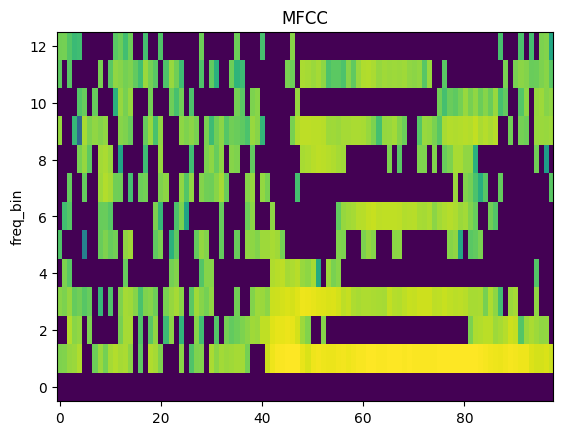

In [ ]:
transform = T.MFCC(sample_rate=sample_rate, n_mfcc=13, melkwargs={"n_fft": 400, "hop_length": 160, "n_mels": 23, "center": False},)
mfcc = transform(waveform)
plot_spectrogram(mfcc[0], title="MFCC")

En el código se crea la función aplicar_MFCC para crear los datasets transformados a coeficientes MFCC, computando su derivada y doble derivada, además de integrar el label del dataset original.

backward
backward
backward


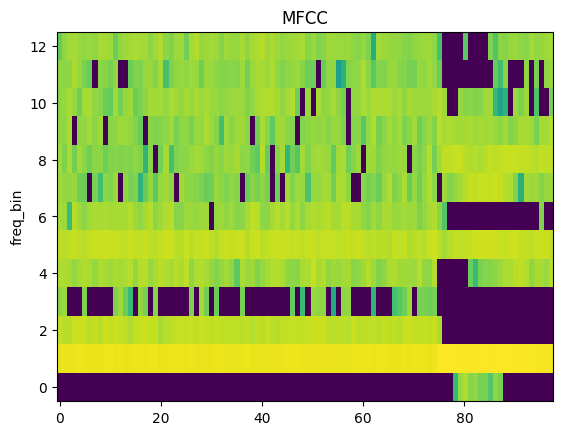

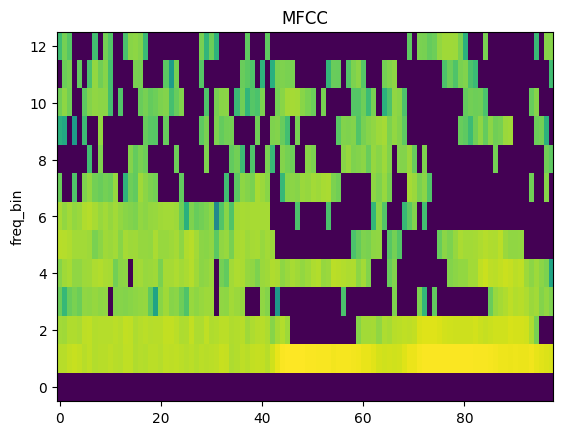

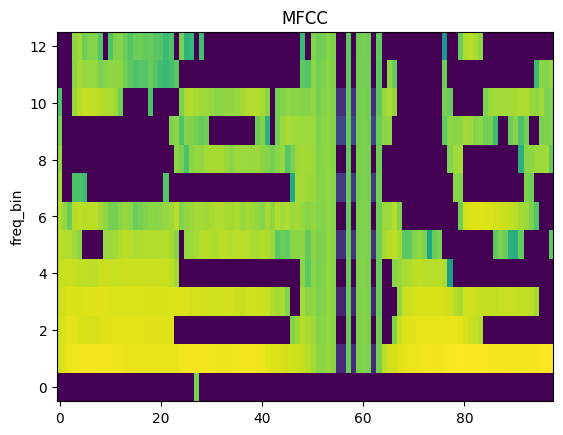

In [ ]:
def aplicar_MFCC (transform, dataset):
  MFCC_dataset = []
  for d in dataset:
    mfcc = transform(d[0])[0]
    delta = torchaudio.functional.compute_deltas(mfcc)
    delta2 = torchaudio.functional.compute_deltas(delta)
    MFCC_dataset.append([mfcc,delta,delta2, d[2]])
  return MFCC_dataset


Se prueba el código y se visualizan sus valores.

In [ ]:
MFCC_train = aplicar_MFCC(transform, train_dataset)
MFCC_val = aplicar_MFCC(transform, val_dataset)
MFCC_test = aplicar_MFCC(transform, test_dataset)
plot_spectrogram(MFCC_train[0] [0], title="MFCC")
print (MFCC_train[0][3])
plot_spectrogram(MFCC_val[0] [0], title="MFCC")
print (MFCC_val[0][3])
plot_spectrogram(MFCC_test[0] [0], title="MFCC")
print (MFCC_test[0][3])

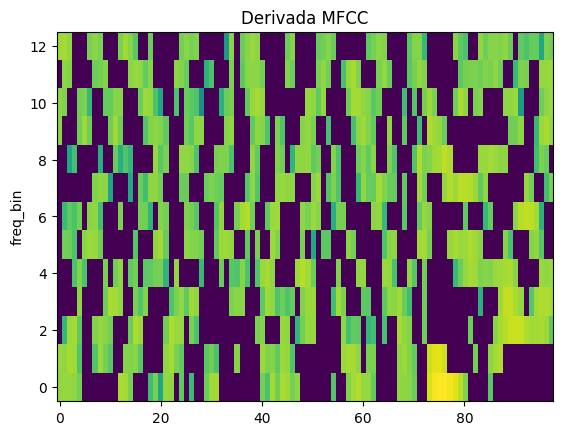

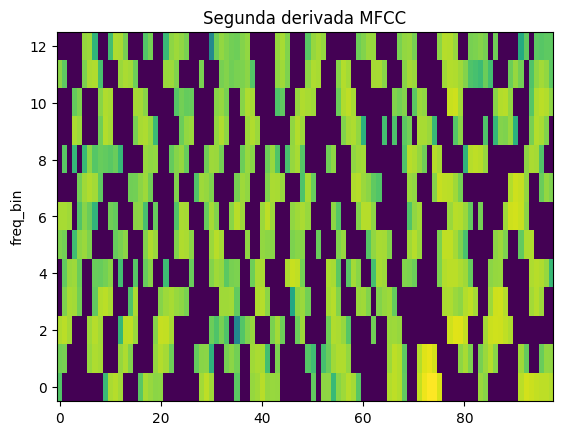

In [ ]:
plot_spectrogram(MFCC_train[0] [1], title="Derivada MFCC")
plot_spectrogram(MFCC_train[0] [2], title="Segunda derivada MFCC")

## Muestra de los datos

Se van a estudiar las características de las muestras originales de los datasets, desde el tamaño y distribución de cada clase al largo de los audios almacenados como tensores.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

In [ ]:
total = len (train_dataset) + len (test_dataset) + len (val_dataset)
print (f"Total = {total}")
print (f"Largo train: {len (train_dataset)}")
print (f"% train: {len (train_dataset)/total}")
print (f"Largo test: {len (test_dataset)}")
print (f"% test {len (test_dataset)/total}")
print (f"Largo val: {len (val_dataset)}")
print (f"% val: {len (val_dataset)/total}")

Total = 40709
Largo train: 32453
% train: 0.7971947235255104
Largo test: 4381
% test 0.10761748016409148
Largo val: 3875
% val: 0.0951877963103982


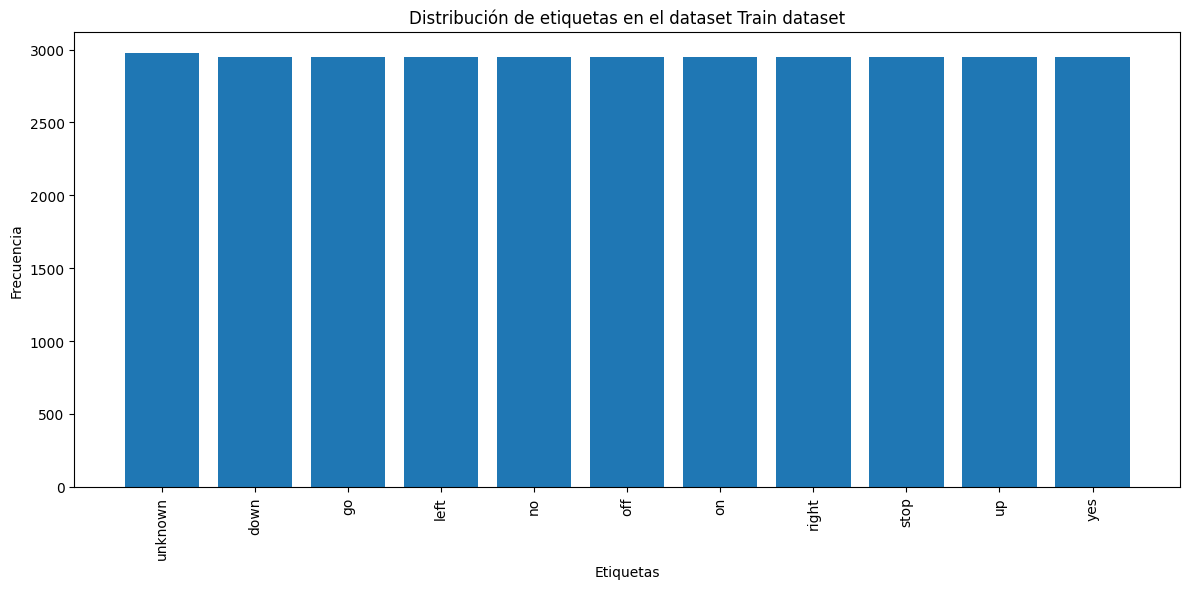

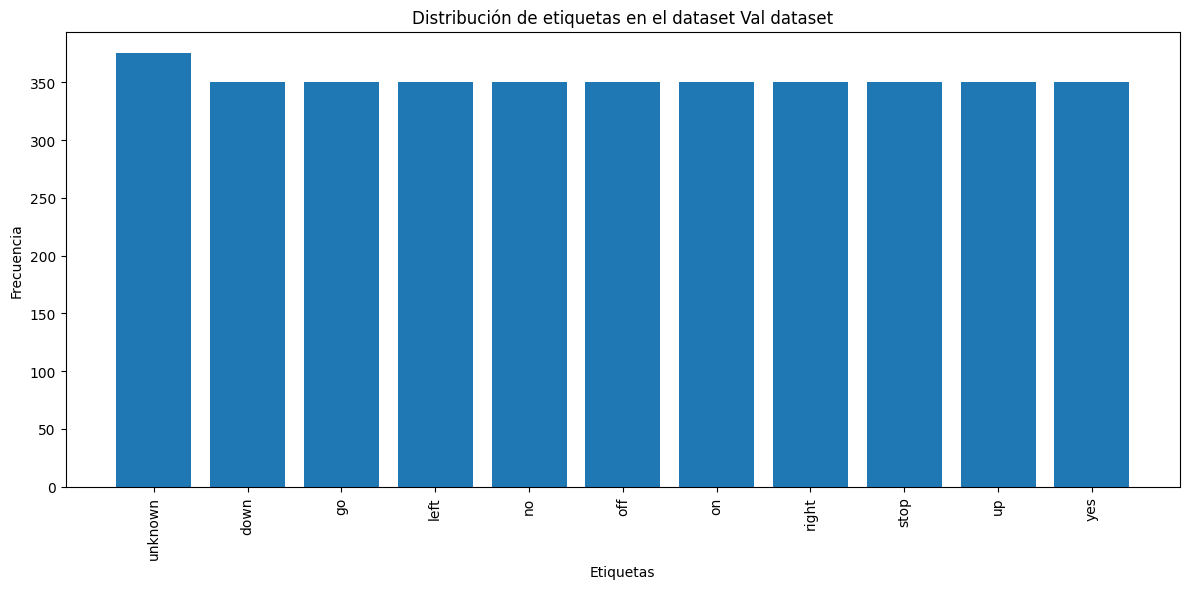

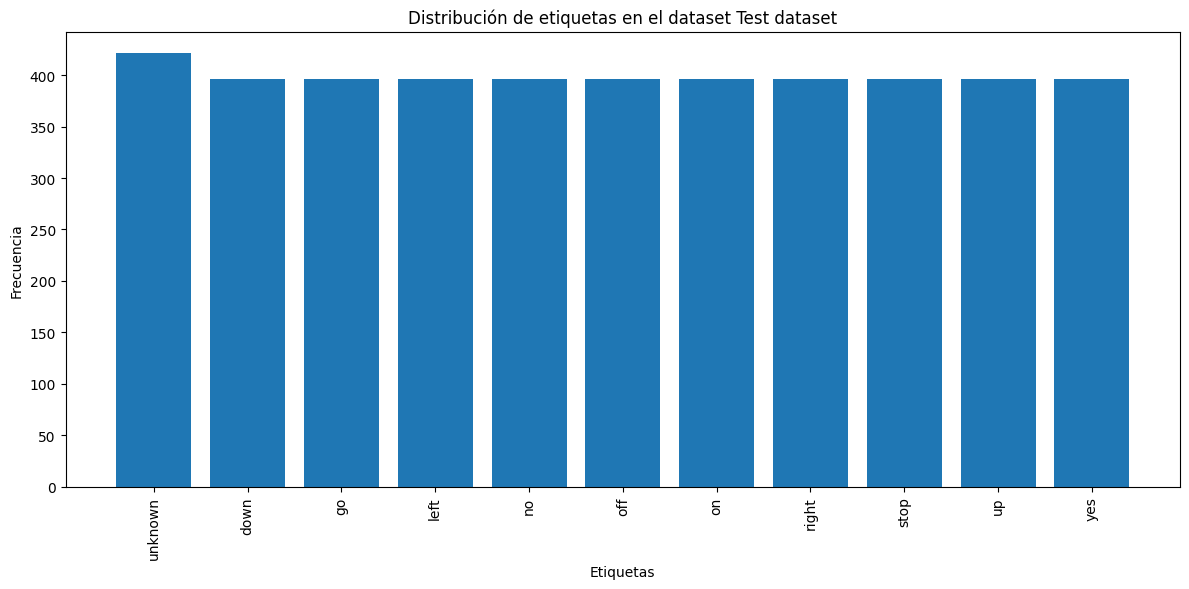

In [ ]:
def plot_labels(dataset, name):
    labels = []

    # extrae solo las etiquetas
    for i in range(len(dataset)):
        item = dataset[i]
        label = item[2] if len(item) > 2 else item[1]
        labels.append(label)

    counts = Counter(labels)
    # 10 etiquetas más frecuentes
    top10 = set([label for label, _ in counts.most_common(10)])
    # clasificar las demás como "unknown"
    labels_clasificadas = [label if label in top10 else "unknown" for label in labels]
    # nuevo conteo con "unknown"
    counts_final = Counter(labels_clasificadas)
    keys = np.array(list(counts_final.keys()))
    values = np.array(list(counts_final.values()), dtype=int)

    plt.figure(figsize=(12, 6))
    plt.bar(keys, values)
    plt.xlabel("Etiquetas")
    plt.ylabel("Frecuencia")
    plt.title(f"Distribución de etiquetas en el dataset {name}")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
    return labels

labels_train = plot_labels (train_dataset, "Train dataset")
labels_val =plot_labels (val_dataset, "Val dataset")
labels_test =plot_labels (test_dataset, "Test dataset")


In [ ]:
# Supongamos que tienes un elemento del dataset
waveform, sample_rate, label, speaker_id, utterance_number = train_dataset[1000]

# Guardar como archivo wav
torchaudio.save("ejemplo_train.wav", waveform, sample_rate)

print(f"Archivo guardado en ejemplo.wav, clase: {label}")

# Supongamos que tienes un elemento del dataset
waveform, sample_rate, label, speaker_id, utterance_number = val_dataset[500]
# Guardar como archivo wav
torchaudio.save("ejemplo_val.wav", waveform, sample_rate)

print(f"Archivo guardado en ejemplo_val.wav, clase:{label}")

# Supongamos que tienes un elemento del dataset
waveform, sample_rate, label, speaker_id, utterance_number = test_dataset[200]

# Guardar como archivo wav
torchaudio.save("ejemplo_test.wav", waveform, sample_rate)

print(f"Archivo guardado en ejemplo_test.wav, clase:{label}")

Audio("ejemplo_train.wav")

Archivo guardado en ejemplo.wav, clase: down
Archivo guardado en ejemplo_val.wav, clase:go
Archivo guardado en ejemplo_test.wav, clase:down


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:337: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.save_with_torchcodec` under the hood. Some parameters like format, encoding, bits_per_sample, buffer_size, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's encoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.encoders.AudioEncoder
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:247: UserWarning: torio.io._streaming_media_encoder.StreamingMediaEncoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  s 

In [ ]:
Audio("ejemplo_val.wav")

In [ ]:
Audio("ejemplo_test.wav")

In [ ]:
def duracion (dataset):
  list_duration = []
  list_largo = []
  for valor in dataset:
    waveform, _, _,_ ,_ = valor
    num_samples = waveform.shape[-1]
    duracion_segundos = num_samples / sample_rate
    list_duration.append (duracion_segundos)
    list_largo.append (waveform.shape[-1])
  array_duration = np.array (list_duration)
  array_largo = np.array (list_largo)
  print (f"Promedio largo: {np.mean (array_largo)}")
  print (f"Mediana largo: {np.median (array_largo)}")
  print (f"Promedio duración: {np.mean (array_duration)}")
  print (f"Mediana duración: {np.median (array_duration)}")

duracion (train_dataset)
duracion (val_dataset)
duracion (test_dataset)


Promedio largo: 15696.241672572643
Mediana largo: 16000.0
Promedio duración: 0.9810151045357903
Mediana duración: 1.0
Promedio largo: 15716.619612903225
Mediana largo: 16000.0
Promedio duración: 0.9822887258064515
Mediana duración: 1.0
Promedio largo: 15758.10157498288
Mediana largo: 16000.0
Promedio duración: 0.9848813484364303
Mediana duración: 1.0


In [ ]:
def rango(dataset, labels):
    largo = len(np.unique (labels))
    matriz = np.zeros((largo, 3), dtype=object)  # permitir strings y números
    matriz[:, 0] = np.array(np.unique (labels), dtype=object)
    matriz[:, 1] = np.inf
    matriz[:, 2] = -np.inf

    for valor in dataset:
        waveform, _, label, _, _ = valor
        i = np.where(matriz[:, 0] == label)[0]
        matriz[i, 1] = min(waveform.min().item(), matriz[i, 1])
        matriz[i, 2] = max(waveform.max().item(), matriz[i, 2])
    df = pd.DataFrame(matriz)
    df.columns = ['Labels', 'Min', 'Max']
    return df
print (np.unique (labels_train))
print (rango(train_dataset, labels_train))
print (rango(val_dataset, labels_train))
print (rango(test_dataset, labels_train))

['backward' 'bed' 'bird' 'cat' 'dog' 'down' 'eight' 'five' 'follow'
 'forward' 'four' 'go' 'happy' 'house' 'learn' 'left' 'marvin' 'nine' 'no'
 'off' 'on' 'one' 'right' 'seven' 'sheila' 'six' 'stop' 'three' 'tree'
 'two' 'up' 'visual' 'wow' 'yes' 'zero']
      Labels       Min       Max
0   backward      -1.0  0.918243
1        bed      -1.0  0.999969
2       bird      -1.0  0.999969
3        cat      -1.0  0.999969
4        dog      -1.0  0.999969
5       down      -1.0  0.999969
6      eight      -1.0  0.999969
7       five      -1.0  0.999969
8     follow      -1.0  0.999969
9    forward -0.879822  0.952911
10      four      -1.0  0.999969
11        go      -1.0  0.999969
12     happy      -1.0  0.999969
13     house      -1.0  0.999969
14     learn      -1.0  0.999969
15      left      -1.0  0.999969
16    marvin      -1.0  0.999969
17      nine      -1.0  0.996643
18        no      -1.0  0.999969
19       off      -1.0  0.999969
20        on      -1.0  0.999969
21       one -0.932

In [ ]:
import pandas as pd

def rango(dataset, labels):
    # etiquetas base conocidas (únicas)
    unique_labels = [str(lbl).strip().lower() for lbl in np.unique(labels)]
    largo = len(unique_labels)
    matriz = np.zeros((largo, 3), dtype=object)
    matriz[:, 0] = np.array(unique_labels, dtype=object)
    matriz[:, 1] = np.inf
    matriz[:, 2] = -np.inf

    for valor in dataset:
        waveform, _, label, _, _ = valor
        label = str(label).strip().lower()  # normaliza
        # si no pertenece al conjunto conocido → usar 'unknown'
        if label not in unique_labels:
            label = 'unknown'

        i = np.where(matriz[:, 0] == label)[0][0]
        matriz[i, 1] = min(waveform.min().item(), matriz[i, 1])
        matriz[i, 2] = max(waveform.max().item(), matriz[i, 2])

    df = pd.DataFrame(matriz, columns=['Label', 'Min', 'Max'])
    return df

# Ejemplo de uso
print("Train:")
print(rango(train_dataset, labels_train), "\n")

print("Validation:")
print(rango(val_dataset, labels_train), "\n")

print("Test:")
print(rango(test_dataset, labels_train))


Train:


NameError: name 'labels_train' is not defined

## Variación en mfcc

Se va a observar cómo la variacion en los parámetros n_fft y hop_lenght afectan a cómo se cosntruyen los coeficientes de MFCC.

n_ftt: mayor valor, mayor resolución frecuencia y menor temporal (no se detectan cambios rápidos en frecuencia).

hop_lenght: solapamiento. Al aumentar el hop_length, se incrementa la distancia entre cada ventana de análisis. Esto reduce el solapamiento entre las ventanas.  La información sobre eventos acústicos rápidos (como los cambios bruscos en el sonido) se pierde, ya que se están muestreando con menos frecuencia.

### n_fft

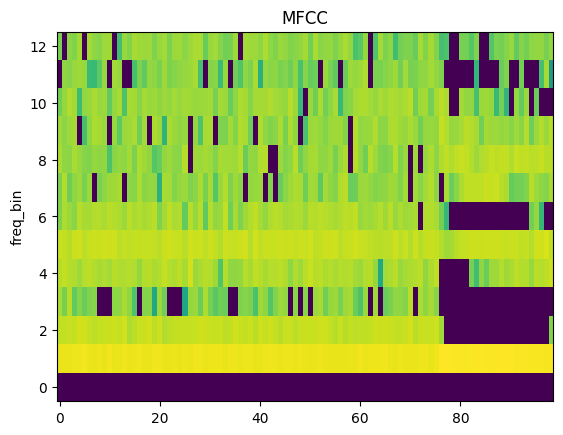

In [ ]:
transform = T.MFCC(sample_rate=sample_rate, n_mfcc=13, melkwargs={"n_fft": 200, "hop_length": 160, "n_mels": 23, "center": False},)
waveform, _, _, _ ,_ = train_dataset [0]
mfcc = transform(waveform)
plot_spectrogram(mfcc[0], title="MFCC")

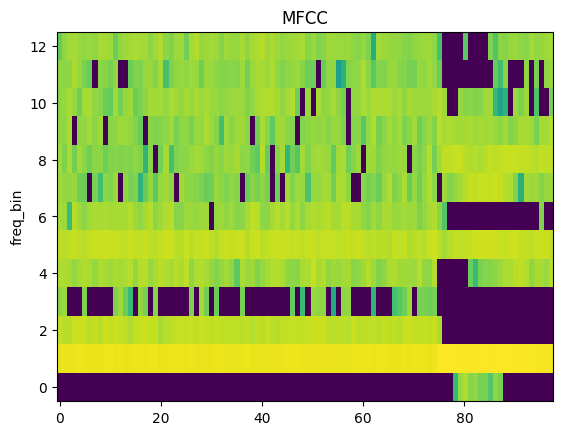

In [ ]:
transform = T.MFCC(sample_rate=sample_rate, n_mfcc=13, melkwargs={"n_fft": 400, "hop_length": 160, "n_mels": 23, "center": False},)
waveform, _, _, _ ,_ = train_dataset [0]
mfcc = transform(waveform)
plot_spectrogram(mfcc[0], title="MFCC")

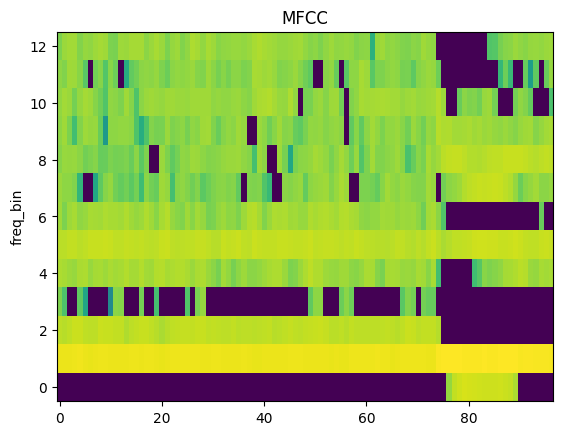

In [ ]:
transform = T.MFCC(sample_rate=sample_rate, n_mfcc=13, melkwargs={"n_fft": 600, "hop_length": 160, "n_mels": 23, "center": False},)
waveform, _, _, _ ,_ = train_dataset [0]
mfcc = transform(waveform)
plot_spectrogram(mfcc[0], title="MFCC")

### hop_lenght

En los siguientes códigos se visualizan los coeficientes MFCC junto con su tamaño para distintos hop_lenghts que se van a usar en el entrenamiento de las redes.

torch.Size([13, 317])


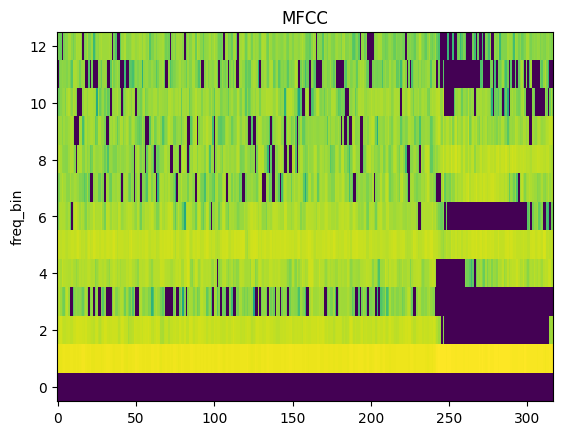

In [ ]:
transform = T.MFCC(sample_rate=sample_rate, n_mfcc=13, melkwargs={"n_fft": 200, "hop_length": 50, "n_mels": 23, "center": False},)
waveform, _, _, _ ,_ = train_dataset [0]
mfcc = transform(waveform)
plot_spectrogram(mfcc[0], title="MFCC")
print (mfcc [0].shape)

torch.Size([13, 211])


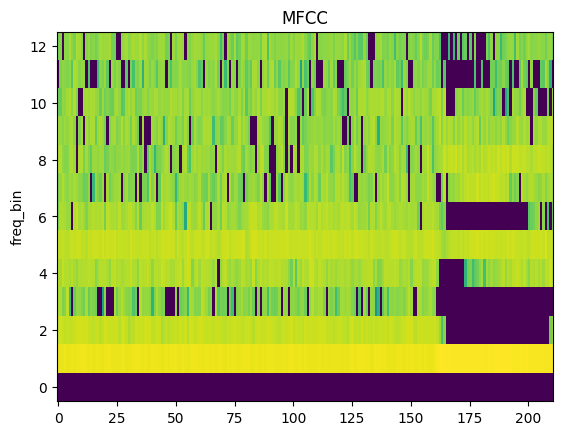

In [ ]:
transform = T.MFCC(sample_rate=sample_rate, n_mfcc=13, melkwargs={"n_fft": 200, "hop_length": 75, "n_mels": 23, "center": False},)
waveform, _, _, _ ,_ = train_dataset [0]
mfcc = transform(waveform)
plot_spectrogram(mfcc[0], title="MFCC")
print (mfcc [0].shape)

torch.Size([13, 159])


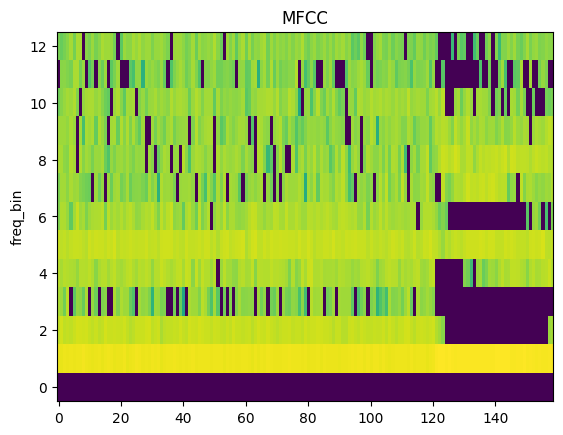

In [ ]:
transform = T.MFCC(sample_rate=sample_rate, n_mfcc=13, melkwargs={"n_fft": 200, "hop_length": 100, "n_mels": 23, "center": False},)
waveform, _, _, _ ,_ = train_dataset [0]
mfcc = transform(waveform)
plot_spectrogram(mfcc[0], title="MFCC")
print (mfcc [0].shape)

torch.Size([13, 122])


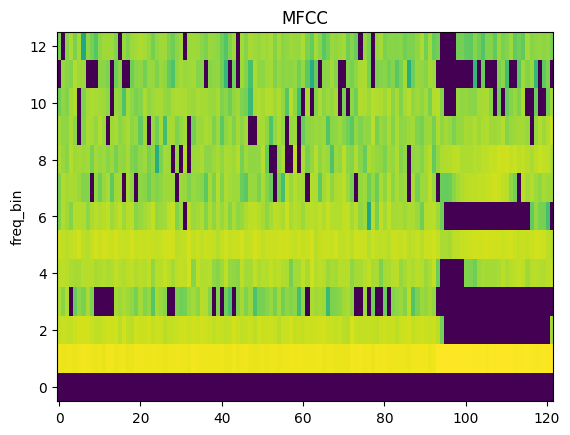

In [ ]:
transform = T.MFCC(sample_rate=sample_rate, n_mfcc=13, melkwargs={"n_fft": 200, "hop_length": 130, "n_mels": 23, "center": False},)
waveform, _, _, _ ,_ = train_dataset [0]
mfcc = transform(waveform)
plot_spectrogram(mfcc[0], title="MFCC")
print (mfcc [0].shape)

torch.Size([13, 99])


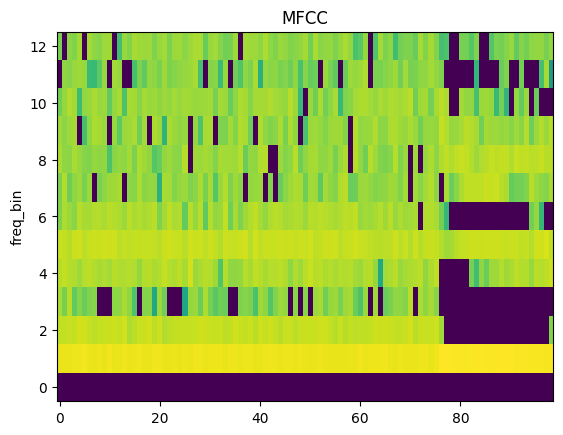

In [ ]:
transform = T.MFCC(sample_rate=sample_rate, n_mfcc=13, melkwargs={"n_fft": 200, "hop_length": 160, "n_mels": 23, "center": False},)
waveform, _, _, _ ,_ = train_dataset [0]
mfcc = transform(waveform)
plot_spectrogram(mfcc[0], title="MFCC")
print (mfcc [0].shape)

torch.Size([13, 72])


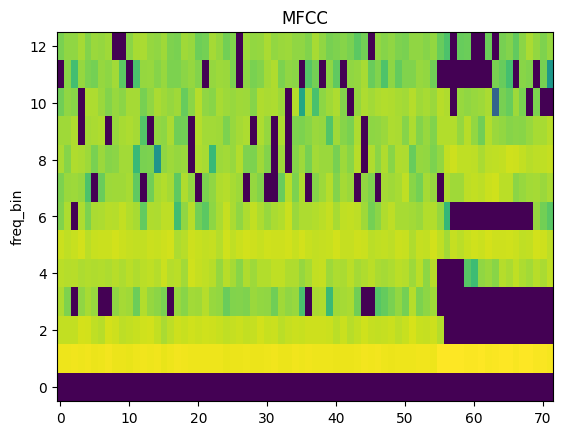

In [ ]:
transform = T.MFCC(sample_rate=sample_rate, n_mfcc=13, melkwargs={"n_fft": 200, "hop_length": 220, "n_mels": 23, "center": False},)
waveform, _, _, _ ,_ = train_dataset [0]
mfcc = transform(waveform)
plot_spectrogram(mfcc[0], title="MFCC")
print (mfcc [0].shape)

torch.Size([13, 57])


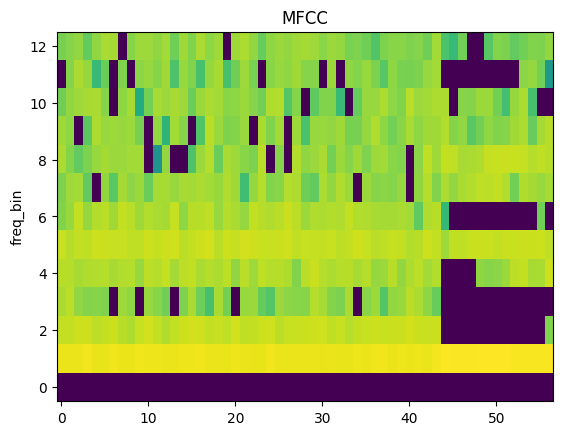

In [ ]:
transform = T.MFCC(sample_rate=sample_rate, n_mfcc=13, melkwargs={"n_fft": 200, "hop_length": 280, "n_mels": 23, "center": False},)
waveform, _, _, _ ,_ = train_dataset [0]
mfcc = transform(waveform)
plot_spectrogram(mfcc[0], title="MFCC")
print (mfcc [0].shape)

torch.Size([13, 44])


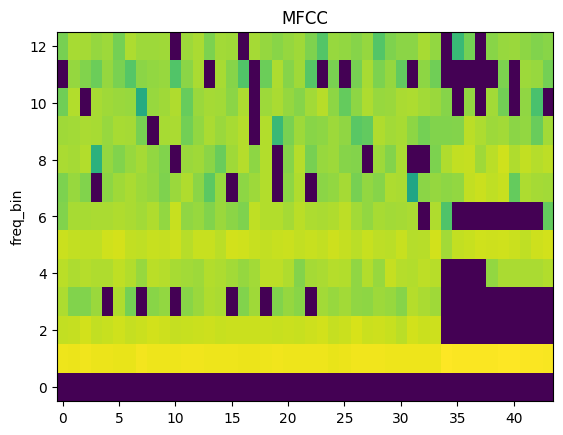

In [ ]:
transform = T.MFCC(sample_rate=sample_rate, n_mfcc=13, melkwargs={"n_fft": 200, "hop_length": 360, "n_mels": 23, "center": False},)
waveform, _, _, _ ,_ = train_dataset [0]
mfcc = transform(waveform)
plot_spectrogram(mfcc[0], title="MFCC")
print (mfcc [0].shape)

## Conteo clases más comunes

En esta parte se van a identificar las clases más frecuentes y asignar el resto al conjunto unknown para balancear el entrenamiento.

In [ ]:
# Leer el archivo .txt
with open("train_list.txt", "r") as f:
    lineas = f.readlines()

# Extraer la palabra (carpeta/clase) antes del '/'
clases = [linea.strip().split('/')[0] for linea in lineas]

# Contar cuántos ejemplos hay de cada clase
cuentas = Counter(clases)

# Mostrar las 15 clases más frecuentes
print("15 clases más frecuentes:")
for palabra, cantidad in cuentas.most_common(15):
    print(f"{palabra:10s} : {cantidad}")


15 clases más frecuentes:
yes        : 2948
no         : 2948
up         : 2948
down       : 2948
left       : 2948
right      : 2948
on         : 2948
off        : 2948
stop       : 2948
go         : 2948
backward   : 119
bed        : 119
bird       : 119
cat        : 119
dog        : 119


In [ ]:
clases_10 = ['yes','no','up','down','left','right','on','off','stop','go']

def relabel(dataset,mfc):
    clases10_mf = []
    for wav, sr, label, spk, utn in dataset :
        if label not in mfc:
            label = "unknown"
        clases10_mf.append((wav, sr, label, spk, utn))
    return clases10_mf

train_dataset1 = relabel(train_dataset, clases_10)
val_dataset1   = relabel(val_dataset, clases_10)
test_dataset1  = relabel(test_dataset, clases_10)


## Preprocesamiento de dataset y transformación a MFCC

Se va a ajustar el largo de los audios y se va a crear el dataset base para verificar cuáles son los mejores parámetros para cada arquitectura.

In [ ]:

# Ajusta todos los waveforms al mismo largo
def adjust_len(tensor, target_len):
    n_features, T = tensor.shape
    if T < target_len:
        # Rellenar con ceros
        tensor = F.pad(tensor, (0, target_len - T))
    elif T > target_len:
        # Recortar si es más largo
        tensor = tensor[:, :target_len]
    return tensor

def adaptar_len_dataset (dataset, target_len_waveform):
    dataset_waveforms_fixed = []
    for waveform, sr, label, speaker, utterance in dataset:
        waveform_fixed = adjust_len(waveform, target_len_waveform)
        dataset_waveforms_fixed.append((waveform_fixed, sr, label, speaker, utterance))
    return dataset_waveforms_fixed

In [ ]:

train_adaptado = adaptar_len_dataset (train_dataset1, 16000)
val_adaptado = adaptar_len_dataset (val_dataset1, 16000)
test_adaptado = adaptar_len_dataset (test_dataset1, 16000)

In [ ]:
# Estándar con 160 hop
transform = T.MFCC(sample_rate=sample_rate, n_mfcc=13, melkwargs={"n_fft": 400, "hop_length": 160, "n_mels": 23, "center": False},)
MFCC_train_10 = aplicar_MFCC(transform, train_adaptado)
MFCC_val_10 = aplicar_MFCC(transform, val_adaptado)
MFCC_test_10 = aplicar_MFCC(transform, test_adaptado)

## Creación de modelos

En esta parte se van a especificar los dataloaders para entregar los datos y entrenar los modelos.

In [ ]:
def get_label_mapping(data_list):
    labels = sorted(set(d[3] for d in data_list))
    return {lbl: i for i, lbl in enumerate(labels)}
label_map = get_label_mapping(MFCC_train_10)

class SpeechCommandsMFCC(Dataset):
    def __init__(self, data, label_num):
        self.data = data
        #labels = sorted(set(d[3] for d in data_list))
        #return {lbl: i for i, lbl in enumerate(labels)}
        self.label_num = label_num

    def __getitem__(self, idx):
        mfcc, d1, d2, label = self.data[idx]
        x = torch.cat([mfcc, d1, d2], dim=0)
        y = self.label_num[label]
        return x, y

    def __len__(self):
        return len(self.data)


In [ ]:
def load (MFCC_train, MFCC_val, MFCC_test, batch_size=64):
    tr = SpeechCommandsMFCC(MFCC_train, label_num=label_map)
    print(tr.label_num)
    va = SpeechCommandsMFCC(MFCC_val, label_num=label_map)
    print(va.label_num)
    te = SpeechCommandsMFCC(MFCC_test, label_num=label_map)
    print(te.label_num)
    return (DataLoader(tr, batch_size=batch_size, shuffle=True),
            DataLoader(va, batch_size=batch_size, shuffle=False),
            DataLoader(te, batch_size=batch_size, shuffle=False))


Se definen a continuación los modelos de redes neuronales recurrentes a usar.

In [ ]:
class RNNVanilla(nn.Module):
    def __init__(self, input_size=39, hidden_size=128, num_layers=1,
                 bidirectional=False, nonlinearity="tanh", num_classes=11):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers,
                          nonlinearity=nonlinearity, bidirectional=bidirectional,
                          batch_first=True)
        bod_ = hidden_size * (2 if bidirectional else 1)
        self.fc = nn.Linear(bod_, num_classes)

    def forward(self, x):
        x = x.transpose(1, 2)
        _, mf_h = self.rnn(x)
        if self.rnn.bidirectional:
            mf_h_final = torch.cat([mf_h[-2], mf_h[-1]], dim=1)
        else:
            mf_h_final = mf_h[-1]
        return self.fc(mf_h_final)


In [ ]:
class GRUModel(nn.Module):
    def __init__(self, input_size=39, hidden_size=128, num_layers=1, bidirectional=False, num_classes=11):
        super().__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers=num_layers, bidirectional=bidirectional, batch_first=True)
        bod_ = hidden_size * (2 if bidirectional else 1)
        self.fc = nn.Linear(bod_, num_classes)
    def forward(self, x):
        x = x.transpose(1,2)
        _, h = self.gru(x)
        mf_h_final = torch.cat([h[-2], h[-1]], dim=1) if self.gru.bidirectional else h[-1]
        return self.fc(mf_h_final)


In [ ]:

class LSTMModel(nn.Module):
    def __init__(self, input_size=39, hidden_size=128, num_layers=1, bidirectional=False, num_classes=11):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, bidirectional=bidirectional, batch_first=True)
        bod_ = hidden_size * (2 if bidirectional else 1)
        self.fc = nn.Linear(bod_, num_classes)
    def forward(self, x):
        x = x.transpose(1,2)
        _, (h, _) = self.lstm(x)
        mf_h_final = torch.cat([h[-2], h[-1]], dim=1) if self.lstm.bidirectional else h[-1]
        return self.fc(mf_h_final)

In [ ]:
def train_step(x_batch, y_batch, model, optimizer, criterion):
    model.train()
    y_pred = model(x_batch)
    loss = criterion(y_pred, y_batch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return y_pred, loss

@torch.no_grad()
def evaluate(val_loader, model, criterion, device="cpu"):
    model.eval()
    cumulative_loss = 0.0
    cumulative_predictions = 0
    data_count = 0

    for x_val, y_val in val_loader:
        x_val, y_val = x_val.to(device), y_val.to(device)
        y_predicted = model(x_val)
        loss = criterion(y_predicted, y_val)
        class_prediction = torch.argmax(y_predicted, dim=1).long()

        cumulative_predictions += (y_val == class_prediction).sum().item()
        cumulative_loss += loss.item()
        data_count += y_val.size(0)

    val_acc = cumulative_predictions / data_count
    val_loss = cumulative_loss / max(1, len(val_loader))
    return val_acc, val_loss

def train_model(
    model,
    train_loader,
    val_loader,
    epochs,
    criterion,
    lr,
    device="cpu",
    n_evaluations_per_epoch=6,
    early_stopping_patience=None,
):
    if device == "cuda" and torch.cuda.is_available():
        model = model.cuda()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    curves = {"train_acc": [], "val_acc": [], "train_loss": [], "val_loss": []}
    t0 = time.perf_counter()
    iteration = 0
    n_batches = len(train_loader)

    best_val_acc = -1.0
    best_state = None
    patience = 0

    for epoch in range(epochs):
        print(f"\rEpoch {epoch + 1}/{epochs}")
        cumulative_train_loss = 0.0
        cumulative_train_corrects = 0
        train_loss_count = 0
        train_acc_count = 0

        model.train()
        for i, (x_batch, y_batch) in enumerate(train_loader):
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            y_predicted, loss = train_step(x_batch, y_batch, model, optimizer, criterion)

            cumulative_train_loss += loss.item()
            train_loss_count += 1
            train_acc_count += y_batch.size(0)

            class_prediction = torch.argmax(y_predicted, dim=1).long()
            cumulative_train_corrects += (y_batch == class_prediction).sum().item()

            if (i % max(1, (n_batches // max(1, n_evaluations_per_epoch))) == 0) and (i > 0):
                train_loss = cumulative_train_loss / train_loss_count
                train_acc = cumulative_train_corrects / train_acc_count
                print(f"Iteration {iteration} - Batch {i}/{len(train_loader)} - "
                      f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.2%}")
            iteration += 1

        # validación
        val_acc, val_loss = evaluate(val_loader, model, criterion, device=device)
        train_loss = cumulative_train_loss / max(1, train_loss_count)
        train_acc = cumulative_train_corrects / max(1, train_acc_count)

        print(f"Val loss: {val_loss:.4f}, Val acc: {val_acc:.2%}")

        curves["train_acc"].append(train_acc)
        curves["val_acc"].append(val_acc)
        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)

        # early stopping
        if early_stopping_patience is not None:
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_state = {k: v.detach().cpu() for k, v in model.state_dict().items()}
                patience = 0
            else:
                patience += 1
                if patience >= early_stopping_patience:
                    print(f"Early stopping: sin mejora en {early_stopping_patience} épocas.")
                    if best_state is not None:
                        model.load_state_dict(best_state)
                    break

    print(f"\nTiempo total de entrenamiento: {time.perf_counter() - t0:.4f} [s]")
    model.cpu()
    return curves



In [ ]:
def show_curves(curves, title = None, filename = None):
    fig, ax = plt.subplots(1, 2, figsize=(13, 5))
    fig.set_facecolor('white')

    epochs = np.arange(len(curves["val_loss"])) + 1

    ax[0].plot(epochs, curves['val_loss'], label='validation')
    ax[0].plot(epochs, curves['train_loss'], label='training')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_ylim(0.0,3.0)
    ax[0].set_title('Loss evolution during training')
    ax[0].legend()

    ax[1].plot(epochs, curves['val_acc'], label='validation')
    ax[1].plot(epochs, curves['train_acc'], label='training')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_ylim(0.0,1.0)
    ax[1].set_title('Accuracy evolution during training')
    ax[1].legend()

    if title is not None:
        fig.suptitle(title)

    if filename is not None:
        plt.savefig(filename)

    plt.show()


In [ ]:
def show_confusion_matrix(y_true, y_pred, class_names, title=None, normalize=True, filename=None):
    labels = list(range(len(class_names)))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    if normalize:
        cm = cm.astype(float) / cm.sum(axis=1, keepdims=True).clip(min=1)

    fig, ax = plt.subplots(figsize=(7,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=ax, xticks_rotation=45, values_format=".2f" if normalize else "d", colorbar=False)
    ax.set_xlabel("Predicción"); ax.set_ylabel("Verdad")
    ax.set_title(title or "Matriz de confusión")
    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=200, bbox_inches="tight")
    plt.show()
    print(classification_report(y_true, y_pred, target_names=class_names))
    # Precisión (Accuracy): porcentaje de predicciones correctas
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Precisión global (Accuracy): {accuracy:.4f}")

In [ ]:
train_dl, val_dl, test_dl = load (MFCC_train_10, MFCC_val_10, MFCC_test_10, batch_size=64)
dataset_instance = test_dl.dataset
num_label = {i: lbl for lbl, i in dataset_instance.label_num.items()}
class_names = [num_label[i] for i in sorted(num_label.keys())]

{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}


## Entrenamiento y experimentos

### RNN Vanilla


#### Variación de neuronas por capa

{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
Epoch 1/20
Iteration 84 - Batch 84/508 - Train loss: 2.4003, Train acc: 11.21%
Iteration 168 - Batch 168/508 - Train loss: 2.3909, Train acc: 11.78%
Iteration 252 - Batch 252/508 - Train loss: 2.3857, Train acc: 11.81%
Iteration 336 - Batch 336/508 - Train loss: 2.3821, Train acc: 11.95%
Iteration 420 - Batch 420/508 - Train loss: 2.3784, Train acc: 12.11%
Iteration 504 - Batch 504/508 - Train loss: 2.3761, Train acc: 12.18%
Val loss: 2.3482, Val acc: 13.42%
Epoch 2/20
Iteration 592 - Batch 84/508 - Train loss: 2.3459, Train acc: 14.04%
Iteration 676 - Batch 168/508 - Train loss: 2.3416, Train acc: 14.53%
Iteration 760 - Batch 252/508 - Trai

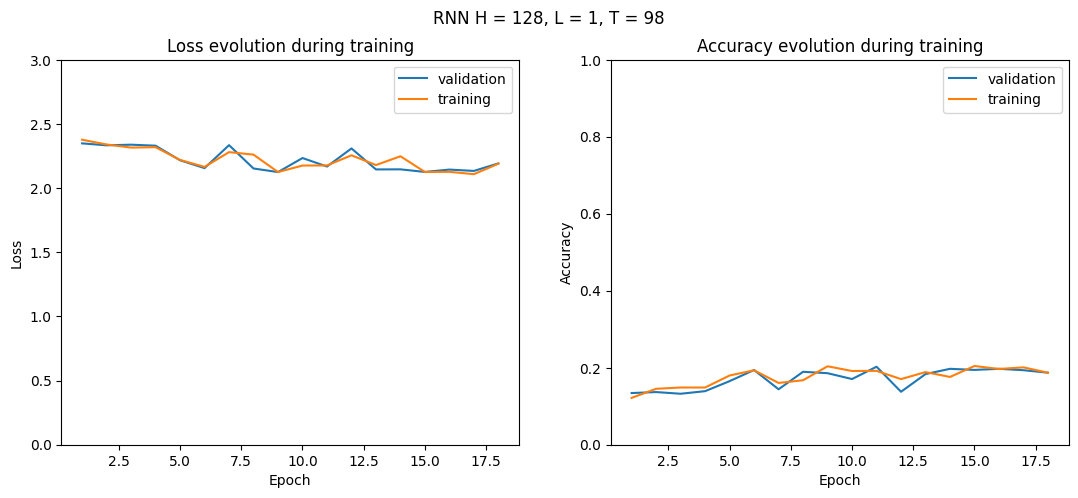

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

clases_10 = ['down','go','left','no','off','on','right','stop','unkwown','up', "yes"]
train_dl, val_dl, test_dl = load (MFCC_train_10, MFCC_val_10, MFCC_test_10, batch_size=64)

model = RNNVanilla(input_size=39, hidden_size=128, num_layers=1,
                   bidirectional=False, nonlinearity="tanh", num_classes=11)

criterion = nn.CrossEntropyLoss()

curves = train_model(
    model, train_dl, val_dl,
    epochs=20, lr=1e-3, criterion=criterion,
    device=device, early_stopping_patience=7
)

show_curves(curves, title="RNN H = 128, L = 1, T = 98", filename="rnn_vanilla_h=128.png")

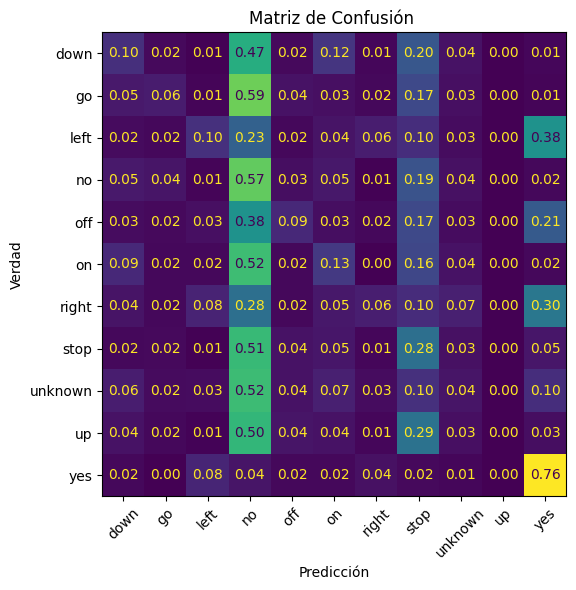

              precision    recall  f1-score   support

        down       0.20      0.10      0.13       396
          go       0.23      0.06      0.09       396
        left       0.28      0.10      0.15       396
          no       0.12      0.57      0.20       396
         off       0.25      0.09      0.13       396
          on       0.21      0.13      0.16       396
       right       0.24      0.06      0.10       396
        stop       0.15      0.28      0.20       396
     unknown       0.12      0.04      0.06       421
          up       0.00      0.00      0.00       396
         yes       0.40      0.76      0.52       396

    accuracy                           0.20      4381
   macro avg       0.20      0.20      0.16      4381
weighted avg       0.20      0.20      0.16      4381

Precisión global (Accuracy): 0.1979


In [ ]:
@torch.no_grad()
def get_predictions(loader, model, device="cpu"):
    """Obtiene las predicciones del modelo y las etiquetas verdaderas."""
    model.eval()
    all_predictions = []
    all_true_labels = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb).argmax(1)

        all_predictions.extend(pred.cpu().numpy())
        all_true_labels.extend(yb.cpu().numpy())
    return all_true_labels, all_predictions

true_labels, predictions = get_predictions(test_dl, model.to(device), device)

show_confusion_matrix(true_labels, predictions, class_names, title="Matriz de Confusión ", filename = "matriz_de_confusión_H=128")

{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
Epoch 1/20
Iteration 84 - Batch 84/508 - Train loss: 2.4117, Train acc: 9.76%
Iteration 168 - Batch 168/508 - Train loss: 2.3995, Train acc: 10.32%
Iteration 252 - Batch 252/508 - Train loss: 2.3940, Train acc: 10.72%
Iteration 336 - Batch 336/508 - Train loss: 2.3882, Train acc: 10.97%
Iteration 420 - Batch 420/508 - Train loss: 2.3837, Train acc: 11.32%
Iteration 504 - Batch 504/508 - Train loss: 2.3803, Train acc: 11.49%
Val loss: 2.3561, Val acc: 12.72%
Epoch 2/20
Iteration 592 - Batch 84/508 - Train loss: 2.3529, Train acc: 12.28%
Iteration 676 - Batch 168/508 - Train loss: 2.3554, Train acc: 12.53%
Iteration 760 - Batch 252/508 - Train

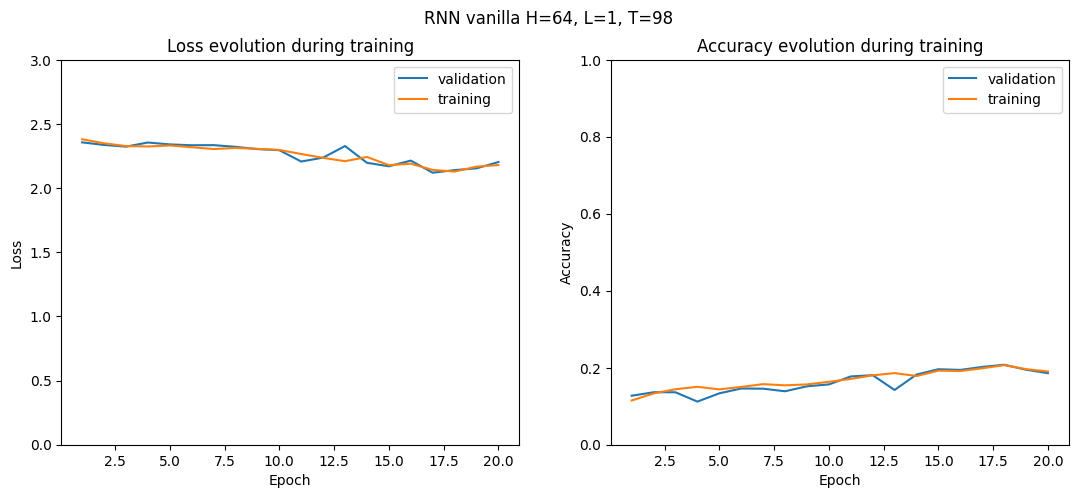

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


train_dl, val_dl, test_dl = load (MFCC_train_10, MFCC_val_10, MFCC_test_10, batch_size=64)

model = RNNVanilla(input_size=39, hidden_size=64, num_layers=1,
                   bidirectional=False, nonlinearity="tanh", num_classes=11)

criterion = nn.CrossEntropyLoss()

curves = train_model(
    model, train_dl, val_dl,
    epochs=20, lr=1e-3, criterion=criterion,
    device=device, early_stopping_patience=7
)

show_curves(curves, title="RNN vanilla H=64, L=1, T=98", filename="rnn_vanilla_H=64.png")

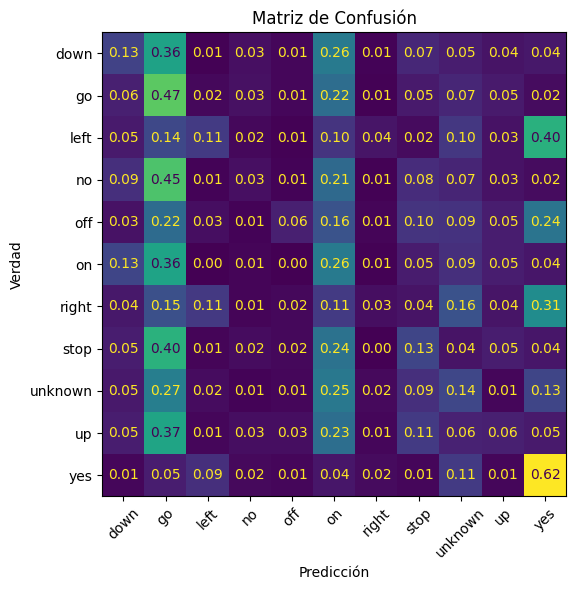

              precision    recall  f1-score   support

        down       0.18      0.13      0.15       396
          go       0.14      0.47      0.22       396
        left       0.27      0.11      0.15       396
          no       0.14      0.03      0.05       396
         off       0.32      0.06      0.10       396
          on       0.12      0.26      0.17       396
       right       0.17      0.03      0.04       396
        stop       0.18      0.13      0.15       396
     unknown       0.15      0.14      0.14       421
          up       0.13      0.06      0.08       396
         yes       0.32      0.62      0.43       396

    accuracy                           0.18      4381
   macro avg       0.19      0.18      0.15      4381
weighted avg       0.19      0.18      0.15      4381

Precisión global (Accuracy): 0.1831


In [ ]:
@torch.no_grad()
def get_predictions(loader, model, device="cpu"):
    """Obtiene las predicciones del modelo y las etiquetas verdaderas."""
    model.eval()
    all_predictions = []
    all_true_labels = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb).argmax(1)

        all_predictions.extend(pred.cpu().numpy())
        all_true_labels.extend(yb.cpu().numpy())
    return all_true_labels, all_predictions

true_labels, predictions = get_predictions(test_dl, model.to(device), device)

show_confusion_matrix(true_labels, predictions, class_names, title="Matriz de Confusión", filename = "matriz_de_confusión_H=64")


{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
Epoch 1/20
Iteration 84 - Batch 84/508 - Train loss: 2.4063, Train acc: 10.96%
Iteration 168 - Batch 168/508 - Train loss: 2.3984, Train acc: 11.28%
Iteration 252 - Batch 252/508 - Train loss: 2.3888, Train acc: 11.81%
Iteration 336 - Batch 336/508 - Train loss: 2.3839, Train acc: 11.94%
Iteration 420 - Batch 420/508 - Train loss: 2.3783, Train acc: 12.15%
Iteration 504 - Batch 504/508 - Train loss: 2.3722, Train acc: 12.49%
Val loss: 2.3670, Val acc: 13.52%
Epoch 2/20
Iteration 592 - Batch 84/508 - Train loss: 2.3505, Train acc: 13.92%
Iteration 676 - Batch 168/508 - Train loss: 2.3375, Train acc: 14.21%
Iteration 760 - Batch 252/508 - Trai

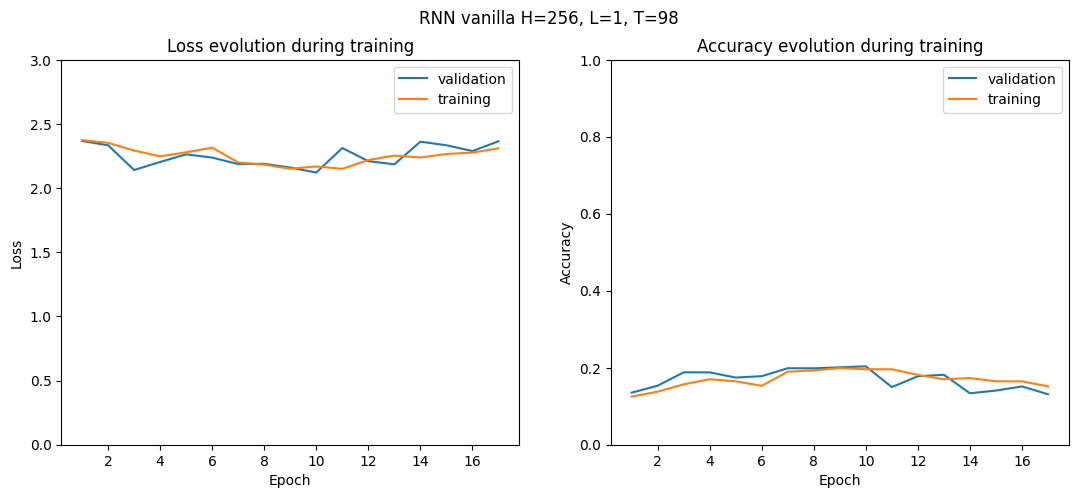

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


train_dl, val_dl, test_dl = load (MFCC_train_10, MFCC_val_10, MFCC_test_10, batch_size=64)

model = RNNVanilla(input_size=39, hidden_size=256, num_layers=1,
                   bidirectional=False, nonlinearity="tanh", num_classes=11)

criterion = nn.CrossEntropyLoss()

curves = train_model(
    model, train_dl, val_dl,
    epochs=20, lr=1e-3, criterion=criterion,
    device=device, early_stopping_patience=7
)

show_curves(curves, title="RNN vanilla H=256, L=1, T=98", filename="rnn_vanilla_H=256.png")

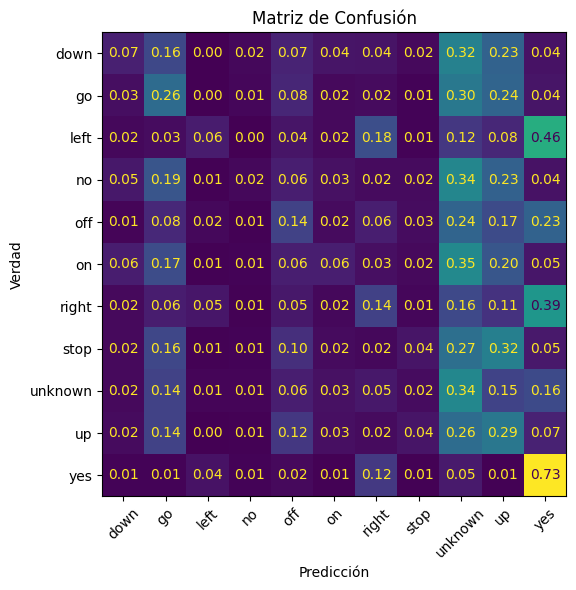

              precision    recall  f1-score   support

        down       0.21      0.07      0.10       396
          go       0.18      0.26      0.21       396
        left       0.31      0.06      0.09       396
          no       0.16      0.02      0.03       396
         off       0.18      0.14      0.16       396
          on       0.21      0.06      0.09       396
       right       0.20      0.14      0.17       396
        stop       0.19      0.04      0.07       396
     unknown       0.13      0.34      0.19       421
          up       0.14      0.29      0.19       396
         yes       0.33      0.73      0.45       396

    accuracy                           0.20      4381
   macro avg       0.20      0.20      0.16      4381
weighted avg       0.20      0.20      0.16      4381

Precisión global (Accuracy): 0.1961


In [ ]:
@torch.no_grad()
def get_predictions(loader, model, device="cpu"):
    """Obtiene las predicciones del modelo y las etiquetas verdaderas."""
    model.eval()
    all_predictions = []
    all_true_labels = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb).argmax(1)

        all_predictions.extend(pred.cpu().numpy())
        all_true_labels.extend(yb.cpu().numpy())
    return all_true_labels, all_predictions

true_labels, predictions = get_predictions(test_dl, model.to(device), device)

show_confusion_matrix(true_labels, predictions, class_names, title="Matriz de Confusión", filename = "matriz_de_confusión_h=256")


#### Variación número de capas

{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
Epoch 1/20
Iteration 84 - Batch 84/508 - Train loss: 2.4021, Train acc: 10.77%
Iteration 168 - Batch 168/508 - Train loss: 2.3984, Train acc: 10.89%
Iteration 252 - Batch 252/508 - Train loss: 2.3970, Train acc: 11.07%
Iteration 336 - Batch 336/508 - Train loss: 2.3930, Train acc: 11.36%
Iteration 420 - Batch 420/508 - Train loss: 2.3879, Train acc: 11.64%
Iteration 504 - Batch 504/508 - Train loss: 2.3805, Train acc: 12.00%
Val loss: 2.3560, Val acc: 14.63%
Epoch 2/20
Iteration 592 - Batch 84/508 - Train loss: 2.3431, Train acc: 13.88%
Iteration 676 - Batch 168/508 - Train loss: 2.3203, Train acc: 14.16%
Iteration 760 - Batch 252/508 - Trai

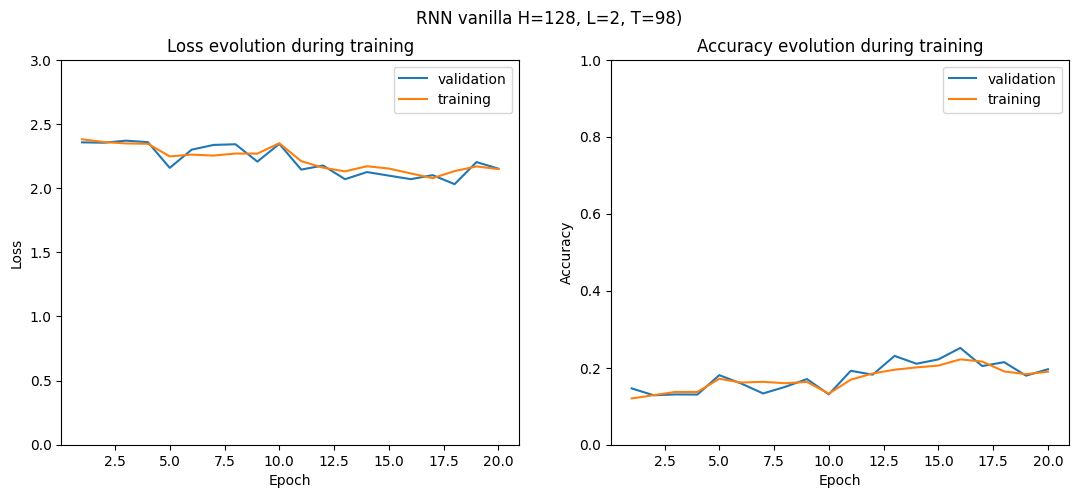

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


train_dl, val_dl, test_dl = load (MFCC_train_10, MFCC_val_10, MFCC_test_10, batch_size=64)

model =RNNVanilla(input_size=39, hidden_size=128, num_layers=2,
                   bidirectional=False,nonlinearity="tanh", num_classes=11)

criterion = nn.CrossEntropyLoss()

curves = train_model(
    model, train_dl, val_dl,
    epochs=20, lr=1e-3, criterion=criterion,
    device=device, early_stopping_patience=7
)

show_curves(curves, title="RNN vanilla H=128, L=2, T=98)", filename="gru_vanilla_L=2.png")

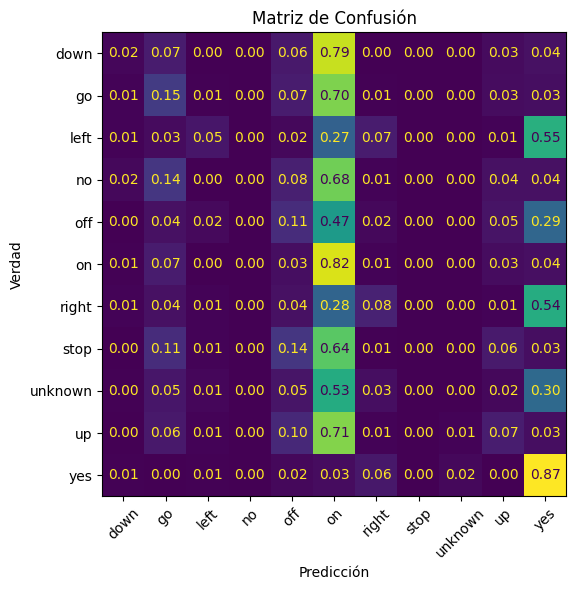

              precision    recall  f1-score   support

        down       0.19      0.02      0.03       396
          go       0.20      0.15      0.17       396
        left       0.39      0.05      0.09       396
          no       0.00      0.00      0.00       396
         off       0.15      0.11      0.13       396
          on       0.14      0.82      0.24       396
       right       0.28      0.08      0.13       396
        stop       0.00      0.00      0.00       396
     unknown       0.00      0.00      0.00       421
          up       0.20      0.07      0.10       396
         yes       0.31      0.87      0.46       396

    accuracy                           0.20      4381
   macro avg       0.17      0.20      0.12      4381
weighted avg       0.17      0.20      0.12      4381

Precisión global (Accuracy): 0.1954


In [ ]:
@torch.no_grad()
def get_predictions(loader, model, device="cpu"):
    """Obtiene las predicciones del modelo y las etiquetas verdaderas."""
    model.eval()
    all_predictions = []
    all_true_labels = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb).argmax(1)

        all_predictions.extend(pred.cpu().numpy())
        all_true_labels.extend(yb.cpu().numpy())
    return all_true_labels, all_predictions

true_labels, predictions = get_predictions(test_dl, model.to(device), device)

show_confusion_matrix(true_labels, predictions, class_names, title="Matriz de Confusión", filename = "matriz_de_confusión_L=2")

{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
Epoch 1/20
Iteration 84 - Batch 84/508 - Train loss: 2.4029, Train acc: 10.74%
Iteration 168 - Batch 168/508 - Train loss: 2.3963, Train acc: 10.97%
Iteration 252 - Batch 252/508 - Train loss: 2.4004, Train acc: 10.67%
Iteration 336 - Batch 336/508 - Train loss: 2.3646, Train acc: 12.21%
Iteration 420 - Batch 420/508 - Train loss: 2.3475, Train acc: 12.82%
Iteration 504 - Batch 504/508 - Train loss: 2.3287, Train acc: 13.23%
Val loss: 2.1658, Val acc: 17.08%
Epoch 2/20
Iteration 592 - Batch 84/508 - Train loss: 2.2319, Train acc: 15.77%
Iteration 676 - Batch 168/508 - Train loss: 2.2062, Train acc: 16.97%
Iteration 760 - Batch 252/508 - Trai

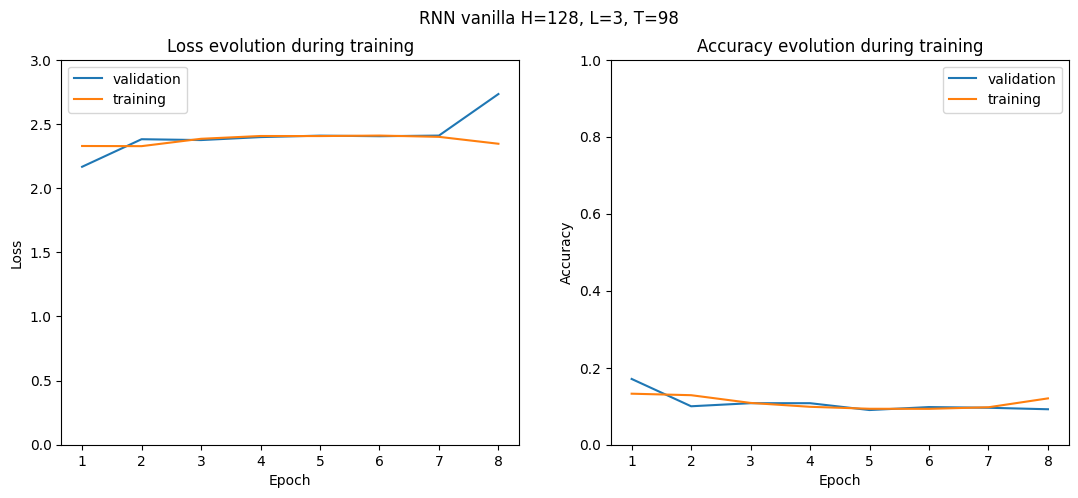

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
train_dl, val_dl, test_dl = load (MFCC_train_10, MFCC_val_10, MFCC_test_10, batch_size=64)

model = RNNVanilla(input_size=39, hidden_size=128, num_layers=3,
                   bidirectional=False, nonlinearity="tanh", num_classes=11)

criterion = nn.CrossEntropyLoss()

curves = train_model(
    model, train_dl, val_dl,
    epochs=20, lr=1e-3, criterion=criterion,
    device=device, early_stopping_patience=7
)

show_curves(curves, title="RNN vanilla H=128, L=3, T=98", filename="gru_vanilla_L=3.png")

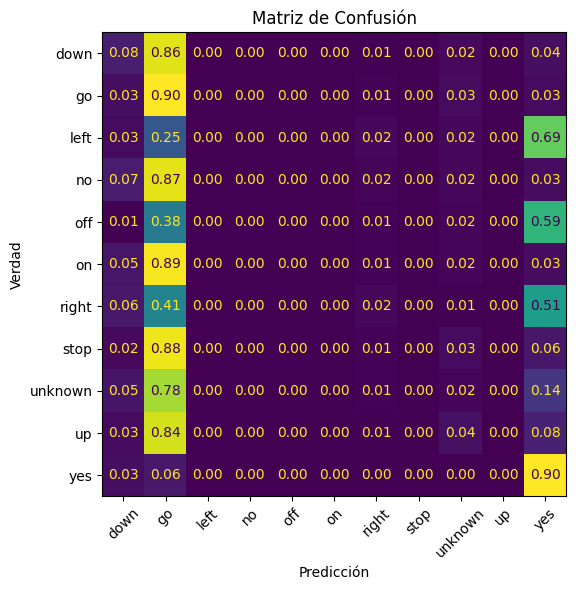

              precision    recall  f1-score   support

        down       0.16      0.08      0.10       396
          go       0.13      0.90      0.22       396
        left       0.00      0.00      0.00       396
          no       0.00      0.00      0.00       396
         off       0.00      0.00      0.00       396
          on       0.00      0.00      0.00       396
       right       0.16      0.02      0.03       396
        stop       0.00      0.00      0.00       396
     unknown       0.09      0.02      0.03       421
          up       0.00      0.00      0.00       396
         yes       0.29      0.90      0.44       396

    accuracy                           0.17      4381
   macro avg       0.08      0.17      0.07      4381
weighted avg       0.08      0.17      0.07      4381

Precisión global (Accuracy): 0.1732


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
@torch.no_grad()
def get_predictions(loader, model, device="cpu"):
    """Obtiene las predicciones del modelo y las etiquetas verdaderas."""
    model.eval()
    all_predictions = []
    all_true_labels = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb).argmax(1)

        all_predictions.extend(pred.cpu().numpy())
        all_true_labels.extend(yb.cpu().numpy())
    return all_true_labels, all_predictions

true_labels, predictions = get_predictions(test_dl, model.to(device), device)

show_confusion_matrix(true_labels, predictions, class_names, title="Matriz de Confusión", filename = "LM_matriz_de_confusión_L=3")

#### Variación largo de secuencia

Para variar el largo de secuencia, se va redefinir el dataset a usar con diferentes valores de hop_lenght.

In [ ]:
# Con 75 hop (mayor largo de secuencia)
transform = T.MFCC(sample_rate=sample_rate, n_mfcc=13, melkwargs={"n_fft": 400, "hop_length": 75, "n_mels": 23, "center": False},)
MFCC_train_10 = aplicar_MFCC(transform, train_adaptado)
MFCC_val_10 = aplicar_MFCC(transform, val_adaptado)
MFCC_test_10 = aplicar_MFCC(transform, test_adaptado)

{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
Epoch 1/20
Iteration 84 - Batch 84/508 - Train loss: 2.4113, Train acc: 11.19%
Iteration 168 - Batch 168/508 - Train loss: 2.3950, Train acc: 11.84%
Iteration 252 - Batch 252/508 - Train loss: 2.3897, Train acc: 11.99%
Iteration 336 - Batch 336/508 - Train loss: 2.3873, Train acc: 11.99%
Iteration 420 - Batch 420/508 - Train loss: 2.3847, Train acc: 12.18%
Iteration 504 - Batch 504/508 - Train loss: 2.3823, Train acc: 12.31%
Val loss: 2.3608, Val acc: 13.50%
Epoch 2/20
Iteration 592 - Batch 84/508 - Train loss: 2.3602, Train acc: 14.08%
Iteration 676 - Batch 168/508 - Train loss: 2.3580, Train acc: 13.99%
Iteration 760 - Batch 252/508 - Trai

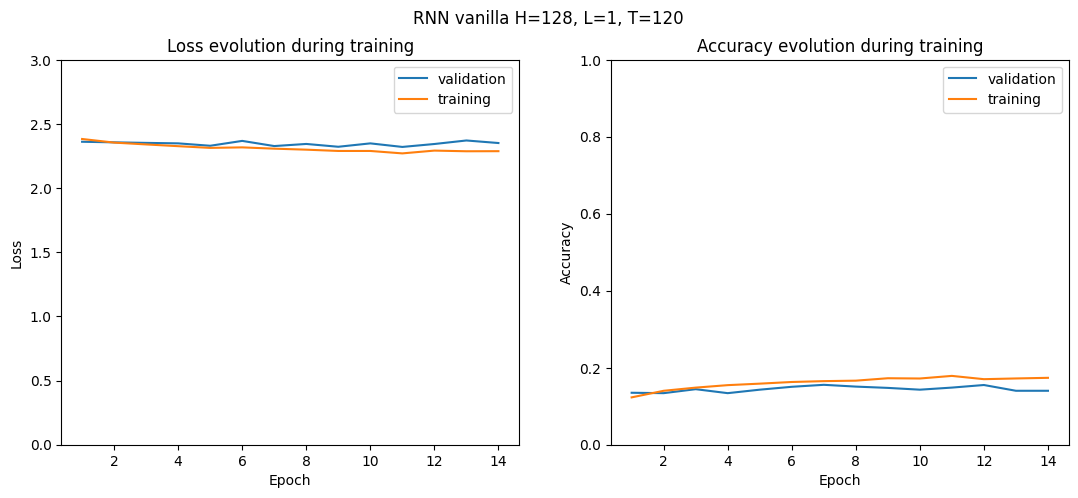

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
train_dl, val_dl, test_dl = load (MFCC_train_10, MFCC_val_10, MFCC_test_10, batch_size=64)

model = RNNVanilla(input_size=39, hidden_size=128, num_layers=1,
                   bidirectional=True,nonlinearity="tanh", num_classes=11)

criterion = nn.CrossEntropyLoss()

curves = train_model(
    model, train_dl, val_dl,
    epochs=20, lr=1e-3, criterion=criterion,
    device=device, early_stopping_patience=7
)

show_curves(curves, title="RNN vanilla H=128, L=1, T=120" , filename="gru_vanilla_B=TRUE.png")

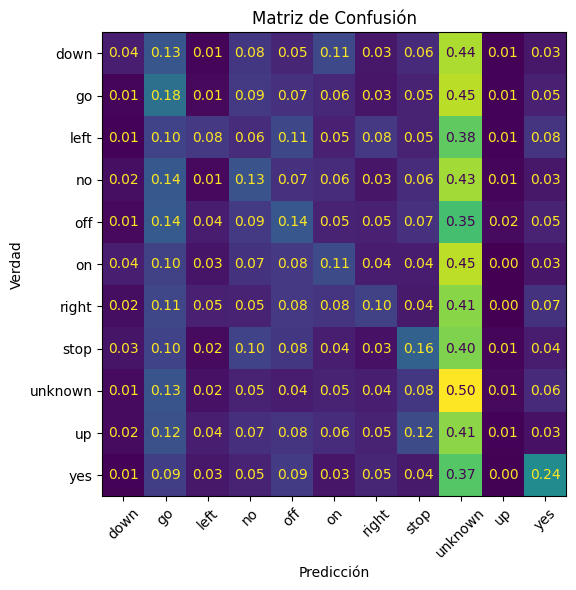

              precision    recall  f1-score   support

        down       0.20      0.04      0.07       396
          go       0.14      0.18      0.16       396
        left       0.24      0.08      0.12       396
          no       0.15      0.13      0.14       396
         off       0.15      0.14      0.14       396
          on       0.16      0.11      0.13       396
       right       0.18      0.10      0.13       396
        stop       0.20      0.16      0.18       396
     unknown       0.11      0.50      0.19       421
          up       0.08      0.01      0.01       396
         yes       0.34      0.24      0.28       396

    accuracy                           0.16      4381
   macro avg       0.18      0.15      0.14      4381
weighted avg       0.18      0.16      0.14      4381

Precisión global (Accuracy): 0.1559


In [ ]:
@torch.no_grad()
def get_predictions(loader, model, device="cpu"):
    """Obtiene las predicciones del modelo y las etiquetas verdaderas."""
    model.eval()
    all_predictions = []
    all_true_labels = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb).argmax(1)

        all_predictions.extend(pred.cpu().numpy())
        all_true_labels.extend(yb.cpu().numpy())
    return all_true_labels, all_predictions

true_labels, predictions = get_predictions(test_dl, model.to(device), device)

show_confusion_matrix(true_labels, predictions, class_names, title="Matriz de Confusión", filename = "RNN_matriz_de_confusión_b=True")

In [ ]:
# Con 100 hop (mayor largo de secuencia)
transform = T.MFCC(sample_rate=sample_rate, n_mfcc=13, melkwargs={"n_fft": 400, "hop_length": 100, "n_mels": 23, "center": False},)
MFCC_train_10 = aplicar_MFCC(transform, train_adaptado)
MFCC_val_10 = aplicar_MFCC(transform, val_adaptado)
MFCC_test_10 = aplicar_MFCC(transform, test_adaptado)

{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
Epoch 1/20
Iteration 84 - Batch 84/508 - Train loss: 2.4123, Train acc: 9.71%
Iteration 168 - Batch 168/508 - Train loss: 2.3993, Train acc: 10.61%
Iteration 252 - Batch 252/508 - Train loss: 2.3919, Train acc: 11.05%
Iteration 336 - Batch 336/508 - Train loss: 2.3865, Train acc: 11.50%
Iteration 420 - Batch 420/508 - Train loss: 2.3826, Train acc: 11.68%
Iteration 504 - Batch 504/508 - Train loss: 2.3790, Train acc: 11.85%
Val loss: 2.3745, Val acc: 11.20%
Epoch 2/20
Iteration 592 - Batch 84/508 - Train loss: 2.3615, Train acc: 13.36%
Iteration 676 - Batch 168/508 - Train loss: 2.3577, Train acc: 13.61%
Iteration 760 - Batch 252/508 - Train

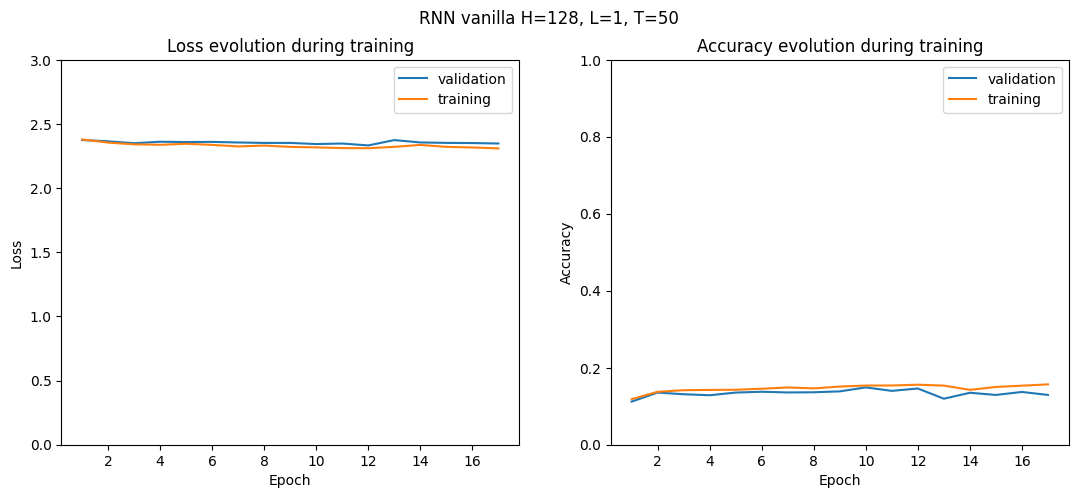

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


train_dl, val_dl, test_dl = load (MFCC_train_10, MFCC_val_10, MFCC_test_10, batch_size=64)

model = RNNVanilla(input_size=39, hidden_size=128, num_layers=1,
                   bidirectional=False,nonlinearity="tanh", num_classes=11)

criterion = nn.CrossEntropyLoss()

curves = train_model(
    model, train_dl, val_dl,
    epochs=20, lr=1e-3, criterion=criterion,
    device=device, early_stopping_patience=7
)

show_curves(curves, title="RNN vanilla H=128, L=1, T=50", filename="rnn_vanilla_relu.png")

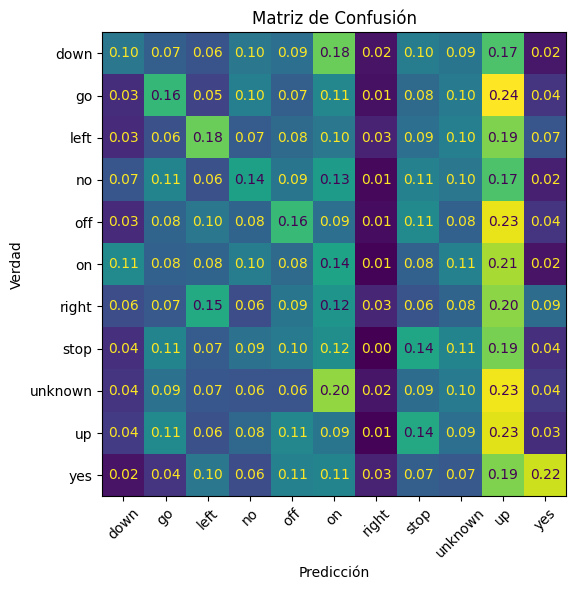

              precision    recall  f1-score   support

        down       0.17      0.10      0.12       396
          go       0.16      0.16      0.16       396
        left       0.19      0.18      0.19       396
          no       0.14      0.14      0.14       396
         off       0.15      0.16      0.16       396
          on       0.10      0.14      0.12       396
       right       0.18      0.03      0.05       396
        stop       0.13      0.14      0.14       396
     unknown       0.10      0.10      0.10       421
          up       0.10      0.23      0.14       396
         yes       0.36      0.22      0.27       396

    accuracy                           0.14      4381
   macro avg       0.16      0.14      0.14      4381
weighted avg       0.16      0.14      0.14      4381

Precisión global (Accuracy): 0.1445


In [ ]:
@torch.no_grad()
def get_predictions(loader, model, device="cpu"):
    """Obtiene las predicciones del modelo y las etiquetas verdaderas."""
    model.eval()
    all_predictions = []
    all_true_labels = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb).argmax(1)

        all_predictions.extend(pred.cpu().numpy())
        all_true_labels.extend(yb.cpu().numpy())
    return all_true_labels, all_predictions

true_labels, predictions = get_predictions(test_dl, model.to(device), device)

show_confusion_matrix(true_labels, predictions, class_names, title="Matriz de Confusión", filename = "matriz_de_confusión_relu")

In [ ]:
transform = T.MFCC(sample_rate=sample_rate, n_mfcc=13, melkwargs={"n_fft": 400, "hop_length": 130, "n_mels": 23, "center": False},)
MFCC_train_10 = aplicar_MFCC(transform, train_adaptado)
MFCC_val_10 = aplicar_MFCC(transform, val_adaptado)
MFCC_test_10 = aplicar_MFCC(transform, test_adaptado)

{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
Epoch 1/20
Iteration 84 - Batch 84/508 - Train loss: 2.4001, Train acc: 10.94%
Iteration 168 - Batch 168/508 - Train loss: 2.3932, Train acc: 11.26%
Iteration 252 - Batch 252/508 - Train loss: 2.3891, Train acc: 11.64%
Iteration 336 - Batch 336/508 - Train loss: 2.3839, Train acc: 11.86%
Iteration 420 - Batch 420/508 - Train loss: 2.3808, Train acc: 11.96%
Iteration 504 - Batch 504/508 - Train loss: 2.3779, Train acc: 12.10%
Val loss: 2.3701, Val acc: 12.36%
Epoch 2/20
Iteration 592 - Batch 84/508 - Train loss: 2.3560, Train acc: 13.36%
Iteration 676 - Batch 168/508 - Train loss: 2.3513, Train acc: 13.51%
Iteration 760 - Batch 252/508 - Trai

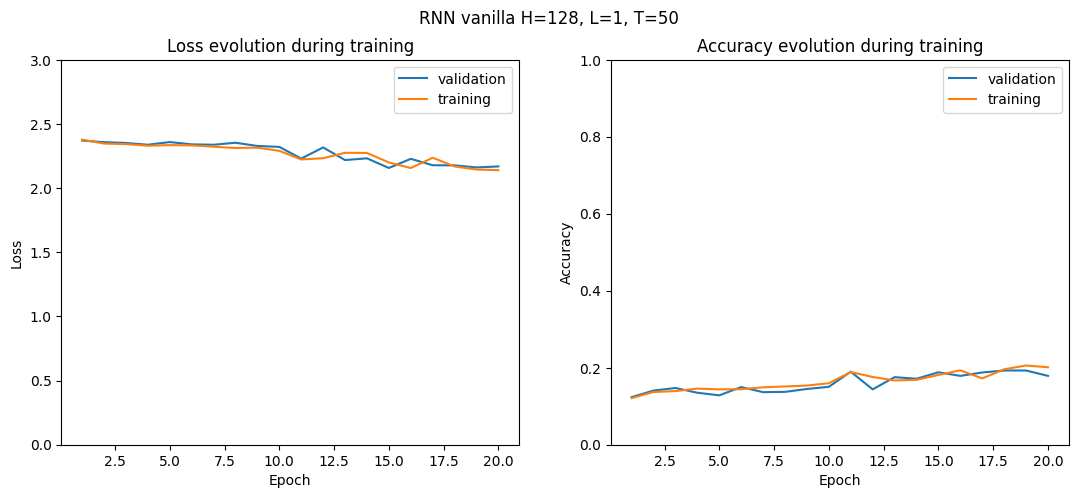

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


train_dl, val_dl, test_dl = load (MFCC_train_10, MFCC_val_10, MFCC_test_10, batch_size=64)

model = RNNVanilla(input_size=39, hidden_size=128, num_layers=1,
                   bidirectional=False,nonlinearity="tanh", num_classes=11)

criterion = nn.CrossEntropyLoss()

curves = train_model(
    model, train_dl, val_dl,
    epochs=20, lr=1e-3, criterion=criterion,
    device=device, early_stopping_patience=7
)

show_curves(curves, title="RNN vanilla H=128, L=1, T=50", filename="rnn_vanilla_relu.png")

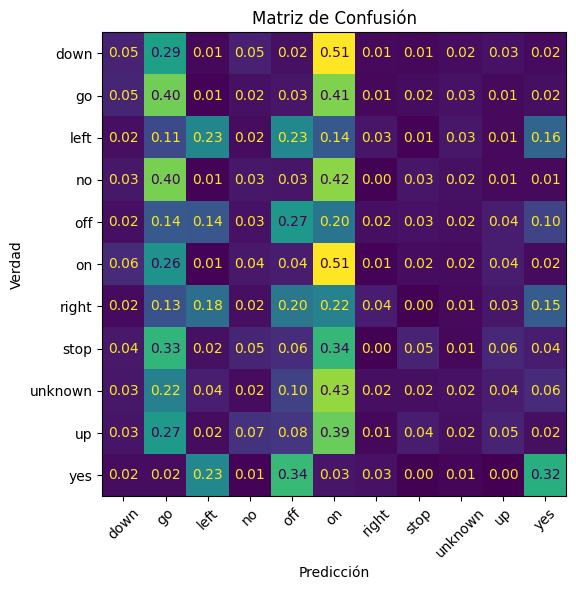

              precision    recall  f1-score   support

        down       0.13      0.05      0.07       396
          go       0.15      0.40      0.22       396
        left       0.26      0.23      0.25       396
          no       0.09      0.03      0.05       396
         off       0.19      0.27      0.22       396
          on       0.14      0.51      0.22       396
       right       0.21      0.04      0.06       396
        stop       0.22      0.05      0.08       396
     unknown       0.12      0.02      0.04       421
          up       0.15      0.05      0.07       396
         yes       0.35      0.32      0.33       396

    accuracy                           0.18      4381
   macro avg       0.18      0.18      0.15      4381
weighted avg       0.18      0.18      0.15      4381

Precisión global (Accuracy): 0.1774


In [ ]:
@torch.no_grad()
def get_predictions(loader, model, device="cpu"):
    """Obtiene las predicciones del modelo y las etiquetas verdaderas."""
    model.eval()
    all_predictions = []
    all_true_labels = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb).argmax(1)

        all_predictions.extend(pred.cpu().numpy())
        all_true_labels.extend(yb.cpu().numpy())
    return all_true_labels, all_predictions

true_labels, predictions = get_predictions(test_dl, model.to(device), device)

show_confusion_matrix(true_labels, predictions, class_names, title="Matriz de Confusión", filename = "matriz_de_confusión_relu")

In [ ]:
# Con 220 hop (mayor largo de secuencia)
transform = T.MFCC(sample_rate=sample_rate, n_mfcc=13, melkwargs={"n_fft": 400, "hop_length": 220, "n_mels": 23, "center": False},)
MFCC_train_10 = aplicar_MFCC(transform, train_adaptado)
MFCC_val_10 = aplicar_MFCC(transform, val_adaptado)
MFCC_test_10 = aplicar_MFCC(transform, test_adaptado)

{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
Epoch 1/20
Iteration 84 - Batch 84/508 - Train loss: 2.4023, Train acc: 10.97%
Iteration 168 - Batch 168/508 - Train loss: 2.3865, Train acc: 11.73%
Iteration 252 - Batch 252/508 - Train loss: 2.3805, Train acc: 12.26%
Iteration 336 - Batch 336/508 - Train loss: 2.3748, Train acc: 12.28%
Iteration 420 - Batch 420/508 - Train loss: 2.3682, Train acc: 12.67%
Iteration 504 - Batch 504/508 - Train loss: 2.3628, Train acc: 12.82%
Val loss: 2.3196, Val acc: 14.76%
Epoch 2/20
Iteration 592 - Batch 84/508 - Train loss: 2.3252, Train acc: 14.93%
Iteration 676 - Batch 168/508 - Train loss: 2.3275, Train acc: 14.67%
Iteration 760 - Batch 252/508 - Trai

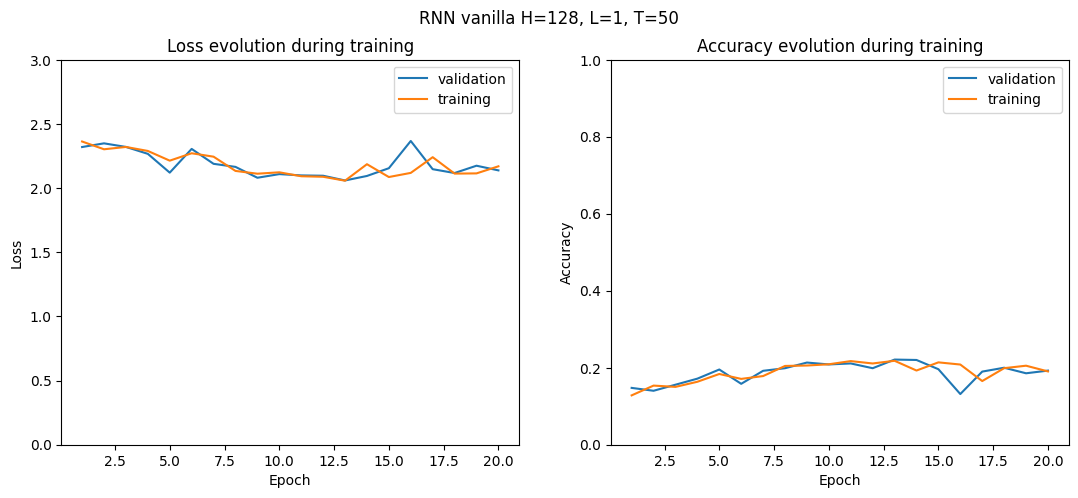

In [ ]:

device = "cuda" if torch.cuda.is_available() else "cpu"


train_dl, val_dl, test_dl = load (MFCC_train_10, MFCC_val_10, MFCC_test_10, batch_size=64)

model = RNNVanilla(input_size=39, hidden_size=128, num_layers=1,
                   bidirectional=False,nonlinearity="tanh", num_classes=11)

criterion = nn.CrossEntropyLoss()

curves = train_model(
    model, train_dl, val_dl,
    epochs=20, lr=1e-3, criterion=criterion,
    device=device, early_stopping_patience=7
)

show_curves(curves, title="RNN vanilla H=128, L=1, T=50", filename="rnn_vanilla_relu.png")


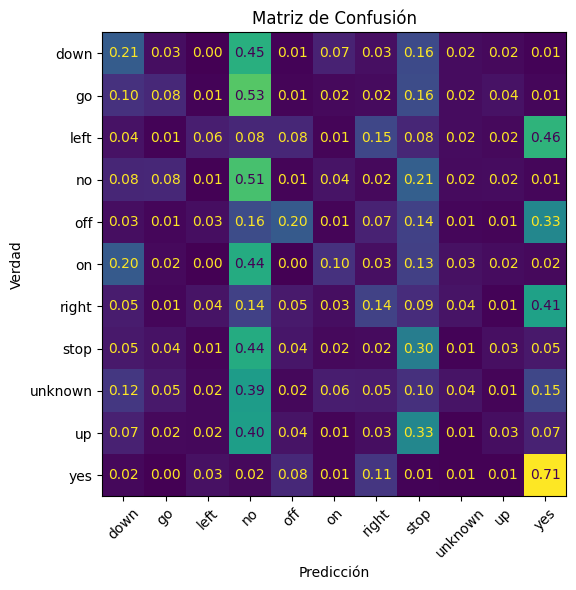

              precision    recall  f1-score   support

        down       0.22      0.21      0.21       396
          go       0.24      0.08      0.12       396
        left       0.28      0.06      0.10       396
          no       0.14      0.51      0.22       396
         off       0.37      0.20      0.26       396
          on       0.27      0.10      0.15       396
       right       0.21      0.14      0.17       396
        stop       0.18      0.30      0.22       396
     unknown       0.18      0.04      0.06       421
          up       0.12      0.03      0.04       396
         yes       0.32      0.71      0.44       396

    accuracy                           0.22      4381
   macro avg       0.23      0.22      0.18      4381
weighted avg       0.23      0.22      0.18      4381

Precisión global (Accuracy): 0.2152


In [ ]:
@torch.no_grad()
def get_predictions(loader, model, device="cpu"):
    """Obtiene las predicciones del modelo y las etiquetas verdaderas."""
    model.eval()
    all_predictions = []
    all_true_labels = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb).argmax(1)

        all_predictions.extend(pred.cpu().numpy())
        all_true_labels.extend(yb.cpu().numpy())
    return all_true_labels, all_predictions

true_labels, predictions = get_predictions(test_dl, model.to(device), device)

show_confusion_matrix(true_labels, predictions, class_names, title="Matriz de Confusión", filename = "matriz_de_confusión_relu")

In [ ]:
# Con 280 hop
transform = T.MFCC(sample_rate=sample_rate, n_mfcc=13, melkwargs={"n_fft": 400, "hop_length": 280, "n_mels": 23, "center": False},)
MFCC_train_10 = aplicar_MFCC(transform, train_adaptado)
MFCC_val_10 = aplicar_MFCC(transform, val_adaptado)
MFCC_test_10 = aplicar_MFCC(transform, test_adaptado)

{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
Epoch 1/20
Iteration 84 - Batch 84/508 - Train loss: 2.4078, Train acc: 10.29%
Iteration 168 - Batch 168/508 - Train loss: 2.3880, Train acc: 11.79%
Iteration 252 - Batch 252/508 - Train loss: 2.3769, Train acc: 12.36%
Iteration 336 - Batch 336/508 - Train loss: 2.3695, Train acc: 12.78%
Iteration 420 - Batch 420/508 - Train loss: 2.3614, Train acc: 13.12%
Iteration 504 - Batch 504/508 - Train loss: 2.3545, Train acc: 13.36%
Val loss: 2.3017, Val acc: 15.10%
Epoch 2/20
Iteration 592 - Batch 84/508 - Train loss: 2.2965, Train acc: 16.05%
Iteration 676 - Batch 168/508 - Train loss: 2.2950, Train acc: 16.12%
Iteration 760 - Batch 252/508 - Trai

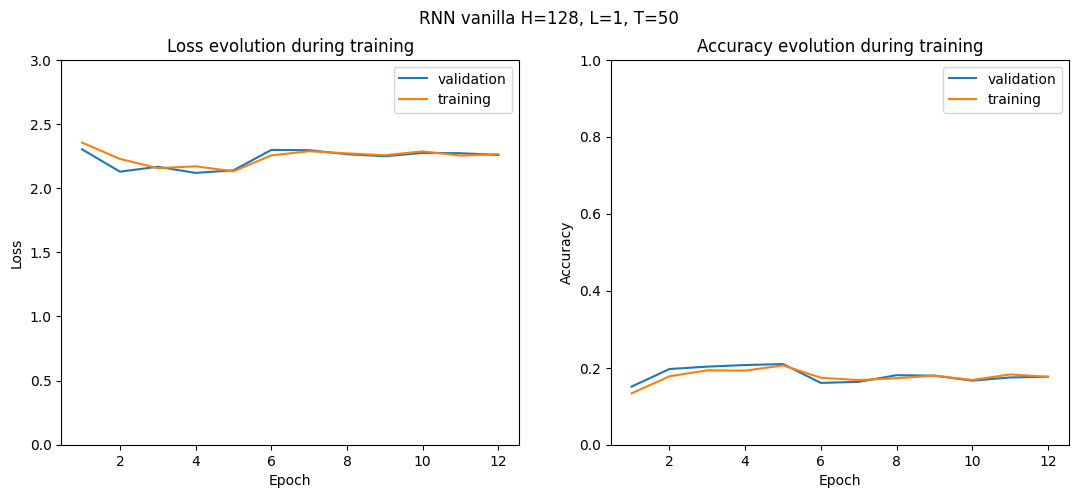

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


train_dl, val_dl, test_dl = load (MFCC_train_10, MFCC_val_10, MFCC_test_10, batch_size=64)

model = RNNVanilla(input_size=39, hidden_size=128, num_layers=1,
                   bidirectional=False,nonlinearity="tanh", num_classes=11)

criterion = nn.CrossEntropyLoss()

curves = train_model(
    model, train_dl, val_dl,
    epochs=20, lr=1e-3, criterion=criterion,
    device=device, early_stopping_patience=7
)

show_curves(curves, title="RNN vanilla H=128, L=1, T=50", filename="rnn_vanilla_relu.png")

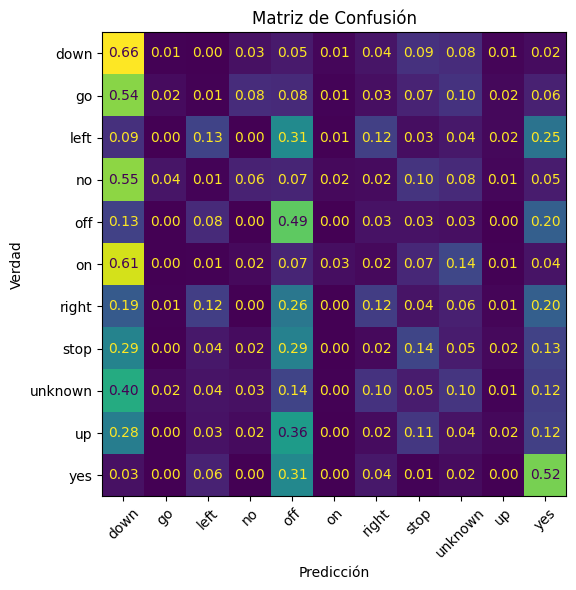

              precision    recall  f1-score   support

        down       0.17      0.66      0.27       396
          go       0.21      0.02      0.04       396
        left       0.25      0.13      0.17       396
          no       0.23      0.06      0.10       396
         off       0.20      0.49      0.29       396
          on       0.31      0.03      0.05       396
       right       0.21      0.12      0.15       396
        stop       0.19      0.14      0.16       396
     unknown       0.15      0.10      0.12       421
          up       0.13      0.02      0.03       396
         yes       0.30      0.52      0.38       396

    accuracy                           0.21      4381
   macro avg       0.21      0.21      0.16      4381
weighted avg       0.21      0.21      0.16      4381

Precisión global (Accuracy): 0.2073


In [ ]:
@torch.no_grad()
def get_predictions(loader, model, device="cpu"):
    """Obtiene las predicciones del modelo y las etiquetas verdaderas."""
    model.eval()
    all_predictions = []
    all_true_labels = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb).argmax(1)

        all_predictions.extend(pred.cpu().numpy())
        all_true_labels.extend(yb.cpu().numpy())
    return all_true_labels, all_predictions

true_labels, predictions = get_predictions(test_dl, model.to(device), device)

show_confusion_matrix(true_labels, predictions, class_names, title="Matriz de Confusión", filename = "matriz_de_confusión_relu")

In [ ]:
# Con 360 hop (mayor largo de secuencia)
transform = T.MFCC(sample_rate=sample_rate, n_mfcc=13, melkwargs={"n_fft": 400, "hop_length": 360, "n_mels": 23, "center": False},)
MFCC_train_10 = aplicar_MFCC(transform, train_adaptado)
MFCC_val_10 = aplicar_MFCC(transform, val_adaptado)
MFCC_test_10 = aplicar_MFCC(transform, test_adaptado)

{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
Epoch 1/20
Iteration 84 - Batch 84/508 - Train loss: 2.4160, Train acc: 10.02%
Iteration 168 - Batch 168/508 - Train loss: 2.3921, Train acc: 12.13%
Iteration 252 - Batch 252/508 - Train loss: 2.3787, Train acc: 12.71%
Iteration 336 - Batch 336/508 - Train loss: 2.3666, Train acc: 13.16%
Iteration 420 - Batch 420/508 - Train loss: 2.3506, Train acc: 13.92%
Iteration 504 - Batch 504/508 - Train loss: 2.3191, Train acc: 14.59%
Val loss: 2.1791, Val acc: 18.12%
Epoch 2/20
Iteration 592 - Batch 84/508 - Train loss: 2.1797, Train acc: 18.93%
Iteration 676 - Batch 168/508 - Train loss: 2.1754, Train acc: 18.74%
Iteration 760 - Batch 252/508 - Trai

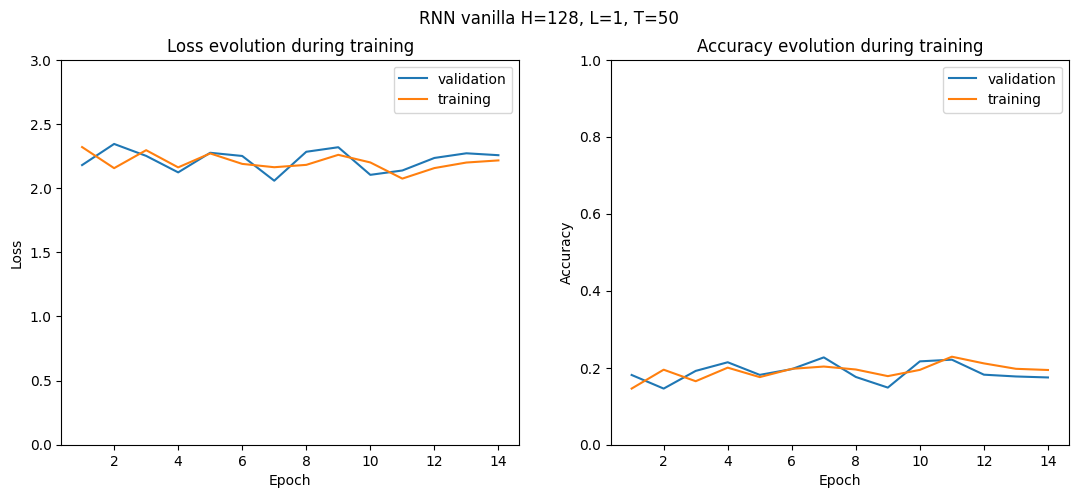

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


train_dl, val_dl, test_dl = load (MFCC_train_10, MFCC_val_10, MFCC_test_10, batch_size=64)

model = RNNVanilla(input_size=39, hidden_size=128, num_layers=1,
                   bidirectional=False,nonlinearity="tanh", num_classes=11)

criterion = nn.CrossEntropyLoss()

curves = train_model(
    model, train_dl, val_dl,
    epochs=20, lr=1e-3, criterion=criterion,
    device=device, early_stopping_patience=7
)

show_curves(curves, title="RNN vanilla H=128, L=1, T=50", filename="rnn_vanilla_relu.png")

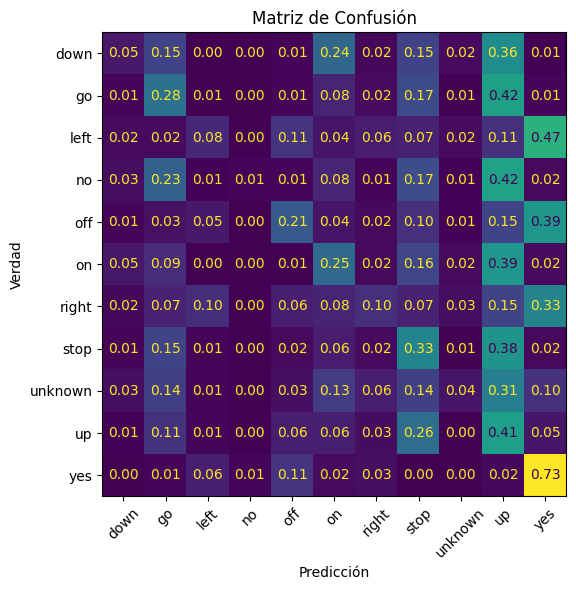

              precision    recall  f1-score   support

        down       0.22      0.05      0.08       396
          go       0.22      0.28      0.24       396
        left       0.24      0.08      0.12       396
          no       0.45      0.01      0.02       396
         off       0.32      0.21      0.25       396
          on       0.23      0.25      0.24       396
       right       0.26      0.10      0.14       396
        stop       0.20      0.33      0.25       396
     unknown       0.28      0.04      0.07       421
          up       0.13      0.41      0.20       396
         yes       0.34      0.73      0.47       396

    accuracy                           0.23      4381
   macro avg       0.26      0.23      0.19      4381
weighted avg       0.26      0.23      0.19      4381

Precisión global (Accuracy): 0.2264


In [ ]:
@torch.no_grad()
def get_predictions(loader, model, device="cpu"):
    """Obtiene las predicciones del modelo y las etiquetas verdaderas."""
    model.eval()
    all_predictions = []
    all_true_labels = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb).argmax(1)

        all_predictions.extend(pred.cpu().numpy())
        all_true_labels.extend(yb.cpu().numpy())
    return all_true_labels, all_predictions

true_labels, predictions = get_predictions(test_dl, model.to(device), device)

show_confusion_matrix(true_labels, predictions, class_names, title="Matriz de Confusión", filename = "matriz_de_confusión_relu")

### Modelo gru

#### Variación número de neuronas por capa

In [ ]:
transform = T.MFCC(sample_rate=sample_rate, n_mfcc=13, melkwargs={"n_fft": 400, "hop_length": 160, "n_mels": 23, "center": False},)
MFCC_train_10 = aplicar_MFCC(transform, train_adaptado)
MFCC_val_10 = aplicar_MFCC(transform, val_adaptado)
MFCC_test_10 = aplicar_MFCC(transform, test_adaptado)

{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
Epoch 1/20
Iteration 84 - Batch 84/508 - Train loss: 1.9676, Train acc: 37.83%
Iteration 168 - Batch 168/508 - Train loss: 1.6292, Train acc: 49.93%
Iteration 252 - Batch 252/508 - Train loss: 1.3813, Train acc: 58.03%
Iteration 336 - Batch 336/508 - Train loss: 1.2042, Train acc: 63.62%
Iteration 420 - Batch 420/508 - Train loss: 1.0691, Train acc: 67.79%
Iteration 504 - Batch 504/508 - Train loss: 0.9648, Train acc: 70.93%
Val loss: 0.4366, Val acc: 86.43%
Epoch 2/20
Iteration 592 - Batch 84/508 - Train loss: 0.3735, Train acc: 88.62%
Iteration 676 - Batch 168/508 - Train loss: 0.3608, Train acc: 88.97%
Iteration 760 - Batch 252/508 - Trai

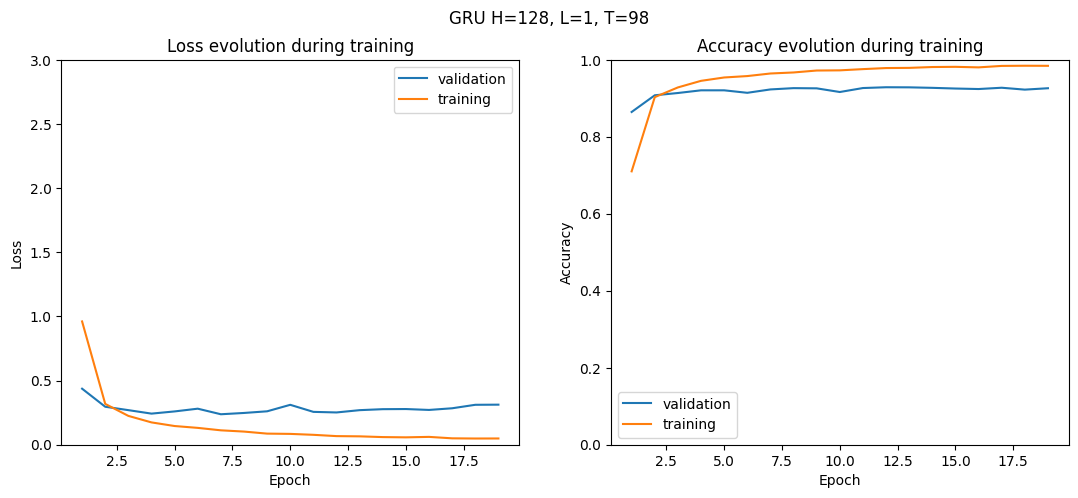

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


train_dl, val_dl, test_dl = load (MFCC_train_10, MFCC_val_10, MFCC_test_10, batch_size=64)

model = GRUModel(input_size=39, hidden_size=128, num_layers=1,
                   bidirectional=False, num_classes=11)

criterion = nn.CrossEntropyLoss()

curves = train_model(
    model, train_dl, val_dl,
    epochs=20, lr=1e-3, criterion=criterion,
    device=device, early_stopping_patience=7
)

show_curves(curves, title="GRU H=128, L=1, T=98", filename="gru_h=128.png")

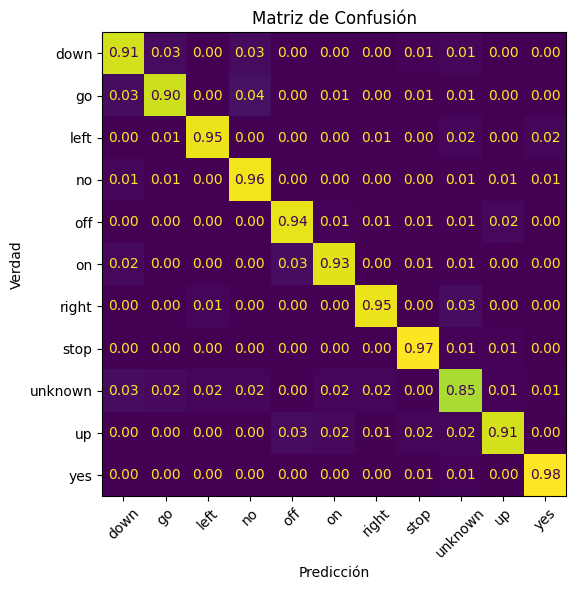

              precision    recall  f1-score   support

        down       0.90      0.91      0.90       396
          go       0.92      0.90      0.91       396
        left       0.96      0.95      0.95       396
          no       0.91      0.96      0.93       396
         off       0.93      0.94      0.94       396
          on       0.94      0.93      0.93       396
       right       0.95      0.95      0.95       396
        stop       0.94      0.97      0.96       396
     unknown       0.88      0.85      0.87       421
          up       0.95      0.91      0.93       396
         yes       0.97      0.98      0.97       396

    accuracy                           0.93      4381
   macro avg       0.93      0.93      0.93      4381
weighted avg       0.93      0.93      0.93      4381

Precisión global (Accuracy): 0.9311


In [ ]:
@torch.no_grad()
def get_predictions(loader, model, device="cpu"):
    """Obtiene las predicciones del modelo y las etiquetas verdaderas."""
    model.eval()
    all_predictions = []
    all_true_labels = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb).argmax(1)

        all_predictions.extend(pred.cpu().numpy())
        all_true_labels.extend(yb.cpu().numpy())
    return all_true_labels, all_predictions

true_labels, predictions = get_predictions(test_dl, model.to(device), device)

show_confusion_matrix(true_labels, predictions, class_names, title="Matriz de Confusión", filename = "matrizg_de_confusión_h=128")

{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
Epoch 1/20
Iteration 84 - Batch 84/508 - Train loss: 1.7318, Train acc: 44.17%
Iteration 168 - Batch 168/508 - Train loss: 1.3040, Train acc: 59.06%
Iteration 252 - Batch 252/508 - Train loss: 1.0480, Train acc: 67.29%
Iteration 336 - Batch 336/508 - Train loss: 0.8897, Train acc: 72.35%
Iteration 420 - Batch 420/508 - Train loss: 0.7845, Train acc: 75.52%
Iteration 504 - Batch 504/508 - Train loss: 0.7069, Train acc: 77.86%
Val loss: 0.2942, Val acc: 90.48%
Epoch 2/20
Iteration 592 - Batch 84/508 - Train loss: 0.2588, Train acc: 91.95%
Iteration 676 - Batch 168/508 - Train loss: 0.2406, Train acc: 92.49%
Iteration 760 - Batch 252/508 - Trai

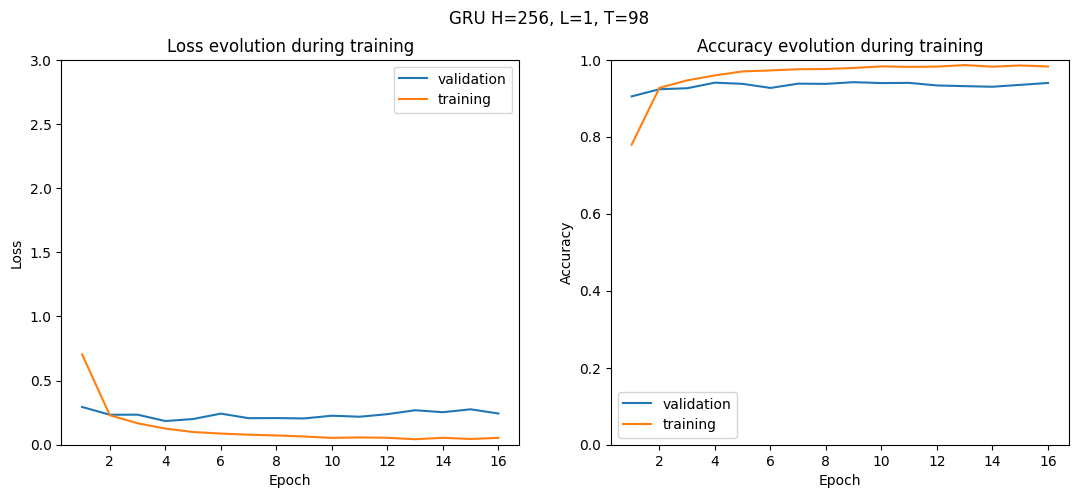

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


train_dl, val_dl, test_dl = load (MFCC_train_10, MFCC_val_10, MFCC_test_10, batch_size=64)

model = GRUModel(input_size=39, hidden_size=256, num_layers=1,
                   bidirectional=False, num_classes=11)

criterion = nn.CrossEntropyLoss()

curves = train_model(
    model, train_dl, val_dl,
    epochs=20, lr=1e-3, criterion=criterion,
    device=device, early_stopping_patience=7
)

show_curves(curves, title="GRU H=256, L=1, T=98", filename="gru_h=256.png")

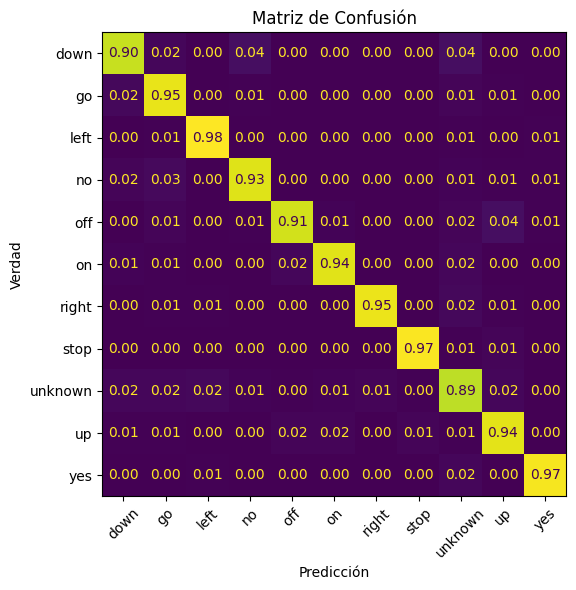

              precision    recall  f1-score   support

        down       0.92      0.90      0.91       396
          go       0.91      0.95      0.93       396
        left       0.96      0.98      0.97       396
          no       0.94      0.93      0.94       396
         off       0.96      0.91      0.94       396
          on       0.96      0.94      0.95       396
       right       0.99      0.95      0.97       396
        stop       0.97      0.97      0.97       396
     unknown       0.87      0.89      0.88       421
          up       0.91      0.94      0.93       396
         yes       0.98      0.97      0.97       396

    accuracy                           0.94      4381
   macro avg       0.94      0.94      0.94      4381
weighted avg       0.94      0.94      0.94      4381

Precisión global (Accuracy): 0.9404


In [ ]:
@torch.no_grad()
def get_predictions(loader, model, device="cpu"):
    """Obtiene las predicciones del modelo y las etiquetas verdaderas."""
    model.eval()
    all_predictions = []
    all_true_labels = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb).argmax(1)

        all_predictions.extend(pred.cpu().numpy())
        all_true_labels.extend(yb.cpu().numpy())
    return all_true_labels, all_predictions

true_labels, predictions = get_predictions(test_dl, model.to(device), device)

show_confusion_matrix(true_labels, predictions, class_names, title="Matriz de Confusión", filename = "matrizg_de_confusión_h=256")

{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
Epoch 1/20
Iteration 84 - Batch 84/508 - Train loss: 2.2889, Train acc: 21.07%
Iteration 168 - Batch 168/508 - Train loss: 2.0984, Train acc: 29.38%
Iteration 252 - Batch 252/508 - Train loss: 1.9194, Train acc: 37.25%
Iteration 336 - Batch 336/508 - Train loss: 1.7652, Train acc: 43.59%
Iteration 420 - Batch 420/508 - Train loss: 1.6286, Train acc: 48.98%
Iteration 504 - Batch 504/508 - Train loss: 1.5104, Train acc: 53.24%
Val loss: 0.8368, Val acc: 77.06%
Epoch 2/20
Iteration 592 - Batch 84/508 - Train loss: 0.7860, Train acc: 78.22%
Iteration 676 - Batch 168/508 - Train loss: 0.7351, Train acc: 79.42%
Iteration 760 - Batch 252/508 - Trai

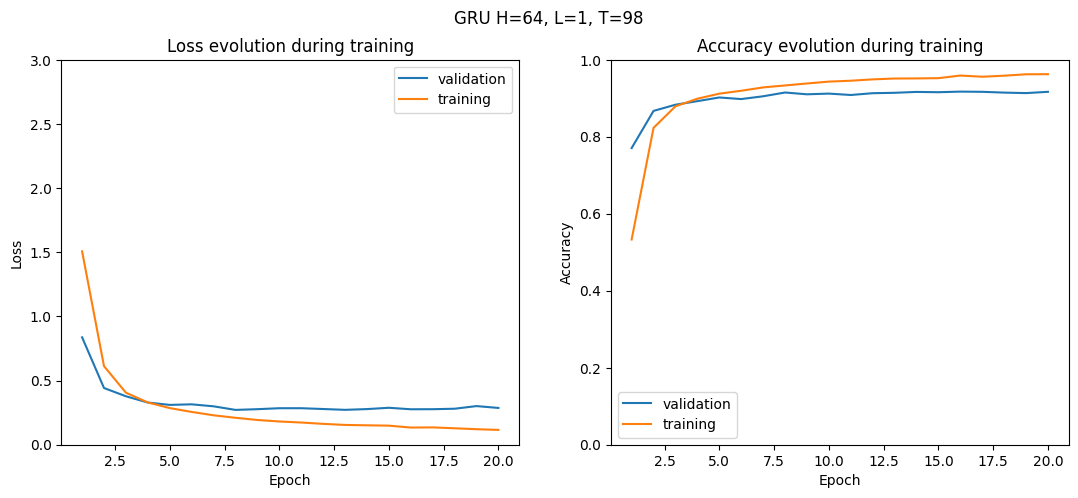

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


train_dl, val_dl, test_dl = load (MFCC_train_10, MFCC_val_10, MFCC_test_10, batch_size=64)

model = GRUModel(input_size=39, hidden_size=64, num_layers=1,
                   bidirectional=False, num_classes=11)

criterion = nn.CrossEntropyLoss()

curves = train_model(
    model, train_dl, val_dl,
    epochs=20, lr=1e-3, criterion=criterion,
    device=device, early_stopping_patience=7
)

show_curves(curves, title="GRU H=64, L=1, T=98", filename="gru_h=64.png")

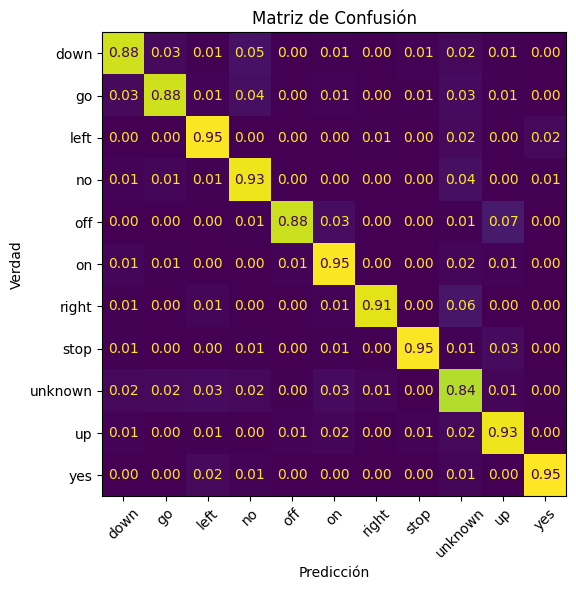

              precision    recall  f1-score   support

        down       0.90      0.88      0.89       396
          go       0.92      0.88      0.90       396
        left       0.91      0.95      0.93       396
          no       0.88      0.93      0.90       396
         off       0.97      0.88      0.92       396
          on       0.90      0.95      0.92       396
       right       0.97      0.91      0.94       396
        stop       0.97      0.95      0.96       396
     unknown       0.80      0.84      0.82       421
          up       0.87      0.93      0.90       396
         yes       0.97      0.95      0.96       396

    accuracy                           0.91      4381
   macro avg       0.92      0.91      0.91      4381
weighted avg       0.91      0.91      0.91      4381

Precisión global (Accuracy): 0.9128


In [ ]:
@torch.no_grad()
def get_predictions(loader, model, device="cpu"):
    """Obtiene las predicciones del modelo y las etiquetas verdaderas."""
    model.eval()
    all_predictions = []
    all_true_labels = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb).argmax(1)

        all_predictions.extend(pred.cpu().numpy())
        all_true_labels.extend(yb.cpu().numpy())
    return all_true_labels, all_predictions

true_labels, predictions = get_predictions(test_dl, model.to(device), device)

show_confusion_matrix(true_labels, predictions, class_names, title="Matriz de Confusión", filename = "matrizg_de_confusión_h=64")

#### Variación número de capas

{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
Epoch 1/20
Iteration 84 - Batch 84/508 - Train loss: 1.7392, Train acc: 39.60%
Iteration 168 - Batch 168/508 - Train loss: 1.2941, Train acc: 56.39%
Iteration 252 - Batch 252/508 - Train loss: 1.0613, Train acc: 64.77%
Iteration 336 - Batch 336/508 - Train loss: 0.9212, Train acc: 69.66%
Iteration 420 - Batch 420/508 - Train loss: 0.8182, Train acc: 73.11%
Iteration 504 - Batch 504/508 - Train loss: 0.7454, Train acc: 75.52%
Val loss: 0.3965, Val acc: 86.61%
Epoch 2/20
Iteration 592 - Batch 84/508 - Train loss: 0.3120, Train acc: 90.15%
Iteration 676 - Batch 168/508 - Train loss: 0.3033, Train acc: 90.30%
Iteration 760 - Batch 252/508 - Trai

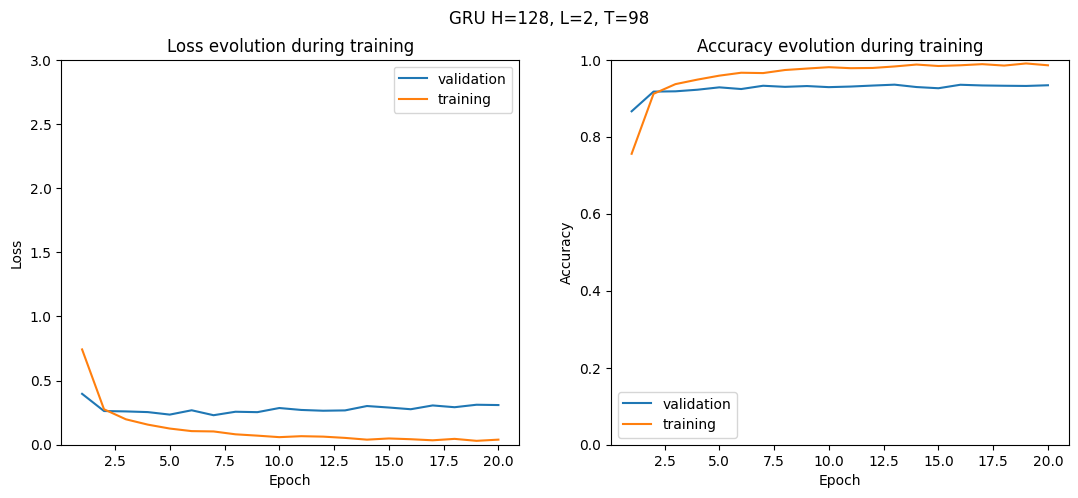

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


train_dl, val_dl, test_dl = load (MFCC_train_10, MFCC_val_10, MFCC_test_10, batch_size=64)

model = GRUModel(input_size=39, hidden_size=128, num_layers=2,
                   bidirectional=False, num_classes=11)

criterion = nn.CrossEntropyLoss()

curves = train_model(
    model, train_dl, val_dl,
    epochs=20, lr=1e-3, criterion=criterion,
    device=device, early_stopping_patience=7
)

show_curves(curves, title="GRU H=128, L=2, T=98", filename="gru_L=2.png")

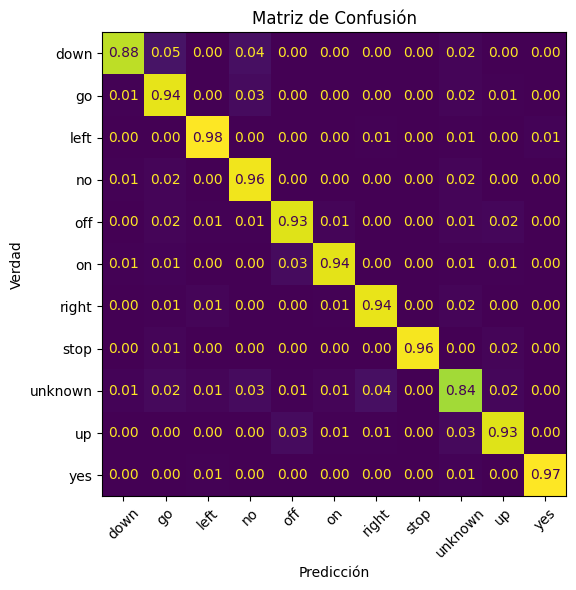

              precision    recall  f1-score   support

        down       0.96      0.88      0.92       396
          go       0.87      0.94      0.90       396
        left       0.95      0.98      0.97       396
          no       0.89      0.96      0.92       396
         off       0.93      0.93      0.93       396
          on       0.96      0.94      0.95       396
       right       0.94      0.94      0.94       396
        stop       0.99      0.96      0.98       396
     unknown       0.88      0.84      0.86       421
          up       0.92      0.93      0.93       396
         yes       0.98      0.97      0.98       396

    accuracy                           0.93      4381
   macro avg       0.94      0.93      0.93      4381
weighted avg       0.93      0.93      0.93      4381

Precisión global (Accuracy): 0.9338


In [ ]:
@torch.no_grad()
def get_predictions(loader, model, device="cpu"):
    """Obtiene las predicciones del modelo y las etiquetas verdaderas."""
    model.eval()
    all_predictions = []
    all_true_labels = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb).argmax(1)

        all_predictions.extend(pred.cpu().numpy())
        all_true_labels.extend(yb.cpu().numpy())
    return all_true_labels, all_predictions

true_labels, predictions = get_predictions(test_dl, model.to(device), device)

show_confusion_matrix(true_labels, predictions, class_names, title="Matriz de Confusión", filename = "matrizg_de_confusión_L=2")

{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
Epoch 1/20
Iteration 84 - Batch 84/508 - Train loss: 1.2852, Train acc: 58.42%
Iteration 168 - Batch 168/508 - Train loss: 0.9658, Train acc: 68.76%
Iteration 252 - Batch 252/508 - Train loss: 0.8152, Train acc: 73.57%
Iteration 336 - Batch 336/508 - Train loss: 0.7168, Train acc: 76.78%
Iteration 420 - Batch 420/508 - Train loss: 0.6494, Train acc: 78.96%
Iteration 504 - Batch 504/508 - Train loss: 0.5943, Train acc: 80.81%
Val loss: 0.2948, Val acc: 90.25%
Epoch 2/20
Iteration 592 - Batch 84/508 - Train loss: 0.2335, Train acc: 92.35%
Iteration 676 - Batch 168/508 - Train loss: 0.2383, Train acc: 92.34%
Iteration 760 - Batch 252/508 - Trai

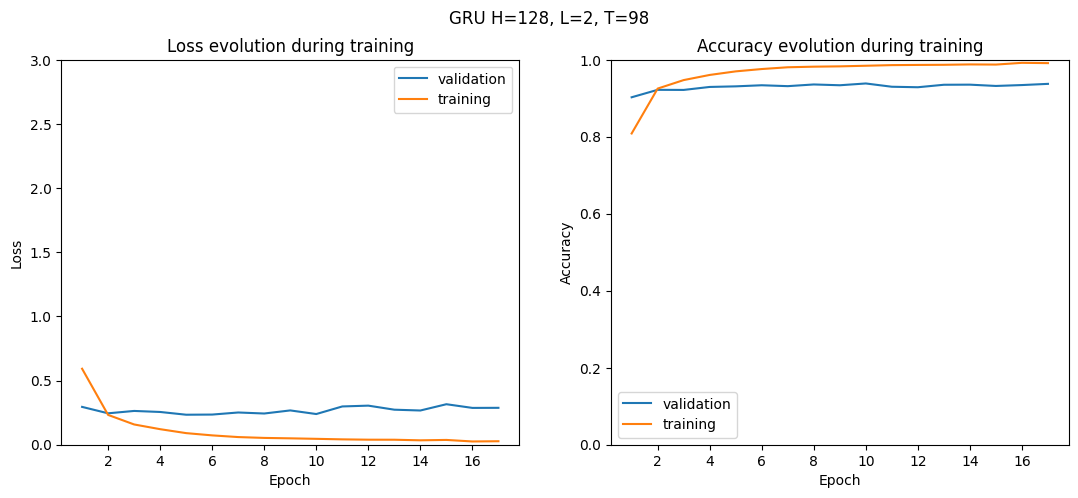

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


train_dl, val_dl, test_dl = load (MFCC_train_10, MFCC_val_10, MFCC_test_10, batch_size=64)

model = GRUModel(input_size=39, hidden_size=128, num_layers=3,
                   bidirectional=True, num_classes=11)

criterion = nn.CrossEntropyLoss()

curves = train_model(
    model, train_dl, val_dl,
    epochs=20, lr=1e-3, criterion=criterion,
    device=device, early_stopping_patience=7
)

show_curves(curves, title="GRU H=128, L=2, T=98", filename="gru_L=2.png")

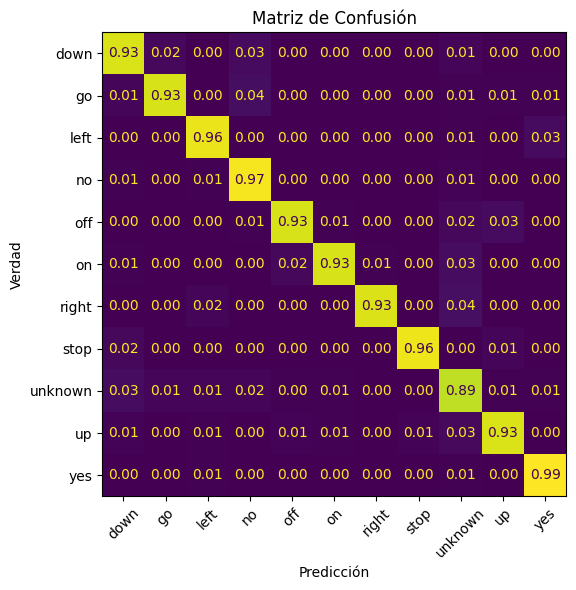

              precision    recall  f1-score   support

        down       0.90      0.93      0.92       396
          go       0.95      0.93      0.94       396
        left       0.95      0.96      0.96       396
          no       0.91      0.97      0.94       396
         off       0.96      0.93      0.94       396
          on       0.98      0.93      0.95       396
       right       0.99      0.93      0.96       396
        stop       0.98      0.96      0.97       396
     unknown       0.85      0.89      0.87       421
          up       0.94      0.93      0.94       396
         yes       0.96      0.99      0.97       396

    accuracy                           0.94      4381
   macro avg       0.94      0.94      0.94      4381
weighted avg       0.94      0.94      0.94      4381

Precisión global (Accuracy): 0.9413


In [ ]:
@torch.no_grad()
def get_predictions(loader, model, device="cpu"):
    """Obtiene las predicciones del modelo y las etiquetas verdaderas."""
    model.eval()
    all_predictions = []
    all_true_labels = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb).argmax(1)

        all_predictions.extend(pred.cpu().numpy())
        all_true_labels.extend(yb.cpu().numpy())
    return all_true_labels, all_predictions

true_labels, predictions = get_predictions(test_dl, model.to(device), device)

show_confusion_matrix(true_labels, predictions, class_names, title="Matriz de Confusión", filename = "matrizg_de_confusión_tr=2")

#### Mejor modelo

{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
Epoch 1/20
Iteration 84 - Batch 84/508 - Train loss: 1.1442, Train acc: 61.91%
Iteration 168 - Batch 168/508 - Train loss: 0.8513, Train acc: 71.95%
Iteration 252 - Batch 252/508 - Train loss: 0.7058, Train acc: 76.96%
Iteration 336 - Batch 336/508 - Train loss: 0.6223, Train acc: 79.68%
Iteration 420 - Batch 420/508 - Train loss: 0.5578, Train acc: 81.73%
Iteration 504 - Batch 504/508 - Train loss: 0.5109, Train acc: 83.34%
Val loss: 0.2773, Val acc: 91.41%
Epoch 2/20
Iteration 592 - Batch 84/508 - Train loss: 0.2058, Train acc: 93.42%
Iteration 676 - Batch 168/508 - Train loss: 0.2234, Train acc: 92.81%
Iteration 760 - Batch 252/508 - Trai

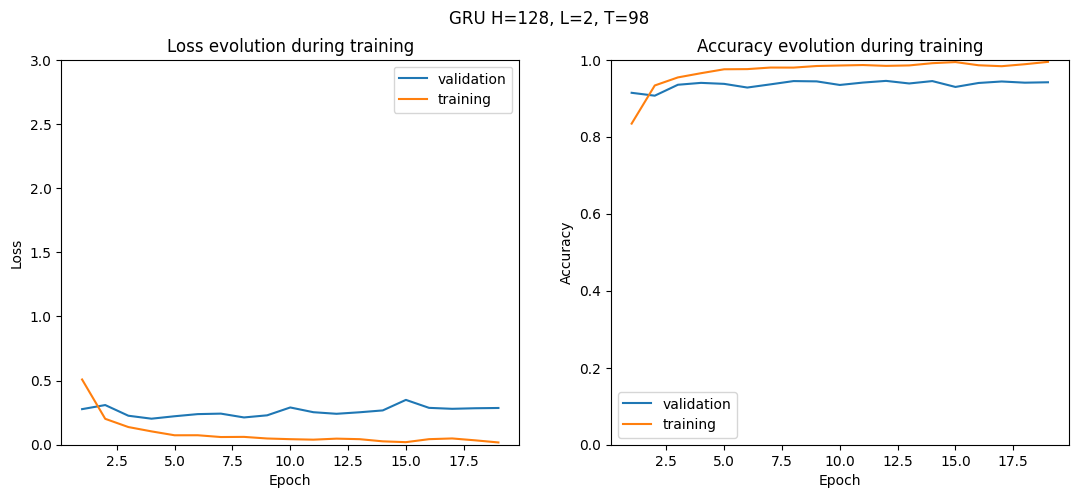

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


train_dl, val_dl, test_dl = load (MFCC_train_10, MFCC_val_10, MFCC_test_10, batch_size=64)

model = GRUModel(input_size=39, hidden_size=256, num_layers=3,
                   bidirectional=True, num_classes=11)

criterion = nn.CrossEntropyLoss()

curves = train_model(
    model, train_dl, val_dl,
    epochs=20, lr=1e-3, criterion=criterion,
    device=device, early_stopping_patience=7
)

show_curves(curves, title="GRU H=128, L=2, T=98", filename="gru_L=2.png")

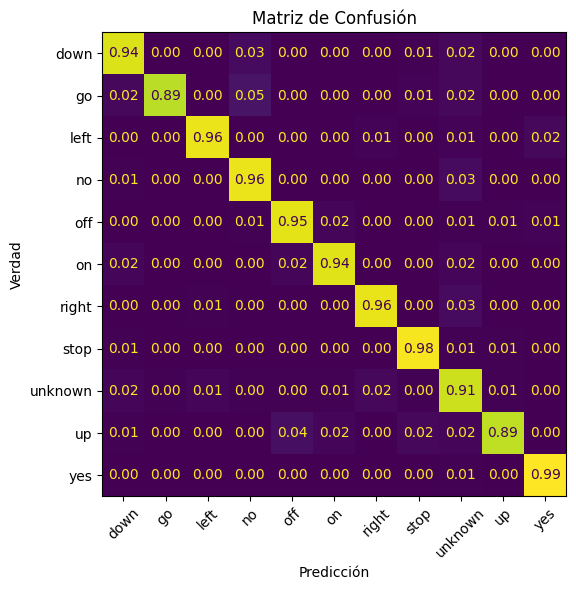

              precision    recall  f1-score   support

        down       0.92      0.94      0.93       396
          go       0.98      0.89      0.93       396
        left       0.97      0.96      0.96       396
          no       0.91      0.96      0.93       396
         off       0.94      0.95      0.94       396
          on       0.96      0.94      0.95       396
       right       0.96      0.96      0.96       396
        stop       0.95      0.98      0.96       396
     unknown       0.86      0.91      0.89       421
          up       0.98      0.89      0.93       396
         yes       0.96      0.99      0.98       396

    accuracy                           0.94      4381
   macro avg       0.94      0.94      0.94      4381
weighted avg       0.94      0.94      0.94      4381

Precisión global (Accuracy): 0.9425


In [ ]:
@torch.no_grad()
def get_predictions(loader, model, device="cpu"):
    """Obtiene las predicciones del modelo y las etiquetas verdaderas."""
    model.eval()
    all_predictions = []
    all_true_labels = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb).argmax(1)

        all_predictions.extend(pred.cpu().numpy())
        all_true_labels.extend(yb.cpu().numpy())
    return all_true_labels, all_predictions

true_labels, predictions = get_predictions(test_dl, model.to(device), device)

show_confusion_matrix(true_labels, predictions, class_names, title="Matriz de Confusión", filename = "matrizg_de_confusión_tr=2")


#### Variación largo de secuencia

In [ ]:
transform = T.MFCC(sample_rate=sample_rate, n_mfcc=13, melkwargs={"n_fft": 400, "hop_length": 50, "n_mels": 23, "center": False},)
MFCC_train_10 = aplicar_MFCC(transform, train_adaptado)
MFCC_val_10 = aplicar_MFCC(transform, val_adaptado)
MFCC_test_10 = aplicar_MFCC(transform, test_adaptado)

{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
Epoch 1/20
Iteration 84 - Batch 84/508 - Train loss: 1.8397, Train acc: 43.75%
Iteration 168 - Batch 168/508 - Train loss: 1.4230, Train acc: 57.92%
Iteration 252 - Batch 252/508 - Train loss: 1.1879, Train acc: 64.93%
Iteration 336 - Batch 336/508 - Train loss: 1.0407, Train acc: 69.07%
Iteration 420 - Batch 420/508 - Train loss: 0.9406, Train acc: 71.85%
Iteration 504 - Batch 504/508 - Train loss: 0.8624, Train acc: 74.07%
Val loss: 0.4217, Val acc: 86.89%
Epoch 2/20
Iteration 592 - Batch 84/508 - Train loss: 0.3705, Train acc: 88.86%
Iteration 676 - Batch 168/508 - Train loss: 0.3668, Train acc: 88.82%
Iteration 760 - Batch 252/508 - Trai

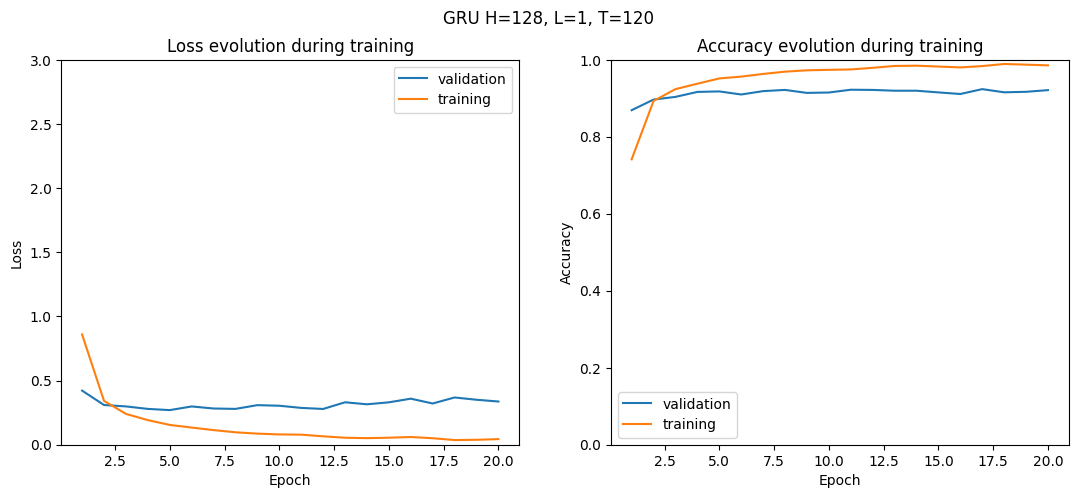

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


train_dl, val_dl, test_dl = load (MFCC_train_10, MFCC_val_10, MFCC_test_10, batch_size=64)

model = GRUModel(input_size=39, hidden_size=128, num_layers=1,
                   bidirectional=True, num_classes=11)

criterion = nn.CrossEntropyLoss()

curves = train_model(
    model, train_dl, val_dl,
    epochs=20, lr=1e-3, criterion=criterion,
    device=device, early_stopping_patience=7
)

show_curves(curves, title="GRU H=128, L=1, T=120", filename="gru_L=2.png")

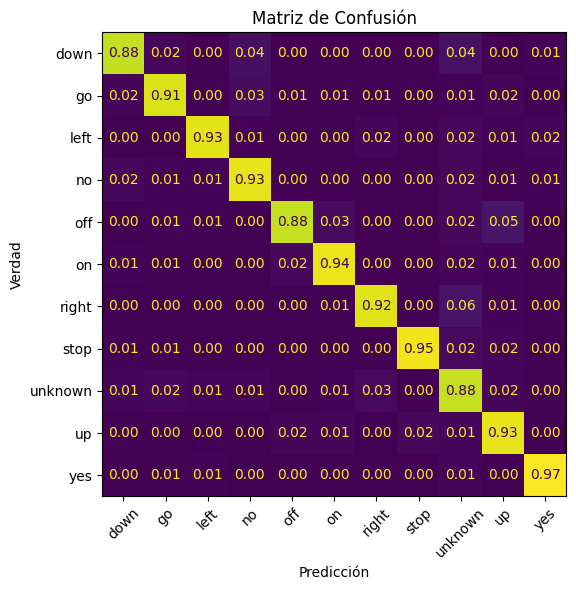

              precision    recall  f1-score   support

        down       0.92      0.88      0.90       396
          go       0.93      0.91      0.92       396
        left       0.95      0.93      0.94       396
          no       0.91      0.93      0.92       396
         off       0.95      0.88      0.91       396
          on       0.94      0.94      0.94       396
       right       0.95      0.92      0.93       396
        stop       0.97      0.95      0.96       396
     unknown       0.80      0.88      0.84       421
          up       0.87      0.93      0.90       396
         yes       0.96      0.97      0.96       396

    accuracy                           0.92      4381
   macro avg       0.92      0.92      0.92      4381
weighted avg       0.92      0.92      0.92      4381

Precisión global (Accuracy): 0.9199


In [ ]:
@torch.no_grad()
def get_predictions(loader, model, device="cpu"):
    """Obtiene las predicciones del modelo y las etiquetas verdaderas."""
    model.eval()
    all_predictions = []
    all_true_labels = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb).argmax(1)

        all_predictions.extend(pred.cpu().numpy())
        all_true_labels.extend(yb.cpu().numpy())
    return all_true_labels, all_predictions

true_labels, predictions = get_predictions(test_dl, model.to(device), device)

show_confusion_matrix(true_labels, predictions, class_names, title="Matriz de Confusión", filename = "matrizg_de_confusión_tr=2")

In [ ]:
# Con 75 hop (mayor largo de secuencia)
transform = T.MFCC(sample_rate=sample_rate, n_mfcc=13, melkwargs={"n_fft": 400, "hop_length": 75, "n_mels": 23, "center": False},)
MFCC_train_10 = aplicar_MFCC(transform, train_adaptado)
MFCC_val_10 = aplicar_MFCC(transform, val_adaptado)
MFCC_test_10 = aplicar_MFCC(transform, test_adaptado)

{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
Epoch 1/20
Iteration 84 - Batch 84/508 - Train loss: 1.7141, Train acc: 49.15%
Iteration 168 - Batch 168/508 - Train loss: 1.3132, Train acc: 62.13%
Iteration 252 - Batch 252/508 - Train loss: 1.1066, Train acc: 67.86%
Iteration 336 - Batch 336/508 - Train loss: 0.9706, Train acc: 71.74%
Iteration 420 - Batch 420/508 - Train loss: 0.8772, Train acc: 74.31%
Iteration 504 - Batch 504/508 - Train loss: 0.8044, Train acc: 76.35%
Val loss: 0.3822, Val acc: 88.34%
Epoch 2/20
Iteration 592 - Batch 84/508 - Train loss: 0.3637, Train acc: 88.69%
Iteration 676 - Batch 168/508 - Train loss: 0.3561, Train acc: 88.89%
Iteration 760 - Batch 252/508 - Trai

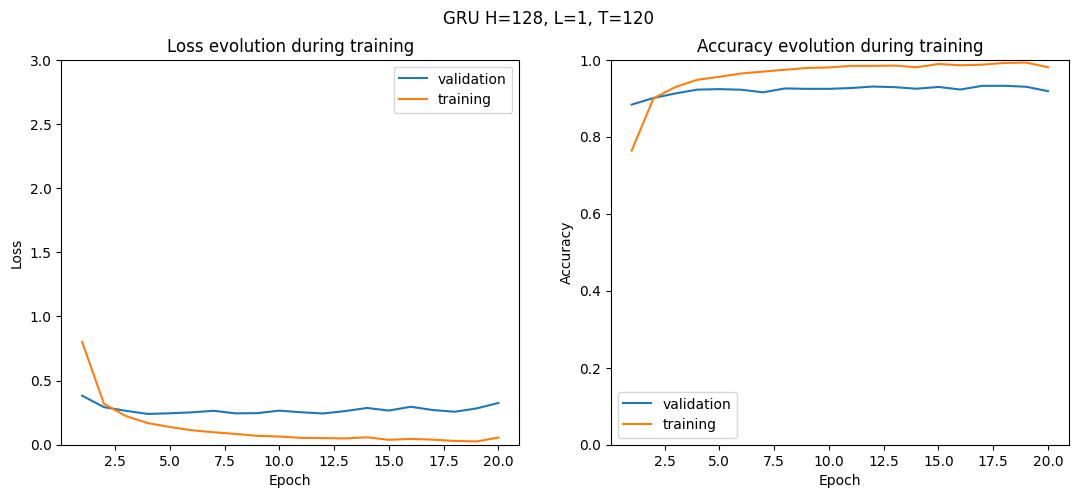

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


train_dl, val_dl, test_dl = load (MFCC_train_10, MFCC_val_10, MFCC_test_10, batch_size=64)

model = GRUModel(input_size=39, hidden_size=128, num_layers=1,
                   bidirectional=True, num_classes=11)

criterion = nn.CrossEntropyLoss()

curves = train_model(
    model, train_dl, val_dl,
    epochs=20, lr=1e-3, criterion=criterion,
    device=device, early_stopping_patience=7
)

show_curves(curves, title="GRU H=128, L=1, T=120", filename="gru_L=2.png")

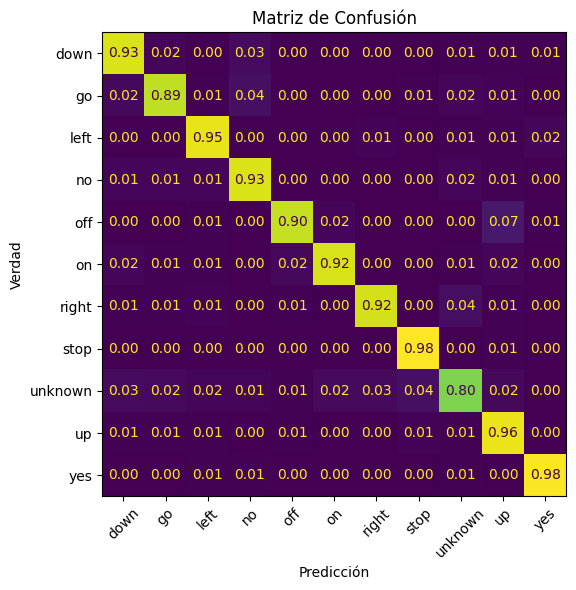

              precision    recall  f1-score   support

        down       0.90      0.93      0.92       396
          go       0.92      0.89      0.91       396
        left       0.92      0.95      0.94       396
          no       0.91      0.93      0.92       396
         off       0.95      0.90      0.92       396
          on       0.95      0.92      0.94       396
       right       0.96      0.92      0.94       396
        stop       0.93      0.98      0.96       396
     unknown       0.88      0.80      0.84       421
          up       0.87      0.96      0.91       396
         yes       0.97      0.98      0.97       396

    accuracy                           0.92      4381
   macro avg       0.92      0.92      0.92      4381
weighted avg       0.92      0.92      0.92      4381

Precisión global (Accuracy): 0.9231


In [ ]:
@torch.no_grad()
def get_predictions(loader, model, device="cpu"):
    """Obtiene las predicciones del modelo y las etiquetas verdaderas."""
    model.eval()
    all_predictions = []
    all_true_labels = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb).argmax(1)

        all_predictions.extend(pred.cpu().numpy())
        all_true_labels.extend(yb.cpu().numpy())
    return all_true_labels, all_predictions

true_labels, predictions = get_predictions(test_dl, model.to(device), device)

show_confusion_matrix(true_labels, predictions, class_names, title="Matriz de Confusión", filename = "matrizg_de_confusión_tr=2")

In [ ]:
# Con 100 hop
transform = T.MFCC(sample_rate=sample_rate, n_mfcc=13, melkwargs={"n_fft": 400, "hop_length": 100, "n_mels": 23, "center": False},)
MFCC_train_10 = aplicar_MFCC(transform, train_adaptado)
MFCC_val_10 = aplicar_MFCC(transform, val_adaptado)
MFCC_test_10 = aplicar_MFCC(transform, test_adaptado)

{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
Epoch 1/20
Iteration 84 - Batch 84/508 - Train loss: 1.6760, Train acc: 51.95%
Iteration 168 - Batch 168/508 - Train loss: 1.2829, Train acc: 63.59%
Iteration 252 - Batch 252/508 - Train loss: 1.0702, Train acc: 69.38%
Iteration 336 - Batch 336/508 - Train loss: 0.9403, Train acc: 72.81%
Iteration 420 - Batch 420/508 - Train loss: 0.8425, Train acc: 75.49%
Iteration 504 - Batch 504/508 - Train loss: 0.7663, Train acc: 77.64%
Val loss: 0.3586, Val acc: 88.62%
Epoch 2/20
Iteration 592 - Batch 84/508 - Train loss: 0.3260, Train acc: 90.20%
Iteration 676 - Batch 168/508 - Train loss: 0.3244, Train acc: 90.21%
Iteration 760 - Batch 252/508 - Trai

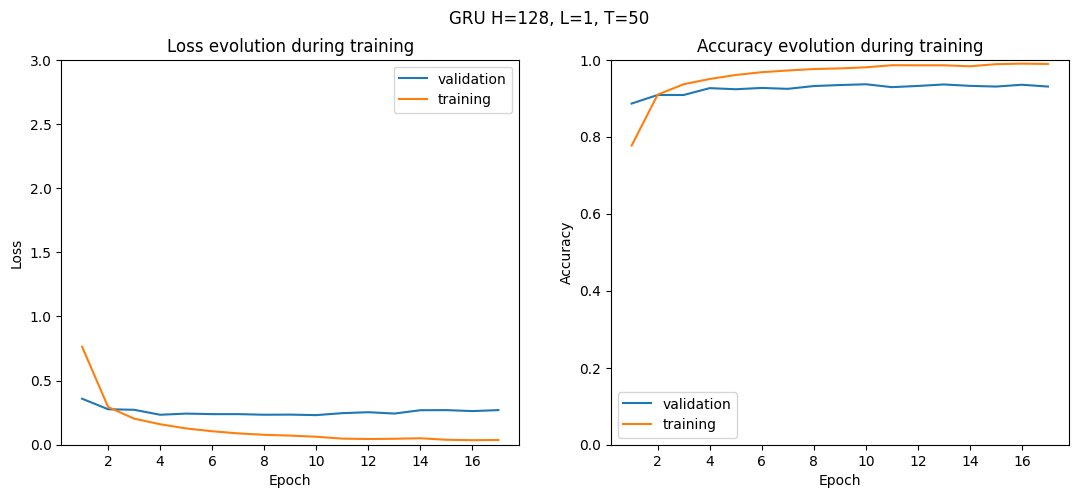

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


train_dl, val_dl, test_dl = load (MFCC_train_10, MFCC_val_10, MFCC_test_10, batch_size=64)

model = GRUModel(input_size=39, hidden_size=128, num_layers=1,
                   bidirectional=True, num_classes=11)

criterion = nn.CrossEntropyLoss()

curves = train_model(
    model, train_dl, val_dl,
    epochs=20, lr=1e-3, criterion=criterion,
    device=device, early_stopping_patience=7
)

show_curves(curves, title="GRU H=128, L=1, T=50", filename="gru_L=2.png")

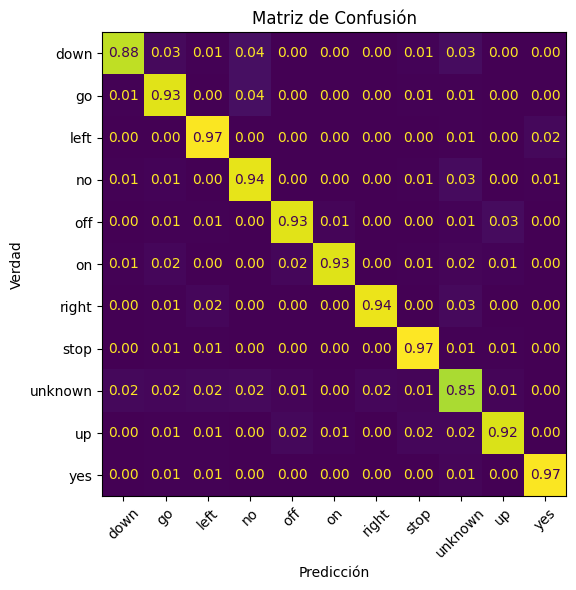

              precision    recall  f1-score   support

        down       0.95      0.88      0.92       396
          go       0.90      0.93      0.91       396
        left       0.93      0.97      0.95       396
          no       0.89      0.94      0.92       396
         off       0.94      0.93      0.93       396
          on       0.97      0.93      0.95       396
       right       0.97      0.94      0.96       396
        stop       0.94      0.97      0.96       396
     unknown       0.85      0.85      0.85       421
          up       0.93      0.92      0.93       396
         yes       0.97      0.97      0.97       396

    accuracy                           0.93      4381
   macro avg       0.93      0.93      0.93      4381
weighted avg       0.93      0.93      0.93      4381

Precisión global (Accuracy): 0.9299


In [ ]:
@torch.no_grad()
def get_predictions(loader, model, device="cpu"):
    """Obtiene las predicciones del modelo y las etiquetas verdaderas."""
    model.eval()
    all_predictions = []
    all_true_labels = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb).argmax(1)

        all_predictions.extend(pred.cpu().numpy())
        all_true_labels.extend(yb.cpu().numpy())
    return all_true_labels, all_predictions

true_labels, predictions = get_predictions(test_dl, model.to(device), device)

show_confusion_matrix(true_labels, predictions, class_names, title="Matriz de Confusión", filename = "matrizg_de_confusión_tr=2")

In [ ]:
# Con 130 hop
transform = T.MFCC(sample_rate=sample_rate, n_mfcc=13, melkwargs={"n_fft": 400, "hop_length": 130, "n_mels": 23, "center": False},)
MFCC_train_10 = aplicar_MFCC(transform, train_adaptado)
MFCC_val_10 = aplicar_MFCC(transform, val_adaptado)
MFCC_test_10 = aplicar_MFCC(transform, test_adaptado)

{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
Epoch 1/20
Iteration 84 - Batch 84/508 - Train loss: 1.9795, Train acc: 36.71%
Iteration 168 - Batch 168/508 - Train loss: 1.6460, Train acc: 49.82%
Iteration 252 - Batch 252/508 - Train loss: 1.3990, Train acc: 58.13%
Iteration 336 - Batch 336/508 - Train loss: 1.2137, Train acc: 63.74%
Iteration 420 - Batch 420/508 - Train loss: 1.0771, Train acc: 67.87%
Iteration 504 - Batch 504/508 - Train loss: 0.9757, Train acc: 70.80%
Val loss: 0.4219, Val acc: 86.97%
Epoch 2/20
Iteration 592 - Batch 84/508 - Train loss: 0.4151, Train acc: 87.70%
Iteration 676 - Batch 168/508 - Train loss: 0.3898, Train acc: 88.22%
Iteration 760 - Batch 252/508 - Trai

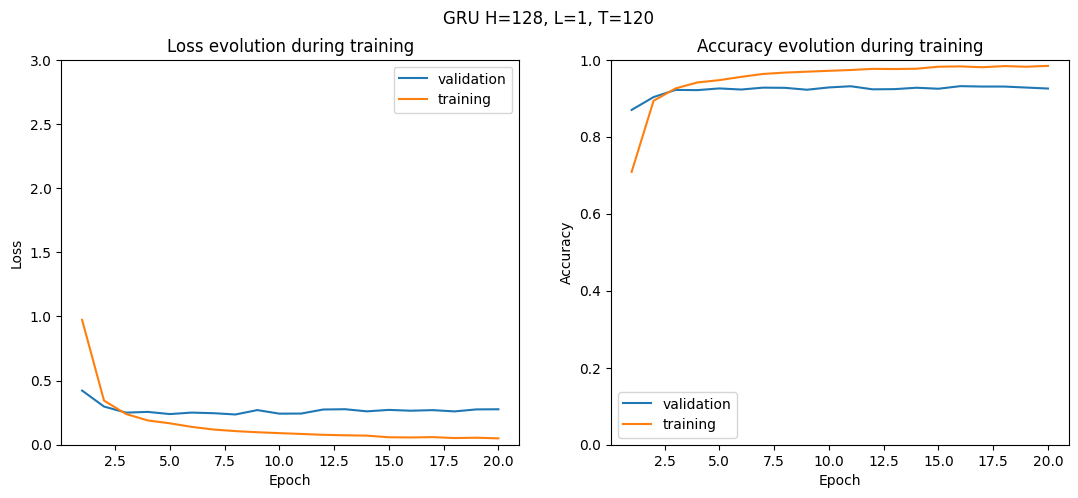

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


train_dl, val_dl, test_dl = load (MFCC_train_10, MFCC_val_10, MFCC_test_10, batch_size=64)

model = GRUModel(input_size=39, hidden_size=128, num_layers=1,
                   bidirectional=False, num_classes=11)

criterion = nn.CrossEntropyLoss()

curves = train_model(
    model, train_dl, val_dl,
    epochs=20, lr=1e-3, criterion=criterion,
    device=device, early_stopping_patience=7
)

show_curves(curves, title="GRU H=128, L=1, T=120", filename="gru_L=2.png")

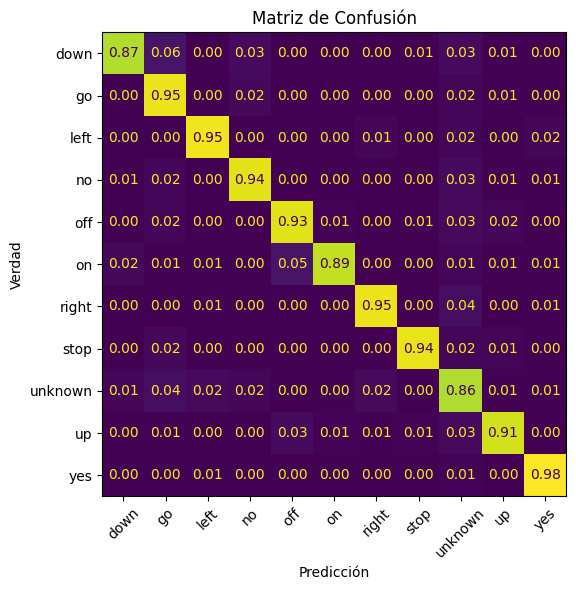

              precision    recall  f1-score   support

        down       0.94      0.87      0.90       396
          go       0.85      0.95      0.90       396
        left       0.95      0.95      0.95       396
          no       0.93      0.94      0.93       396
         off       0.92      0.93      0.92       396
          on       0.97      0.89      0.93       396
       right       0.94      0.95      0.95       396
        stop       0.98      0.94      0.96       396
     unknown       0.81      0.86      0.84       421
          up       0.94      0.91      0.93       396
         yes       0.96      0.98      0.97       396

    accuracy                           0.92      4381
   macro avg       0.93      0.92      0.92      4381
weighted avg       0.93      0.92      0.92      4381

Precisión global (Accuracy): 0.9240


In [ ]:
@torch.no_grad()
def get_predictions(loader, model, device="cpu"):
    """Obtiene las predicciones del modelo y las etiquetas verdaderas."""
    model.eval()
    all_predictions = []
    all_true_labels = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb).argmax(1)

        all_predictions.extend(pred.cpu().numpy())
        all_true_labels.extend(yb.cpu().numpy())
    return all_true_labels, all_predictions

true_labels, predictions = get_predictions(test_dl, model.to(device), device)

show_confusion_matrix(true_labels, predictions, class_names, title="Matriz de Confusión", filename = "matrizg_de_confusión_tr=2")

In [ ]:
# Con 220 hop
transform = T.MFCC(sample_rate=sample_rate, n_mfcc=13, melkwargs={"n_fft": 400, "hop_length": 220, "n_mels": 23, "center": False},)
MFCC_train_10 = aplicar_MFCC(transform, train_adaptado)
MFCC_val_10 = aplicar_MFCC(transform, val_adaptado)
MFCC_test_10 = aplicar_MFCC(transform, test_adaptado)

{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
Epoch 1/20
Iteration 84 - Batch 84/508 - Train loss: 1.9928, Train acc: 36.60%
Iteration 168 - Batch 168/508 - Train loss: 1.6065, Train acc: 52.52%
Iteration 252 - Batch 252/508 - Train loss: 1.3353, Train acc: 61.10%
Iteration 336 - Batch 336/508 - Train loss: 1.1450, Train acc: 66.76%
Iteration 420 - Batch 420/508 - Train loss: 1.0129, Train acc: 70.55%
Iteration 504 - Batch 504/508 - Train loss: 0.9117, Train acc: 73.45%
Val loss: 0.3617, Val acc: 89.06%
Epoch 2/20
Iteration 592 - Batch 84/508 - Train loss: 0.3493, Train acc: 89.45%
Iteration 676 - Batch 168/508 - Train loss: 0.3479, Train acc: 89.55%
Iteration 760 - Batch 252/508 - Trai

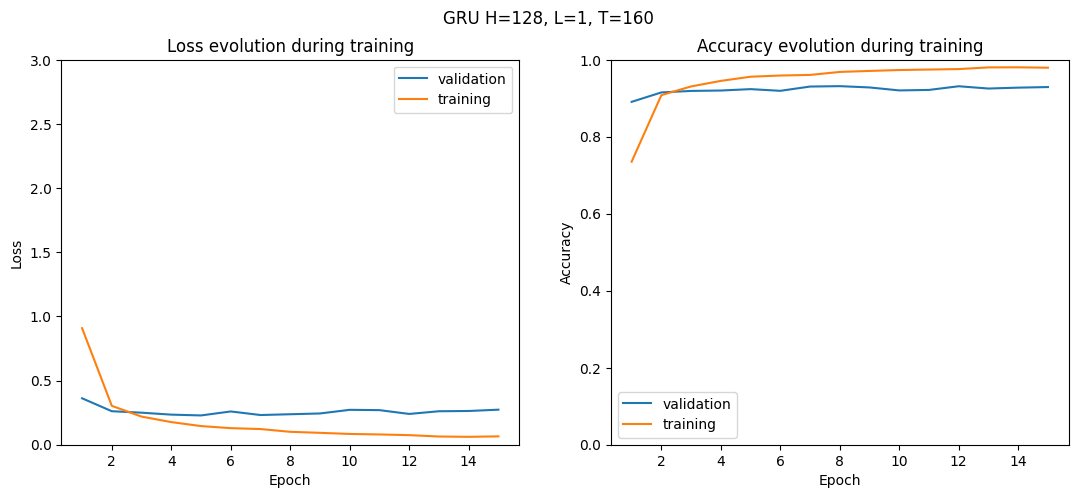

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


train_dl, val_dl, test_dl = load (MFCC_train_10, MFCC_val_10, MFCC_test_10, batch_size=64)

model = GRUModel(input_size=39, hidden_size=128, num_layers=1,
                   bidirectional=False, num_classes=11)

criterion = nn.CrossEntropyLoss()

curves = train_model(
    model, train_dl, val_dl,
    epochs=20, lr=1e-3, criterion=criterion,
    device=device, early_stopping_patience=7
)

show_curves(curves, title="GRU H=128, L=1, T=160", filename="gru_L=2.png")

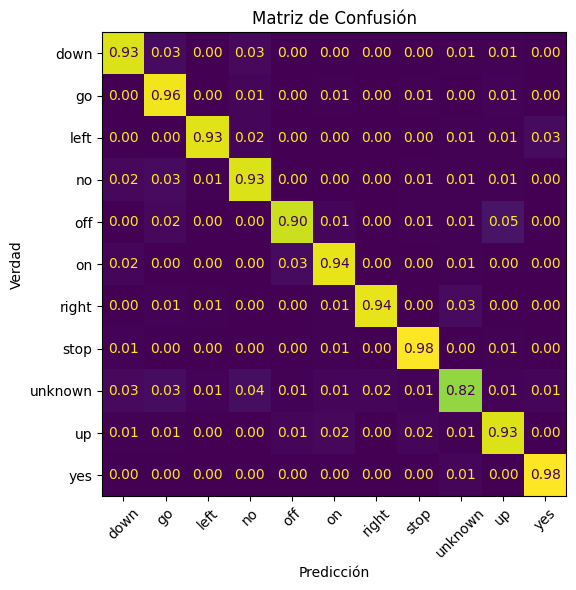

              precision    recall  f1-score   support

        down       0.91      0.93      0.92       396
          go       0.88      0.96      0.91       396
        left       0.97      0.93      0.95       396
          no       0.91      0.93      0.92       396
         off       0.95      0.90      0.92       396
          on       0.93      0.94      0.94       396
       right       0.98      0.94      0.96       396
        stop       0.95      0.98      0.96       396
     unknown       0.91      0.82      0.86       421
          up       0.90      0.93      0.92       396
         yes       0.95      0.98      0.97       396

    accuracy                           0.93      4381
   macro avg       0.93      0.93      0.93      4381
weighted avg       0.93      0.93      0.93      4381

Precisión global (Accuracy): 0.9299


In [ ]:
@torch.no_grad()
def get_predictions(loader, model, device="cpu"):
    """Obtiene las predicciones del modelo y las etiquetas verdaderas."""
    model.eval()
    all_predictions = []
    all_true_labels = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb).argmax(1)

        all_predictions.extend(pred.cpu().numpy())
        all_true_labels.extend(yb.cpu().numpy())
    return all_true_labels, all_predictions

true_labels, predictions = get_predictions(test_dl, model.to(device), device)

show_confusion_matrix(true_labels, predictions, class_names, title="Matriz de Confusión", filename = "matrizg_de_confusión_tr=2")

In [ ]:
# Con 280 hop
transform = T.MFCC(sample_rate=sample_rate, n_mfcc=13, melkwargs={"n_fft": 400, "hop_length": 280, "n_mels": 23, "center": False},)
MFCC_train_10 = aplicar_MFCC(transform, train_adaptado)
MFCC_val_10 = aplicar_MFCC(transform, val_adaptado)
MFCC_test_10 = aplicar_MFCC(transform, test_adaptado)

{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
Epoch 1/20
Iteration 84 - Batch 84/508 - Train loss: 1.6598, Train acc: 44.28%
Iteration 168 - Batch 168/508 - Train loss: 1.2149, Train acc: 60.27%
Iteration 252 - Batch 252/508 - Train loss: 0.9879, Train acc: 67.99%
Iteration 336 - Batch 336/508 - Train loss: 0.8480, Train acc: 72.59%
Iteration 420 - Batch 420/508 - Train loss: 0.7522, Train acc: 75.74%
Iteration 504 - Batch 504/508 - Train loss: 0.6841, Train acc: 77.95%
Val loss: 0.3151, Val acc: 89.39%
Epoch 2/20
Iteration 592 - Batch 84/508 - Train loss: 0.2899, Train acc: 90.51%
Iteration 676 - Batch 168/508 - Train loss: 0.2769, Train acc: 90.99%
Iteration 760 - Batch 252/508 - Trai

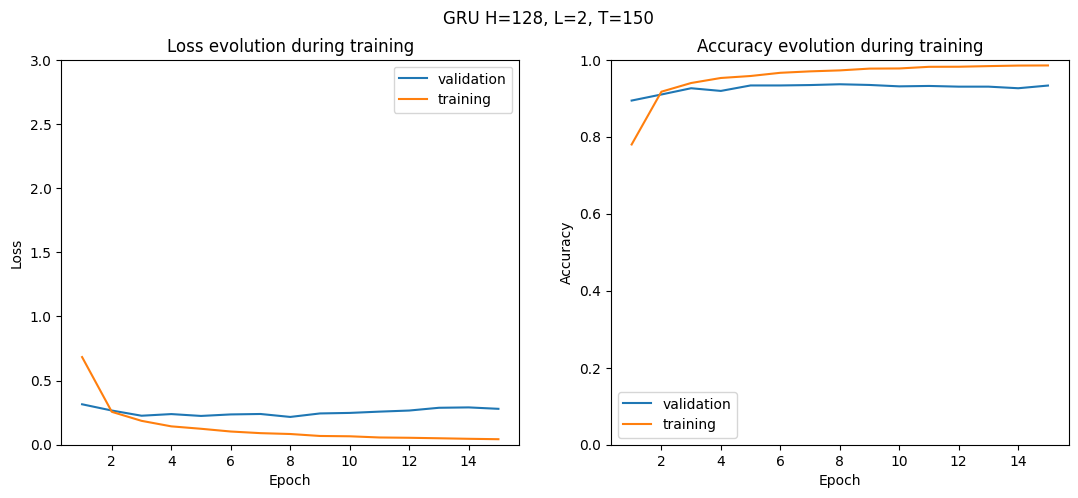

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


train_dl, val_dl, test_dl = load (MFCC_train_10, MFCC_val_10, MFCC_test_10, batch_size=64)

model = GRUModel(input_size=39, hidden_size=128, num_layers=2,
                   bidirectional=False, num_classes=11)

criterion = nn.CrossEntropyLoss()

curves = train_model(
    model, train_dl, val_dl,
    epochs=20, lr=1e-3, criterion=criterion,
    device=device, early_stopping_patience=7
)

show_curves(curves, title="GRU H=128, L=2, T=150", filename="gru_L=2.png")

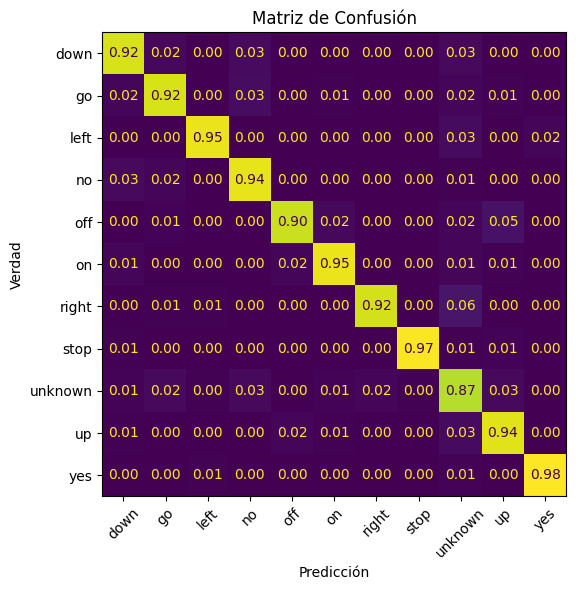

              precision    recall  f1-score   support

        down       0.92      0.92      0.92       396
          go       0.92      0.92      0.92       396
        left       0.97      0.95      0.96       396
          no       0.91      0.94      0.93       396
         off       0.96      0.90      0.93       396
          on       0.95      0.95      0.95       396
       right       0.98      0.92      0.95       396
        stop       0.99      0.97      0.98       396
     unknown       0.81      0.87      0.84       421
          up       0.90      0.94      0.92       396
         yes       0.98      0.98      0.98       396

    accuracy                           0.93      4381
   macro avg       0.94      0.93      0.93      4381
weighted avg       0.93      0.93      0.93      4381

Precisión global (Accuracy): 0.9329


In [ ]:
@torch.no_grad()
def get_predictions(loader, model, device="cpu"):
    """Obtiene las predicciones del modelo y las etiquetas verdaderas."""
    model.eval()
    all_predictions = []
    all_true_labels = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb).argmax(1)

        all_predictions.extend(pred.cpu().numpy())
        all_true_labels.extend(yb.cpu().numpy())
    return all_true_labels, all_predictions

true_labels, predictions = get_predictions(test_dl, model.to(device), device)

show_confusion_matrix(true_labels, predictions, class_names, title="Matriz de Confusión", filename = "matrizg_de_confusión_L=2")

In [ ]:
# Con 360 hop
transform = T.MFCC(sample_rate=sample_rate, n_mfcc=13, melkwargs={"n_fft": 400, "hop_length": 360, "n_mels": 23, "center": False},)
MFCC_train_10 = aplicar_MFCC(transform, train_adaptado)
MFCC_val_10 = aplicar_MFCC(transform, val_adaptado)
MFCC_test_10 = aplicar_MFCC(transform, test_adaptado)

{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
Epoch 1/20
Iteration 84 - Batch 84/508 - Train loss: 1.6313, Train acc: 46.93%
Iteration 168 - Batch 168/508 - Train loss: 1.1652, Train acc: 62.66%
Iteration 252 - Batch 252/508 - Train loss: 0.9414, Train acc: 69.92%
Iteration 336 - Batch 336/508 - Train loss: 0.8124, Train acc: 73.93%
Iteration 420 - Batch 420/508 - Train loss: 0.7191, Train acc: 76.94%
Iteration 504 - Batch 504/508 - Train loss: 0.6562, Train acc: 78.98%
Val loss: 0.3310, Val acc: 88.98%
Epoch 2/20
Iteration 592 - Batch 84/508 - Train loss: 0.3000, Train acc: 90.37%
Iteration 676 - Batch 168/508 - Train loss: 0.2830, Train acc: 90.92%
Iteration 760 - Batch 252/508 - Trai

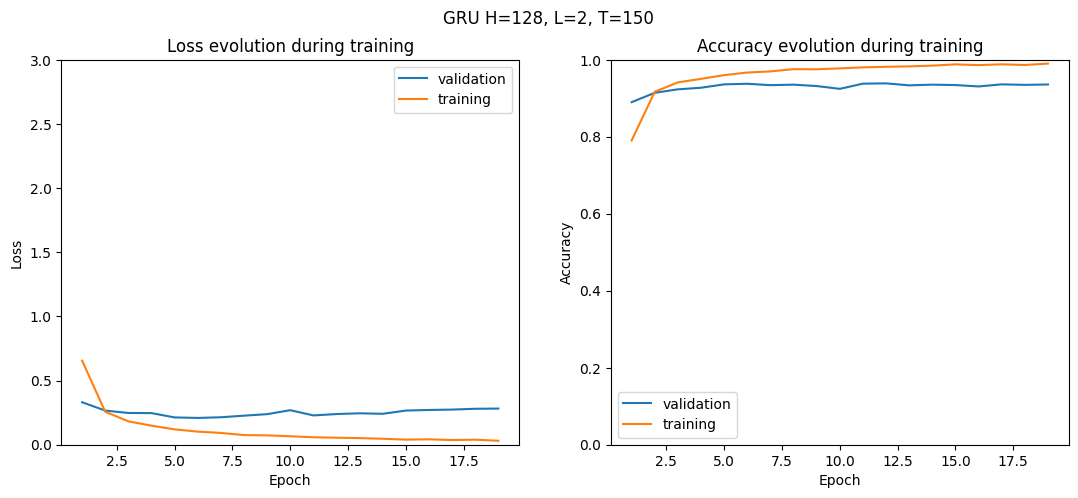

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


train_dl, val_dl, test_dl = load (MFCC_train_10, MFCC_val_10, MFCC_test_10, batch_size=64)

model = GRUModel(input_size=39, hidden_size=128, num_layers=2,
                   bidirectional=False, num_classes=11)

criterion = nn.CrossEntropyLoss()

curves = train_model(
    model, train_dl, val_dl,
    epochs=20, lr=1e-3, criterion=criterion,
    device=device, early_stopping_patience=7
)

show_curves(curves, title="GRU H=128, L=2, T=150", filename="gru_L=2.png")

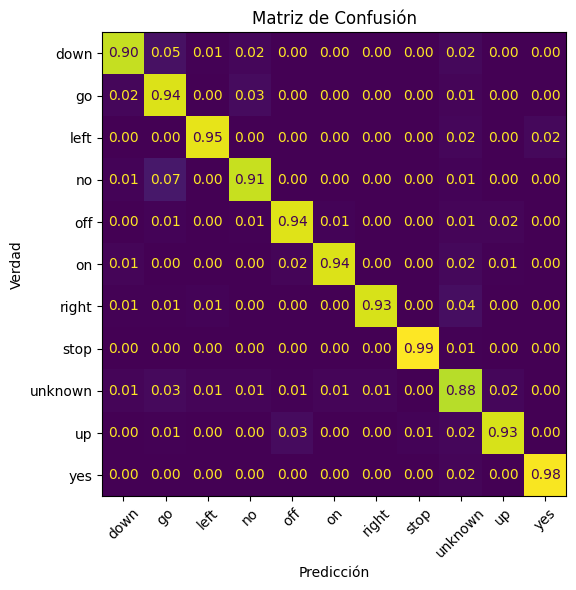

              precision    recall  f1-score   support

        down       0.93      0.90      0.92       396
          go       0.85      0.94      0.89       396
        left       0.97      0.95      0.96       396
          no       0.93      0.91      0.92       396
         off       0.94      0.94      0.94       396
          on       0.97      0.94      0.95       396
       right       0.98      0.93      0.96       396
        stop       0.98      0.99      0.98       396
     unknown       0.85      0.88      0.87       421
          up       0.95      0.93      0.94       396
         yes       0.97      0.98      0.97       396

    accuracy                           0.94      4381
   macro avg       0.94      0.94      0.94      4381
weighted avg       0.94      0.94      0.94      4381

Precisión global (Accuracy): 0.9359


In [ ]:
@torch.no_grad()
def get_predictions(loader, model, device="cpu"):
    """Obtiene las predicciones del modelo y las etiquetas verdaderas."""
    model.eval()
    all_predictions = []
    all_true_labels = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb).argmax(1)

        all_predictions.extend(pred.cpu().numpy())
        all_true_labels.extend(yb.cpu().numpy())
    return all_true_labels, all_predictions

true_labels, predictions = get_predictions(test_dl, model.to(device), device)

show_confusion_matrix(true_labels, predictions, class_names, title="Matriz de Confusión", filename = "matrizg_de_confusión_L=2")

### Modelo LSTM

#### Variación número de neuronas por capa

In [ ]:
# Con 160 hop
transform = T.MFCC(sample_rate=sample_rate, n_mfcc=13, melkwargs={"n_fft": 400, "hop_length": 160, "n_mels": 23, "center": False},)
MFCC_train_10 = aplicar_MFCC(transform, train_adaptado)
MFCC_val_10 = aplicar_MFCC(transform, val_adaptado)
MFCC_test_10 = aplicar_MFCC(transform, test_adaptado)

{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
Epoch 1/20
Iteration 84 - Batch 84/508 - Train loss: 2.2163, Train acc: 23.07%
Iteration 168 - Batch 168/508 - Train loss: 1.9656, Train acc: 34.01%
Iteration 252 - Batch 252/508 - Train loss: 1.7480, Train acc: 42.47%
Iteration 336 - Batch 336/508 - Train loss: 1.5650, Train acc: 49.04%
Iteration 420 - Batch 420/508 - Train loss: 1.4124, Train acc: 54.39%
Iteration 504 - Batch 504/508 - Train loss: 1.2914, Train acc: 58.54%
Val loss: 0.6134, Val acc: 81.14%
Epoch 2/20
Iteration 592 - Batch 84/508 - Train loss: 0.5961, Train acc: 81.40%
Iteration 676 - Batch 168/508 - Train loss: 0.5649, Train acc: 82.43%
Iteration 760 - Batch 252/508 - Trai

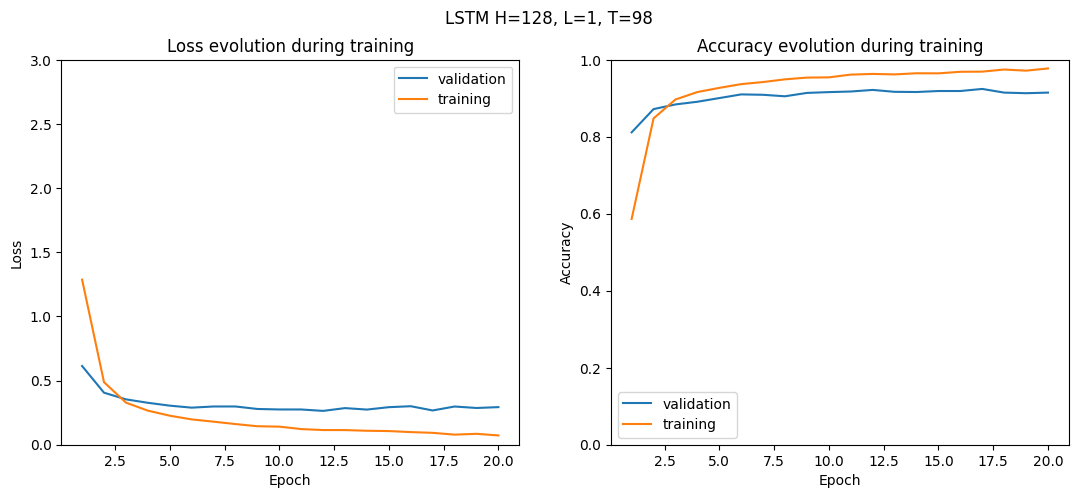

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


train_dl, val_dl, test_dl = load (MFCC_train_10, MFCC_val_10, MFCC_test_10, batch_size=64)

model = LSTMModel(input_size=39, hidden_size=128, num_layers=1,
                   bidirectional=False, num_classes=11)

criterion = nn.CrossEntropyLoss()

curves = train_model(
    model, train_dl, val_dl,
    epochs=20, lr=1e-3, criterion=criterion,
    device=device, early_stopping_patience=7
)

show_curves(curves, title="LSTM H=128, L=1, T=98", filename="LSTM_H=128.png")

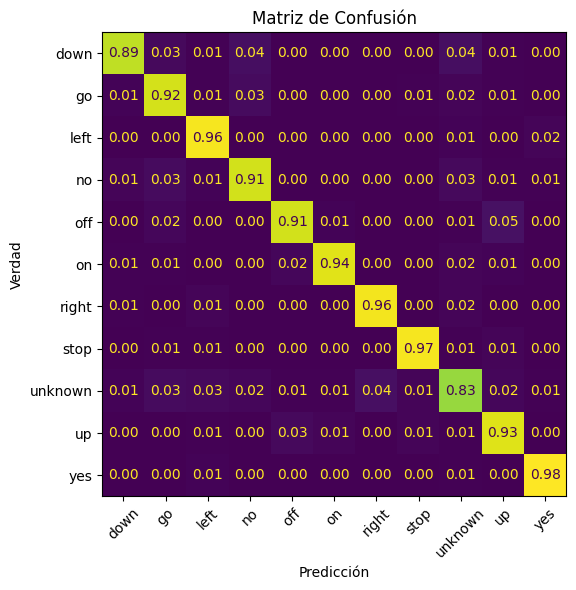

              precision    recall  f1-score   support

        down       0.94      0.89      0.91       396
          go       0.89      0.92      0.90       396
        left       0.92      0.96      0.94       396
          no       0.91      0.91      0.91       396
         off       0.94      0.91      0.93       396
          on       0.96      0.94      0.95       396
       right       0.95      0.96      0.96       396
        stop       0.96      0.97      0.97       396
     unknown       0.86      0.83      0.85       421
          up       0.90      0.93      0.91       396
         yes       0.97      0.98      0.97       396

    accuracy                           0.93      4381
   macro avg       0.93      0.93      0.93      4381
weighted avg       0.93      0.93      0.93      4381

Precisión global (Accuracy): 0.9270


In [ ]:
@torch.no_grad()
def get_predictions(loader, model, device="cpu"):
    """Obtiene las predicciones del modelo y las etiquetas verdaderas."""
    model.eval()
    all_predictions = []
    all_true_labels = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb).argmax(1)

        all_predictions.extend(pred.cpu().numpy())
        all_true_labels.extend(yb.cpu().numpy())
    return all_true_labels, all_predictions

true_labels, predictions = get_predictions(test_dl, model.to(device), device)

show_confusion_matrix(true_labels, predictions, class_names, title="Matriz de Confusión", filename = "matrizg_de_confusión_L=2")

{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
Epoch 1/20
Iteration 84 - Batch 84/508 - Train loss: 2.0428, Train acc: 32.33%
Iteration 168 - Batch 168/508 - Train loss: 1.6624, Train acc: 46.10%
Iteration 252 - Batch 252/508 - Train loss: 1.3881, Train acc: 55.38%
Iteration 336 - Batch 336/508 - Train loss: 1.1932, Train acc: 61.76%
Iteration 420 - Batch 420/508 - Train loss: 1.0569, Train acc: 66.22%
Iteration 504 - Batch 504/508 - Train loss: 0.9517, Train acc: 69.56%
Val loss: 0.4254, Val acc: 86.06%
Epoch 2/20
Iteration 592 - Batch 84/508 - Train loss: 0.4006, Train acc: 87.65%
Iteration 676 - Batch 168/508 - Train loss: 0.3694, Train acc: 88.45%
Iteration 760 - Batch 252/508 - Trai

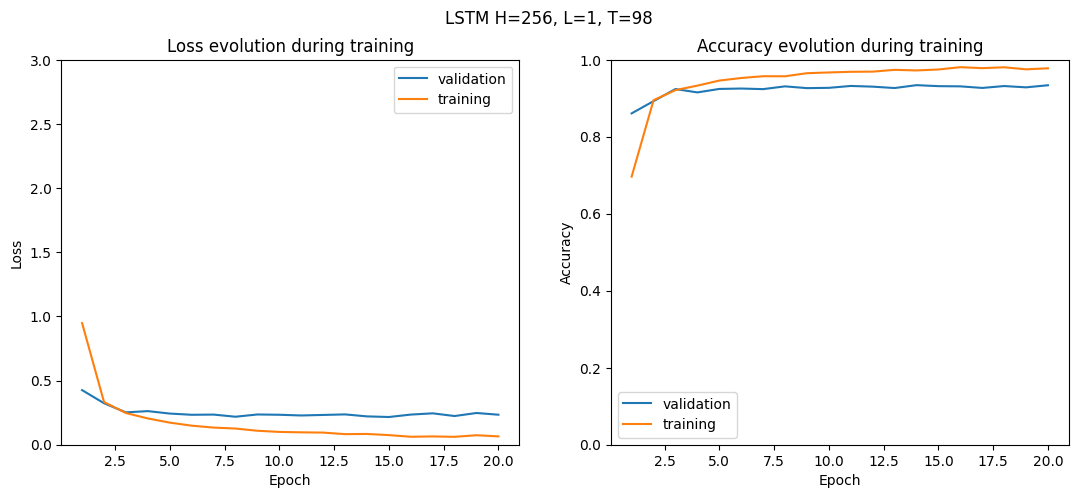

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


train_dl, val_dl, test_dl = load (MFCC_train_10, MFCC_val_10, MFCC_test_10, batch_size=64)

model = LSTMModel(input_size=39, hidden_size=256, num_layers=1,
                   bidirectional=False, num_classes=11)

criterion = nn.CrossEntropyLoss()

curves = train_model(
    model, train_dl, val_dl,
    epochs=20, lr=1e-3, criterion=criterion,
    device=device, early_stopping_patience=7
)

show_curves(curves, title="LSTM H=256, L=1, T=98", filename="LSTM_H=128.png")

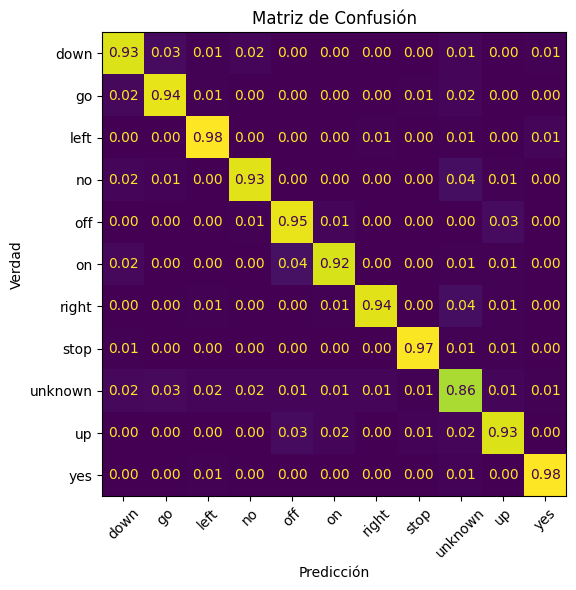

              precision    recall  f1-score   support

        down       0.91      0.93      0.92       396
          go       0.93      0.94      0.94       396
        left       0.96      0.98      0.97       396
          no       0.95      0.93      0.94       396
         off       0.91      0.95      0.93       396
          on       0.95      0.92      0.94       396
       right       0.98      0.94      0.96       396
        stop       0.97      0.97      0.97       396
     unknown       0.86      0.86      0.86       421
          up       0.93      0.93      0.93       396
         yes       0.97      0.98      0.98       396

    accuracy                           0.94      4381
   macro avg       0.94      0.94      0.94      4381
weighted avg       0.94      0.94      0.94      4381

Precisión global (Accuracy): 0.9381


In [ ]:
@torch.no_grad()
def get_predictions(loader, model, device="cpu"):
    """Obtiene las predicciones del modelo y las etiquetas verdaderas."""
    model.eval()
    all_predictions = []
    all_true_labels = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb).argmax(1)

        all_predictions.extend(pred.cpu().numpy())
        all_true_labels.extend(yb.cpu().numpy())
    return all_true_labels, all_predictions

true_labels, predictions = get_predictions(test_dl, model.to(device), device)

show_confusion_matrix(true_labels, predictions, class_names, title="Matriz de Confusión", filename = "matrizL_de_confusión_H=128")

#### Variacion número de capas

{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
Epoch 1/20
Iteration 84 - Batch 84/508 - Train loss: 2.0335, Train acc: 26.34%
Iteration 168 - Batch 168/508 - Train loss: 1.7867, Train acc: 35.36%
Iteration 252 - Batch 252/508 - Train loss: 1.6290, Train acc: 41.34%
Iteration 336 - Batch 336/508 - Train loss: 1.5006, Train acc: 46.82%
Iteration 420 - Batch 420/508 - Train loss: 1.4093, Train acc: 50.52%
Iteration 504 - Batch 504/508 - Train loss: 1.3312, Train acc: 53.59%
Val loss: 0.8118, Val acc: 73.88%
Epoch 2/20
Iteration 592 - Batch 84/508 - Train loss: 0.8015, Train acc: 74.34%
Iteration 676 - Batch 168/508 - Train loss: 0.7921, Train acc: 74.43%
Iteration 760 - Batch 252/508 - Trai

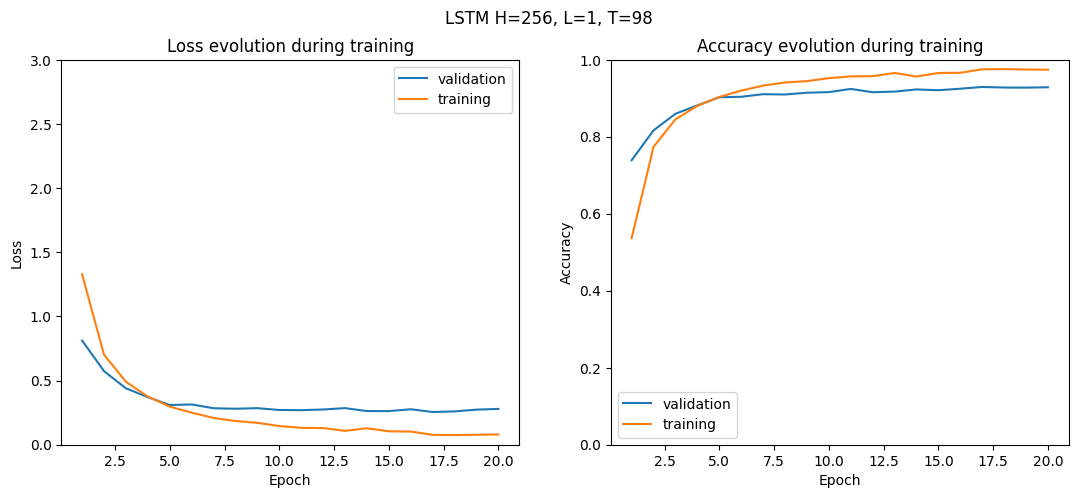

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


train_dl, val_dl, test_dl = load (MFCC_train_10, MFCC_val_10, MFCC_test_10, batch_size=64)

model = LSTMModel(input_size=39, hidden_size=128, num_layers=2,
                   bidirectional=False, num_classes=11)

criterion = nn.CrossEntropyLoss()

curves = train_model(
    model, train_dl, val_dl,
    epochs=20, lr=1e-3, criterion=criterion,
    device=device, early_stopping_patience=7
)

show_curves(curves, title="LSTM H=256, L=1, T=98", filename="LSTM_H=128.png")

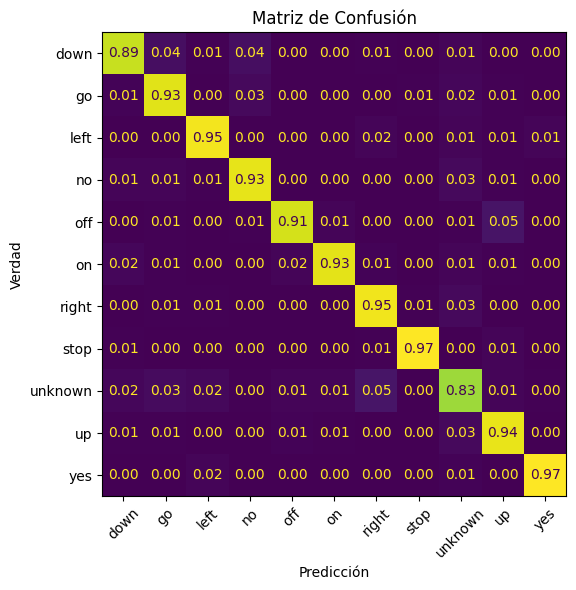

              precision    recall  f1-score   support

        down       0.93      0.89      0.91       396
          go       0.90      0.93      0.91       396
        left       0.94      0.95      0.95       396
          no       0.93      0.93      0.93       396
         off       0.96      0.91      0.93       396
          on       0.96      0.93      0.95       396
       right       0.90      0.95      0.93       396
        stop       0.98      0.97      0.97       396
     unknown       0.86      0.83      0.84       421
          up       0.90      0.94      0.92       396
         yes       0.98      0.97      0.97       396

    accuracy                           0.93      4381
   macro avg       0.93      0.93      0.93      4381
weighted avg       0.93      0.93      0.93      4381

Precisión global (Accuracy): 0.9281


In [ ]:
@torch.no_grad()
def get_predictions(loader, model, device="cpu"):
    """Obtiene las predicciones del modelo y las etiquetas verdaderas."""
    model.eval()
    all_predictions = []
    all_true_labels = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb).argmax(1)

        all_predictions.extend(pred.cpu().numpy())
        all_true_labels.extend(yb.cpu().numpy())
    return all_true_labels, all_predictions

true_labels, predictions = get_predictions(test_dl, model.to(device), device)

show_confusion_matrix(true_labels, predictions, class_names, title="Matriz de Confusión", filename = "matrizL_de_confusión_H=128")

{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
Epoch 1/20
Iteration 84 - Batch 84/508 - Train loss: 1.9334, Train acc: 29.04%
Iteration 168 - Batch 168/508 - Train loss: 1.6491, Train acc: 40.34%
Iteration 252 - Batch 252/508 - Train loss: 1.4783, Train acc: 47.12%
Iteration 336 - Batch 336/508 - Train loss: 1.3645, Train acc: 51.43%
Iteration 420 - Batch 420/508 - Train loss: 1.2833, Train acc: 54.59%
Iteration 504 - Batch 504/508 - Train loss: 1.2177, Train acc: 57.18%
Val loss: 0.8553, Val acc: 71.17%
Epoch 2/20
Iteration 592 - Batch 84/508 - Train loss: 0.8156, Train acc: 73.00%
Iteration 676 - Batch 168/508 - Train loss: 0.7898, Train acc: 74.05%
Iteration 760 - Batch 252/508 - Trai

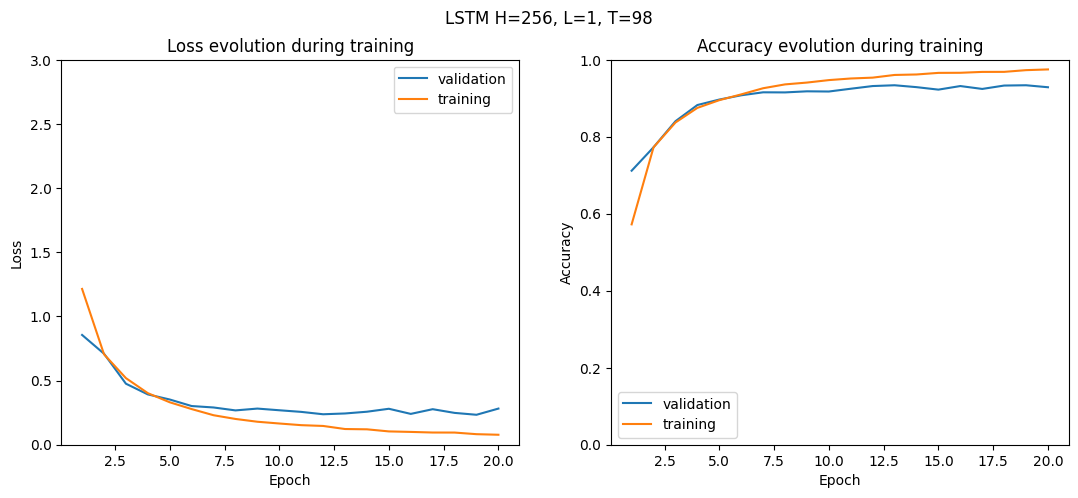

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


train_dl, val_dl, test_dl = load (MFCC_train_10, MFCC_val_10, MFCC_test_10, batch_size=64)

model = LSTMModel(input_size=39, hidden_size=128, num_layers=3,
                   bidirectional=False, num_classes=11)

criterion = nn.CrossEntropyLoss()

curves = train_model(
    model, train_dl, val_dl,
    epochs=20, lr=1e-3, criterion=criterion,
    device=device, early_stopping_patience=7
)

show_curves(curves, title="LSTM H=256, L=1, T=98", filename="LSTM_H=128.png")

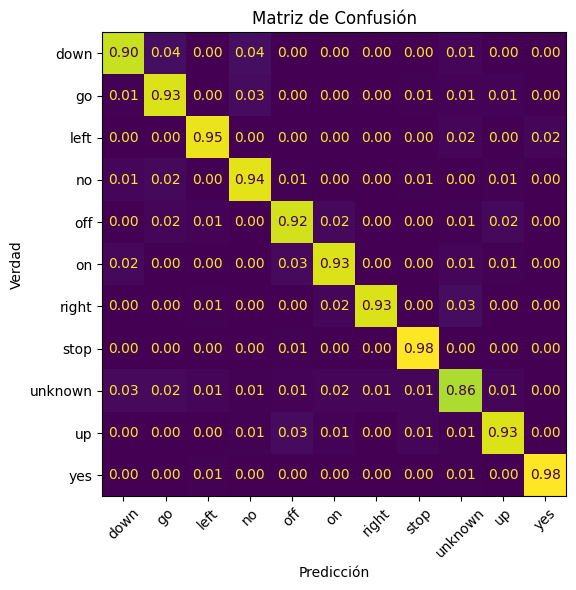

              precision    recall  f1-score   support

        down       0.92      0.90      0.91       396
          go       0.90      0.93      0.92       396
        left       0.95      0.95      0.95       396
          no       0.92      0.94      0.93       396
         off       0.93      0.92      0.92       396
          on       0.93      0.93      0.93       396
       right       0.98      0.93      0.95       396
        stop       0.95      0.98      0.97       396
     unknown       0.89      0.86      0.88       421
          up       0.93      0.93      0.93       396
         yes       0.98      0.98      0.98       396

    accuracy                           0.93      4381
   macro avg       0.94      0.94      0.93      4381
weighted avg       0.93      0.93      0.93      4381

Precisión global (Accuracy): 0.9347


In [ ]:
@torch.no_grad()
def get_predictions(loader, model, device="cpu"):
    """Obtiene las predicciones del modelo y las etiquetas verdaderas."""
    model.eval()
    all_predictions = []
    all_true_labels = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb).argmax(1)

        all_predictions.extend(pred.cpu().numpy())
        all_true_labels.extend(yb.cpu().numpy())
    return all_true_labels, all_predictions

true_labels, predictions = get_predictions(test_dl, model.to(device), device)

show_confusion_matrix(true_labels, predictions, class_names, title="Matriz de Confusión", filename = "matrizL_de_confusión_H=128")

#### Mejor modelo

{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
Epoch 1/20
Iteration 84 - Batch 84/508 - Train loss: 1.9117, Train acc: 28.69%
Iteration 168 - Batch 168/508 - Train loss: 1.6376, Train acc: 39.97%
Iteration 252 - Batch 252/508 - Train loss: 1.4342, Train acc: 48.31%
Iteration 336 - Batch 336/508 - Train loss: 1.3036, Train acc: 53.69%
Iteration 420 - Batch 420/508 - Train loss: 1.1906, Train acc: 58.25%
Iteration 504 - Batch 504/508 - Train loss: 1.1000, Train acc: 61.90%
Val loss: 0.5223, Val acc: 83.82%
Epoch 2/20
Iteration 592 - Batch 84/508 - Train loss: 0.5809, Train acc: 81.36%
Iteration 676 - Batch 168/508 - Train loss: 0.5517, Train acc: 82.41%
Iteration 760 - Batch 252/508 - Trai

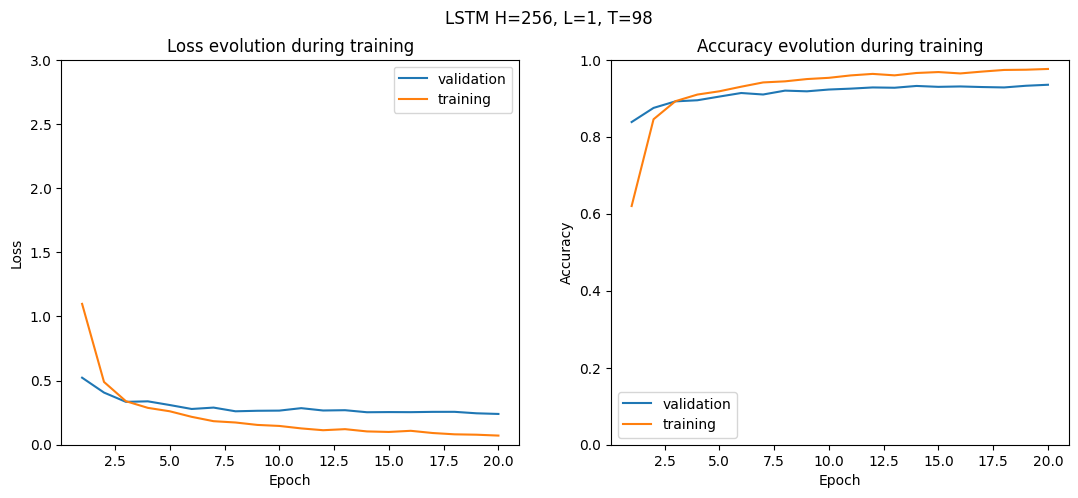

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


train_dl, val_dl, test_dl = load (MFCC_train_10, MFCC_val_10, MFCC_test_10, batch_size=64)

model = LSTMModel(input_size=39, hidden_size=256, num_layers=3,
                   bidirectional=False, num_classes=11)

criterion = nn.CrossEntropyLoss()

curves = train_model(
    model, train_dl, val_dl,
    epochs=20, lr=1e-3, criterion=criterion,
    device=device, early_stopping_patience=7
)

show_curves(curves, title="LSTM H=256, L=1, T=98", filename="LSTM_H=128.png")

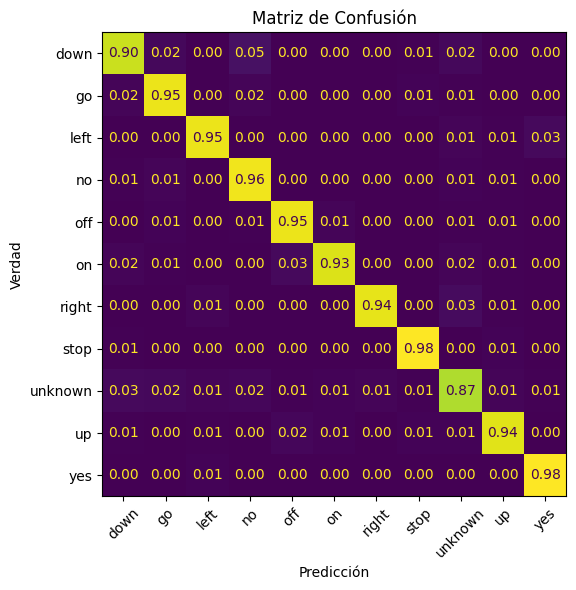

              precision    recall  f1-score   support

        down       0.92      0.90      0.91       396
          go       0.92      0.95      0.94       396
        left       0.95      0.95      0.95       396
          no       0.91      0.96      0.94       396
         off       0.95      0.95      0.95       396
          on       0.96      0.93      0.94       396
       right       0.98      0.94      0.96       396
        stop       0.97      0.98      0.97       396
     unknown       0.89      0.87      0.88       421
          up       0.95      0.94      0.94       396
         yes       0.97      0.98      0.97       396

    accuracy                           0.94      4381
   macro avg       0.94      0.94      0.94      4381
weighted avg       0.94      0.94      0.94      4381

Precisión global (Accuracy): 0.9420


In [ ]:
@torch.no_grad()
def get_predictions(loader, model, device="cpu"):
    """Obtiene las predicciones del modelo y las etiquetas verdaderas."""
    model.eval()
    all_predictions = []
    all_true_labels = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb).argmax(1)

        all_predictions.extend(pred.cpu().numpy())
        all_true_labels.extend(yb.cpu().numpy())
    return all_true_labels, all_predictions

true_labels, predictions = get_predictions(test_dl, model.to(device), device)

show_confusion_matrix(true_labels, predictions, class_names, title="Matriz de Confusión", filename = "matrizL_de_confusión_H=128")

#### Variación largo de secuencia

In [ ]:
MFCC_train_10 = 0
MFCC_val_10 = 0
MFCC_test_10 = 0

In [ ]:
# Con 50 hop (mayor largo de secuencia)
transform = T.MFCC(sample_rate=sample_rate, n_mfcc=13, melkwargs={"n_fft": 400, "hop_length": 50, "n_mels": 23, "center": False},)
MFCC_train_10 = aplicar_MFCC(transform, train_adaptado)
MFCC_val_10 = aplicar_MFCC(transform, val_adaptado)
MFCC_test_10 = aplicar_MFCC(transform, test_adaptado)

{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
Epoch 1/20
Iteration 84 - Batch 84/508 - Train loss: 2.2833, Train acc: 18.68%
Iteration 168 - Batch 168/508 - Train loss: 2.1216, Train acc: 25.66%
Iteration 252 - Batch 252/508 - Train loss: 1.9786, Train acc: 31.31%
Iteration 336 - Batch 336/508 - Train loss: 1.8669, Train acc: 35.80%
Iteration 420 - Batch 420/508 - Train loss: 1.7674, Train acc: 39.80%
Iteration 504 - Batch 504/508 - Train loss: 1.6812, Train acc: 43.13%
Val loss: 1.1492, Val acc: 64.41%
Epoch 2/20
Iteration 592 - Batch 84/508 - Train loss: 1.1540, Train acc: 63.58%
Iteration 676 - Batch 168/508 - Train loss: 1.1004, Train acc: 64.97%
Iteration 760 - Batch 252/508 - Trai

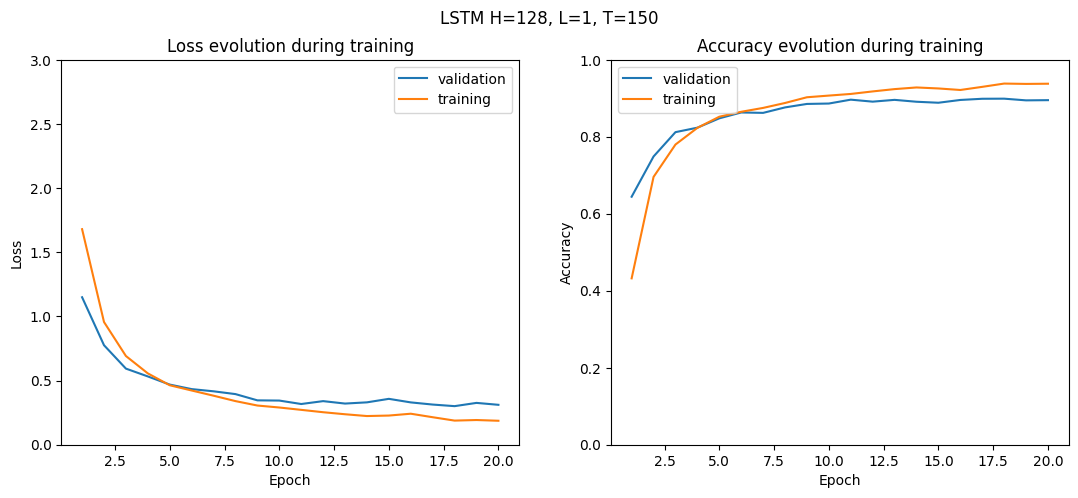

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


train_dl, val_dl, test_dl = load (MFCC_train_10, MFCC_val_10, MFCC_test_10, batch_size=64)

model = LSTMModel(input_size=39, hidden_size=128, num_layers=1,
                   bidirectional=False, num_classes=11)

criterion = nn.CrossEntropyLoss()

curves = train_model(
    model, train_dl, val_dl,
    epochs=20, lr=1e-3, criterion=criterion,
    device=device, early_stopping_patience=7
)

show_curves(curves, title="LSTM H=128, L=1, T=150", filename="LSTM_H=256.png")

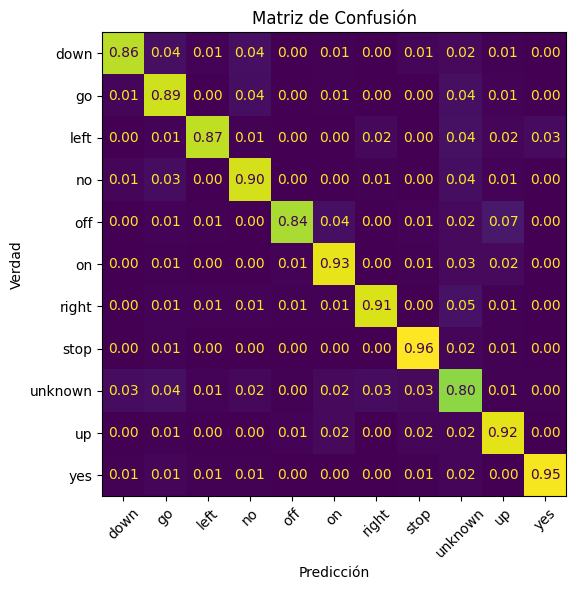

              precision    recall  f1-score   support

        down       0.92      0.86      0.89       396
          go       0.84      0.89      0.87       396
        left       0.95      0.87      0.91       396
          no       0.88      0.90      0.89       396
         off       0.97      0.84      0.90       396
          on       0.90      0.93      0.91       396
       right       0.94      0.91      0.92       396
        stop       0.92      0.96      0.94       396
     unknown       0.75      0.80      0.77       421
          up       0.87      0.92      0.89       396
         yes       0.96      0.95      0.96       396

    accuracy                           0.90      4381
   macro avg       0.90      0.90      0.90      4381
weighted avg       0.90      0.90      0.90      4381

Precisión global (Accuracy): 0.8957


In [ ]:
@torch.no_grad()
def get_predictions(loader, model, device="cpu"):
    """Obtiene las predicciones del modelo y las etiquetas verdaderas."""
    model.eval()
    all_predictions = []
    all_true_labels = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb).argmax(1)

        all_predictions.extend(pred.cpu().numpy())
        all_true_labels.extend(yb.cpu().numpy())
    return all_true_labels, all_predictions

true_labels, predictions = get_predictions(test_dl, model.to(device), device)

show_confusion_matrix(true_labels, predictions, class_names, title="Matriz de Confusión", filename = "matrizL_de_confusión_H=256")

In [ ]:
# Con 75 hop
transform = T.MFCC(sample_rate=sample_rate, n_mfcc=13, melkwargs={"n_fft": 400, "hop_length": 75, "n_mels": 23, "center": False},)
MFCC_train_10 = aplicar_MFCC(transform, train_adaptado)
MFCC_val_10 = aplicar_MFCC(transform, val_adaptado)
MFCC_test_10 = aplicar_MFCC(transform, test_adaptado)

{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
Epoch 1/20
Iteration 84 - Batch 84/508 - Train loss: 2.2903, Train acc: 19.19%
Iteration 168 - Batch 168/508 - Train loss: 2.1310, Train acc: 27.29%
Iteration 252 - Batch 252/508 - Train loss: 1.9749, Train acc: 33.63%
Iteration 336 - Batch 336/508 - Train loss: 1.8340, Train acc: 39.42%
Iteration 420 - Batch 420/508 - Train loss: 1.7209, Train acc: 43.56%
Iteration 504 - Batch 504/508 - Train loss: 1.6157, Train acc: 47.45%
Val loss: 0.9944, Val acc: 70.32%
Epoch 2/20
Iteration 592 - Batch 84/508 - Train loss: 0.9399, Train acc: 71.45%
Iteration 676 - Batch 168/508 - Train loss: 0.8778, Train acc: 73.38%
Iteration 760 - Batch 252/508 - Trai

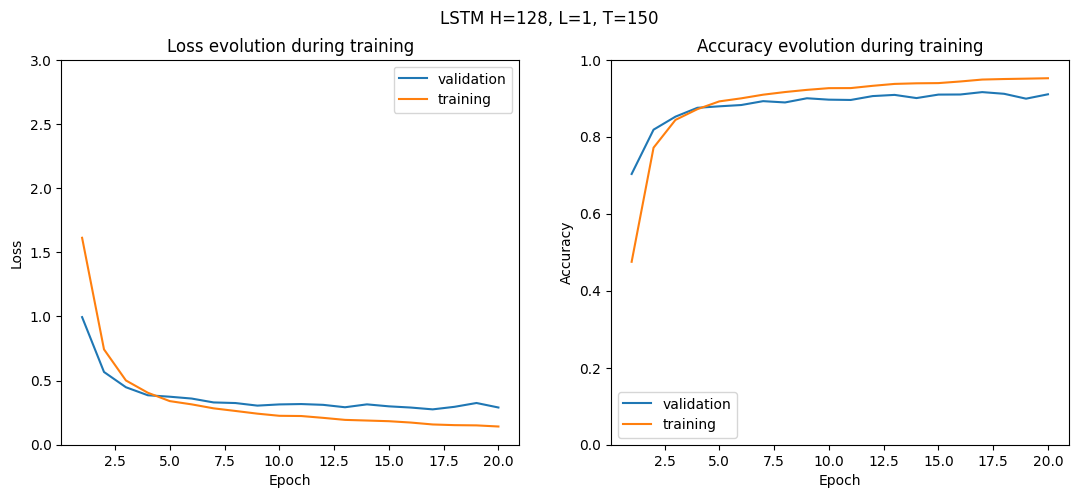

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


train_dl, val_dl, test_dl = load (MFCC_train_10, MFCC_val_10, MFCC_test_10, batch_size=64)

model = LSTMModel(input_size=39, hidden_size=128, num_layers=1,
                   bidirectional=False, num_classes=11)

criterion = nn.CrossEntropyLoss()

curves = train_model(
    model, train_dl, val_dl,
    epochs=20, lr=1e-3, criterion=criterion,
    device=device, early_stopping_patience=7
)

show_curves(curves, title="LSTM H=128, L=1, T=150", filename="LSTM_H=256.png")

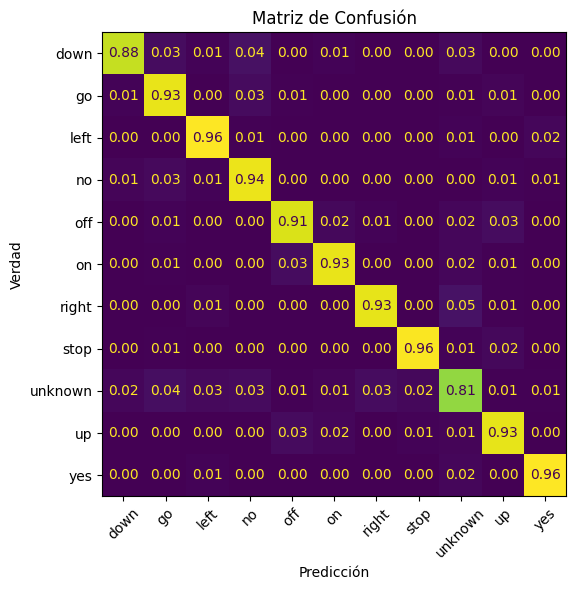

              precision    recall  f1-score   support

        down       0.95      0.88      0.91       396
          go       0.89      0.93      0.91       396
        left       0.93      0.96      0.95       396
          no       0.89      0.94      0.91       396
         off       0.92      0.91      0.91       396
          on       0.94      0.93      0.94       396
       right       0.96      0.93      0.94       396
        stop       0.95      0.96      0.96       396
     unknown       0.84      0.81      0.83       421
          up       0.91      0.93      0.92       396
         yes       0.97      0.96      0.97       396

    accuracy                           0.92      4381
   macro avg       0.92      0.92      0.92      4381
weighted avg       0.92      0.92      0.92      4381

Precisión global (Accuracy): 0.9219


In [ ]:
@torch.no_grad()
def get_predictions(loader, model, device="cpu"):
    """Obtiene las predicciones del modelo y las etiquetas verdaderas."""
    model.eval()
    all_predictions = []
    all_true_labels = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb).argmax(1)

        all_predictions.extend(pred.cpu().numpy())
        all_true_labels.extend(yb.cpu().numpy())
    return all_true_labels, all_predictions

true_labels, predictions = get_predictions(test_dl, model.to(device), device)

show_confusion_matrix(true_labels, predictions, class_names, title="Matriz de Confusión", filename = "matrizL_de_confusión_H=256")

In [ ]:
# Con 100 hop
transform = T.MFCC(sample_rate=sample_rate, n_mfcc=13, melkwargs={"n_fft": 400, "hop_length": 100, "n_mels": 23, "center": False},)
MFCC_train_10 = aplicar_MFCC(transform, train_adaptado)
MFCC_val_10 = aplicar_MFCC(transform, val_adaptado)
MFCC_test_10 = aplicar_MFCC(transform, test_adaptado)

{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
Epoch 1/20
Iteration 84 - Batch 84/508 - Train loss: 2.2852, Train acc: 21.25%
Iteration 168 - Batch 168/508 - Train loss: 2.0644, Train acc: 31.30%
Iteration 252 - Batch 252/508 - Train loss: 1.8669, Train acc: 38.92%
Iteration 336 - Batch 336/508 - Train loss: 1.7004, Train acc: 44.77%
Iteration 420 - Batch 420/508 - Train loss: 1.5638, Train acc: 49.52%
Iteration 504 - Batch 504/508 - Train loss: 1.4525, Train acc: 53.25%
Val loss: 0.7938, Val acc: 75.56%
Epoch 2/20
Iteration 592 - Batch 84/508 - Train loss: 0.8076, Train acc: 74.94%
Iteration 676 - Batch 168/508 - Train loss: 0.7526, Train acc: 76.41%
Iteration 760 - Batch 252/508 - Trai

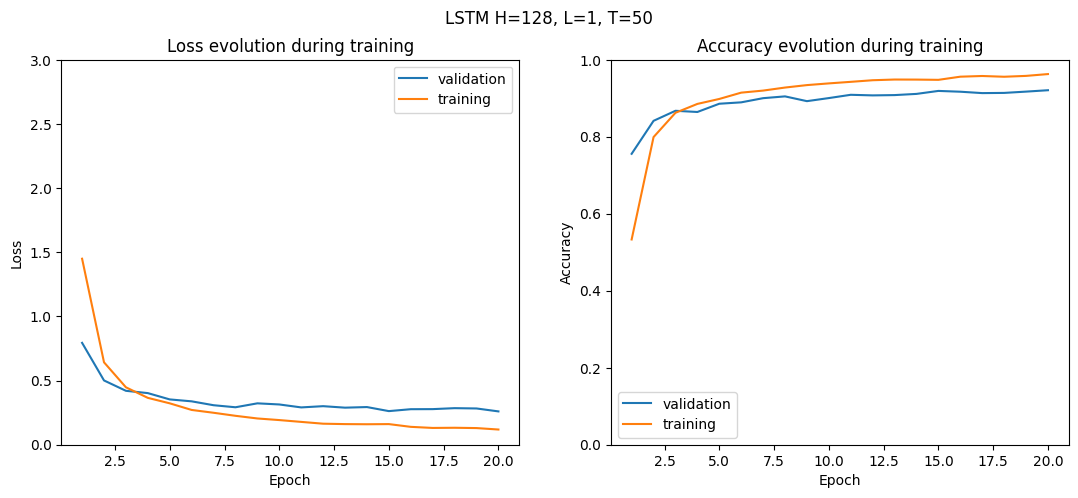

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


train_dl, val_dl, test_dl = load (MFCC_train_10, MFCC_val_10, MFCC_test_10, batch_size=64)

model = LSTMModel(input_size=39, hidden_size=128, num_layers=1,
                   bidirectional=False, num_classes=11)

criterion = nn.CrossEntropyLoss()

curves = train_model(
    model, train_dl, val_dl,
    epochs=20, lr=1e-3, criterion=criterion,
    device=device, early_stopping_patience=7
)

show_curves(curves, title="LSTM H=128, L=1, T=50", filename="LSTM_H=256.png")

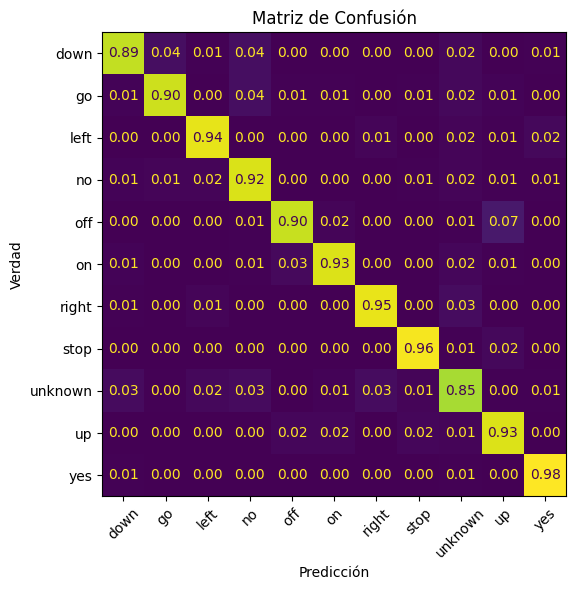

              precision    recall  f1-score   support

        down       0.92      0.89      0.91       396
          go       0.93      0.90      0.92       396
        left       0.94      0.94      0.94       396
          no       0.89      0.92      0.90       396
         off       0.94      0.90      0.92       396
          on       0.95      0.93      0.94       396
       right       0.94      0.95      0.95       396
        stop       0.95      0.96      0.96       396
     unknown       0.85      0.85      0.85       421
          up       0.88      0.93      0.90       396
         yes       0.96      0.98      0.97       396

    accuracy                           0.92      4381
   macro avg       0.92      0.92      0.92      4381
weighted avg       0.92      0.92      0.92      4381

Precisión global (Accuracy): 0.9233


In [ ]:
@torch.no_grad()
def get_predictions(loader, model, device="cpu"):
    """Obtiene las predicciones del modelo y las etiquetas verdaderas."""
    model.eval()
    all_predictions = []
    all_true_labels = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb).argmax(1)

        all_predictions.extend(pred.cpu().numpy())
        all_true_labels.extend(yb.cpu().numpy())
    return all_true_labels, all_predictions

true_labels, predictions = get_predictions(test_dl, model.to(device), device)

show_confusion_matrix(true_labels, predictions, class_names, title="Matriz de Confusión", filename = "matrizL_de_confusión_H=256")

In [ ]:
# Con 130 hop
transform = T.MFCC(sample_rate=sample_rate, n_mfcc=13, melkwargs={"n_fft": 400, "hop_length": 130, "n_mels": 23, "center": False},)
MFCC_train_10 = aplicar_MFCC(transform, train_adaptado)
MFCC_val_10 = aplicar_MFCC(transform, val_adaptado)
MFCC_test_10 = aplicar_MFCC(transform, test_adaptado)

{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
Epoch 1/20
Iteration 84 - Batch 84/508 - Train loss: 2.2622, Train acc: 20.29%
Iteration 168 - Batch 168/508 - Train loss: 2.0565, Train acc: 30.34%
Iteration 252 - Batch 252/508 - Train loss: 1.8633, Train acc: 38.07%
Iteration 336 - Batch 336/508 - Train loss: 1.7039, Train acc: 43.86%
Iteration 420 - Batch 420/508 - Train loss: 1.5719, Train acc: 48.56%
Iteration 504 - Batch 504/508 - Train loss: 1.4606, Train acc: 52.29%
Val loss: 0.8532, Val acc: 72.39%
Epoch 2/20
Iteration 592 - Batch 84/508 - Train loss: 0.7874, Train acc: 75.31%
Iteration 676 - Batch 168/508 - Train loss: 0.7691, Train acc: 75.67%
Iteration 760 - Batch 252/508 - Trai

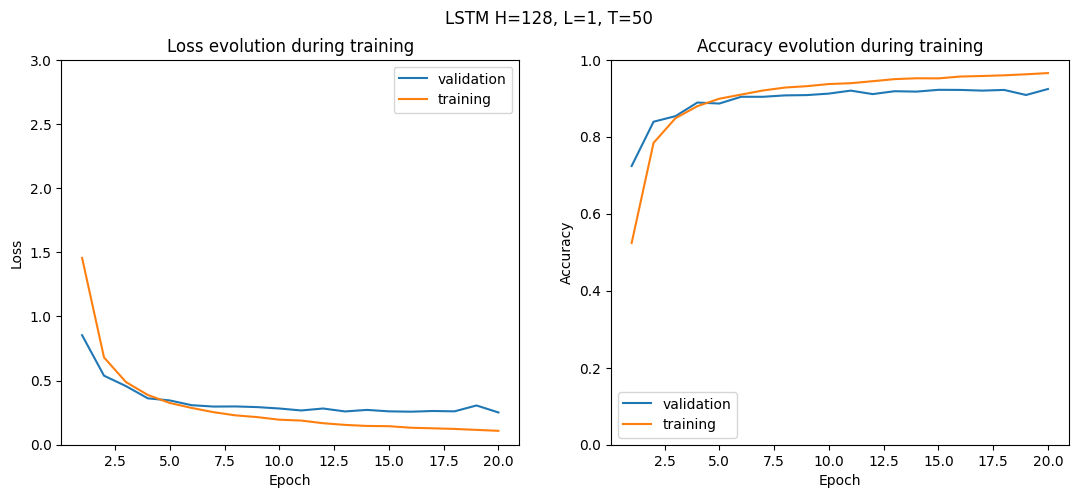

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


train_dl, val_dl, test_dl = load (MFCC_train_10, MFCC_val_10, MFCC_test_10, batch_size=64)

model = LSTMModel(input_size=39, hidden_size=128, num_layers=1,
                   bidirectional=False, num_classes=11)

criterion = nn.CrossEntropyLoss()

curves = train_model(
    model, train_dl, val_dl,
    epochs=20, lr=1e-3, criterion=criterion,
    device=device, early_stopping_patience=7
)

show_curves(curves, title="LSTM H=128, L=1, T=50", filename="LSTM_H=256.png")

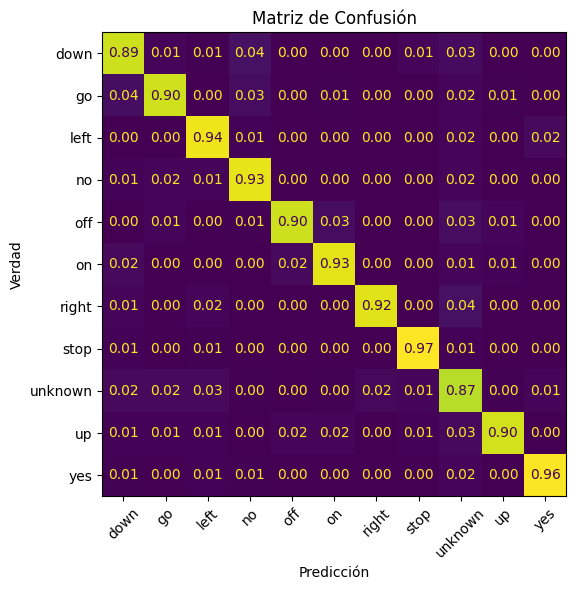

              precision    recall  f1-score   support

        down       0.87      0.89      0.88       396
          go       0.92      0.90      0.91       396
        left       0.92      0.94      0.93       396
          no       0.90      0.93      0.92       396
         off       0.95      0.90      0.92       396
          on       0.94      0.93      0.93       396
       right       0.97      0.92      0.95       396
        stop       0.96      0.97      0.96       396
     unknown       0.81      0.87      0.84       421
          up       0.96      0.90      0.93       396
         yes       0.96      0.96      0.96       396

    accuracy                           0.92      4381
   macro avg       0.92      0.92      0.92      4381
weighted avg       0.92      0.92      0.92      4381

Precisión global (Accuracy): 0.9201


In [ ]:
@torch.no_grad()
def get_predictions(loader, model, device="cpu"):
    """Obtiene las predicciones del modelo y las etiquetas verdaderas."""
    model.eval()
    all_predictions = []
    all_true_labels = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb).argmax(1)

        all_predictions.extend(pred.cpu().numpy())
        all_true_labels.extend(yb.cpu().numpy())
    return all_true_labels, all_predictions

true_labels, predictions = get_predictions(test_dl, model.to(device), device)

show_confusion_matrix(true_labels, predictions, class_names, title="Matriz de Confusión", filename = "matrizL_de_confusión_H=256")

In [ ]:
# Con 220 hop
transform = T.MFCC(sample_rate=sample_rate, n_mfcc=13, melkwargs={"n_fft": 400, "hop_length": 220, "n_mels": 23, "center": False},)
MFCC_train_10 = aplicar_MFCC(transform, train_adaptado)
MFCC_val_10 = aplicar_MFCC(transform, val_adaptado)
MFCC_test_10 = aplicar_MFCC(transform, test_adaptado)

{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
Epoch 1/20
Iteration 84 - Batch 84/508 - Train loss: 2.1947, Train acc: 26.31%
Iteration 168 - Batch 168/508 - Train loss: 1.9659, Train acc: 36.56%
Iteration 252 - Batch 252/508 - Train loss: 1.7279, Train acc: 45.74%
Iteration 336 - Batch 336/508 - Train loss: 1.5204, Train acc: 53.06%
Iteration 420 - Batch 420/508 - Train loss: 1.3604, Train acc: 58.28%
Iteration 504 - Batch 504/508 - Train loss: 1.2289, Train acc: 62.44%
Val loss: 0.5270, Val acc: 84.23%
Epoch 2/20
Iteration 592 - Batch 84/508 - Train loss: 0.5048, Train acc: 85.26%
Iteration 676 - Batch 168/508 - Train loss: 0.4802, Train acc: 85.74%
Iteration 760 - Batch 252/508 - Trai

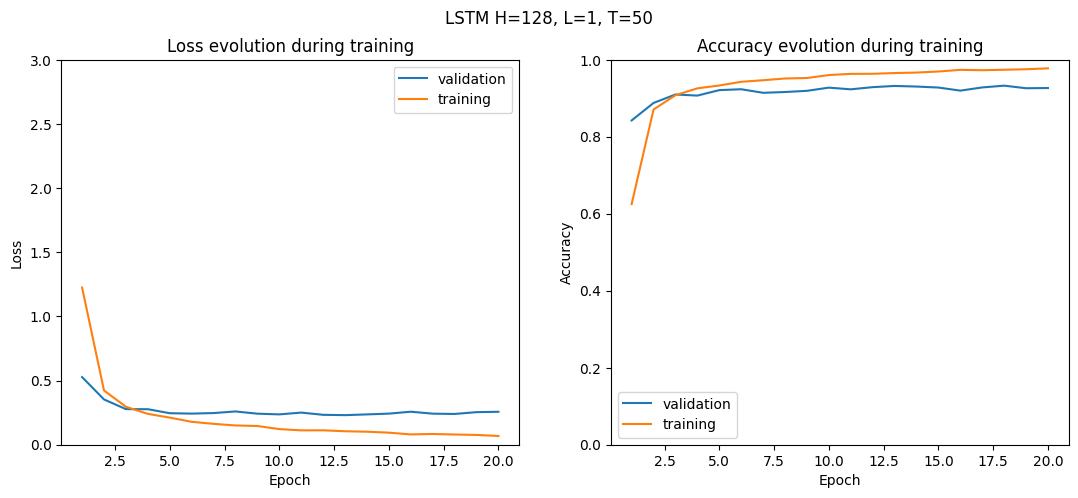

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


train_dl, val_dl, test_dl = load (MFCC_train_10, MFCC_val_10, MFCC_test_10, batch_size=64)

model = LSTMModel(input_size=39, hidden_size=128, num_layers=1,
                   bidirectional=False, num_classes=11)

criterion = nn.CrossEntropyLoss()

curves = train_model(
    model, train_dl, val_dl,
    epochs=20, lr=1e-3, criterion=criterion,
    device=device, early_stopping_patience=7
)

show_curves(curves, title="LSTM H=128, L=1, T=50", filename="LSTM_H=256.png")

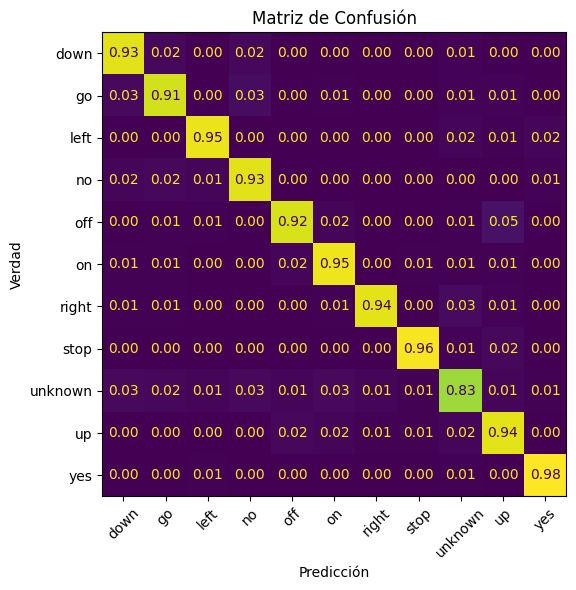

              precision    recall  f1-score   support

        down       0.92      0.93      0.93       396
          go       0.92      0.91      0.92       396
        left       0.95      0.95      0.95       396
          no       0.91      0.93      0.92       396
         off       0.94      0.92      0.93       396
          on       0.92      0.95      0.94       396
       right       0.97      0.94      0.95       396
        stop       0.98      0.96      0.97       396
     unknown       0.89      0.83      0.86       421
          up       0.89      0.94      0.91       396
         yes       0.96      0.98      0.97       396

    accuracy                           0.93      4381
   macro avg       0.93      0.93      0.93      4381
weighted avg       0.93      0.93      0.93      4381

Precisión global (Accuracy): 0.9311


In [ ]:
@torch.no_grad()
def get_predictions(loader, model, device="cpu"):
    """Obtiene las predicciones del modelo y las etiquetas verdaderas."""
    model.eval()
    all_predictions = []
    all_true_labels = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb).argmax(1)

        all_predictions.extend(pred.cpu().numpy())
        all_true_labels.extend(yb.cpu().numpy())
    return all_true_labels, all_predictions

true_labels, predictions = get_predictions(test_dl, model.to(device), device)

show_confusion_matrix(true_labels, predictions, class_names, title="Matriz de Confusión", filename = "matrizL_de_confusión_H=256")

In [ ]:
# Con 280 hop
transform = T.MFCC(sample_rate=sample_rate, n_mfcc=13, melkwargs={"n_fft": 400, "hop_length": 280, "n_mels": 23, "center": False},)
MFCC_train_10 = aplicar_MFCC(transform, train_adaptado)
MFCC_val_10 = aplicar_MFCC(transform, val_adaptado)
MFCC_test_10 = aplicar_MFCC(transform, test_adaptado)

{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
Epoch 1/20
Iteration 84 - Batch 84/508 - Train loss: 2.2074, Train acc: 25.29%
Iteration 168 - Batch 168/508 - Train loss: 1.9250, Train acc: 37.25%
Iteration 252 - Batch 252/508 - Train loss: 1.6849, Train acc: 46.83%
Iteration 336 - Batch 336/508 - Train loss: 1.4797, Train acc: 54.10%
Iteration 420 - Batch 420/508 - Train loss: 1.3221, Train acc: 59.41%
Iteration 504 - Batch 504/508 - Train loss: 1.1963, Train acc: 63.39%
Val loss: 0.5299, Val acc: 83.74%
Epoch 2/20
Iteration 592 - Batch 84/508 - Train loss: 0.4840, Train acc: 85.81%
Iteration 676 - Batch 168/508 - Train loss: 0.4574, Train acc: 86.38%
Iteration 760 - Batch 252/508 - Trai

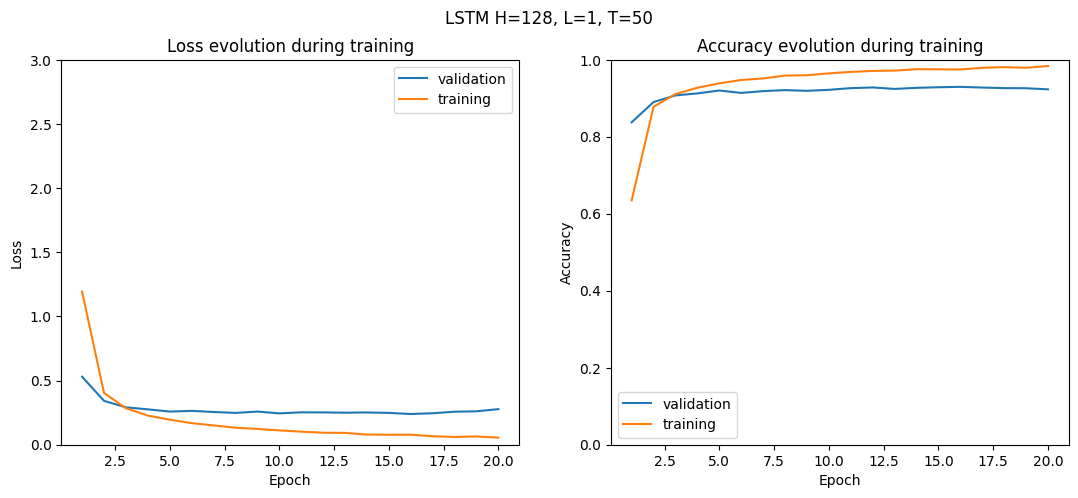

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


train_dl, val_dl, test_dl = load (MFCC_train_10, MFCC_val_10, MFCC_test_10, batch_size=64)

model = LSTMModel(input_size=39, hidden_size=128, num_layers=1,
                   bidirectional=False, num_classes=11)

criterion = nn.CrossEntropyLoss()

curves = train_model(
    model, train_dl, val_dl,
    epochs=20, lr=1e-3, criterion=criterion,
    device=device, early_stopping_patience=7
)

show_curves(curves, title="LSTM H=128, L=1, T=50", filename="LSTM_H=256.png")

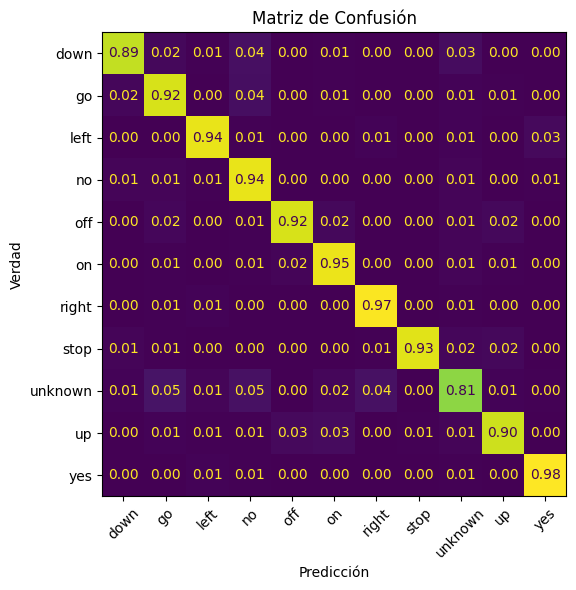

              precision    recall  f1-score   support

        down       0.94      0.89      0.91       396
          go       0.87      0.92      0.89       396
        left       0.95      0.94      0.95       396
          no       0.86      0.94      0.90       396
         off       0.96      0.92      0.94       396
          on       0.92      0.95      0.93       396
       right       0.93      0.97      0.95       396
        stop       0.98      0.93      0.96       396
     unknown       0.87      0.81      0.84       421
          up       0.92      0.90      0.91       396
         yes       0.96      0.98      0.97       396

    accuracy                           0.92      4381
   macro avg       0.92      0.92      0.92      4381
weighted avg       0.92      0.92      0.92      4381

Precisión global (Accuracy): 0.9219


In [ ]:
@torch.no_grad()
def get_predictions(loader, model, device="cpu"):
    """Obtiene las predicciones del modelo y las etiquetas verdaderas."""
    model.eval()
    all_predictions = []
    all_true_labels = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb).argmax(1)

        all_predictions.extend(pred.cpu().numpy())
        all_true_labels.extend(yb.cpu().numpy())
    return all_true_labels, all_predictions

true_labels, predictions = get_predictions(test_dl, model.to(device), device)

show_confusion_matrix(true_labels, predictions, class_names, title="Matriz de Confusión", filename = "matrizL_de_confusión_H=256")

In [ ]:
# Con 360 hop
transform = T.MFCC(sample_rate=sample_rate, n_mfcc=13, melkwargs={"n_fft": 400, "hop_length": 360, "n_mels": 23, "center": False},)
MFCC_train_10 = aplicar_MFCC(transform, train_adaptado)
MFCC_val_10 = aplicar_MFCC(transform, val_adaptado)
MFCC_test_10 = aplicar_MFCC(transform, test_adaptado)

{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'unknown': 8, 'up': 9, 'yes': 10}
Epoch 1/20
Iteration 84 - Batch 84/508 - Train loss: 2.1879, Train acc: 28.25%
Iteration 168 - Batch 168/508 - Train loss: 1.8530, Train acc: 42.53%
Iteration 252 - Batch 252/508 - Train loss: 1.5736, Train acc: 52.26%
Iteration 336 - Batch 336/508 - Train loss: 1.3695, Train acc: 58.70%
Iteration 420 - Batch 420/508 - Train loss: 1.2128, Train acc: 63.56%
Iteration 504 - Batch 504/508 - Train loss: 1.0945, Train acc: 67.13%
Val loss: 0.4562, Val acc: 86.25%
Epoch 2/20
Iteration 592 - Batch 84/508 - Train loss: 0.4188, Train acc: 87.63%
Iteration 676 - Batch 168/508 - Train loss: 0.4038, Train acc: 87.96%
Iteration 760 - Batch 252/508 - Trai

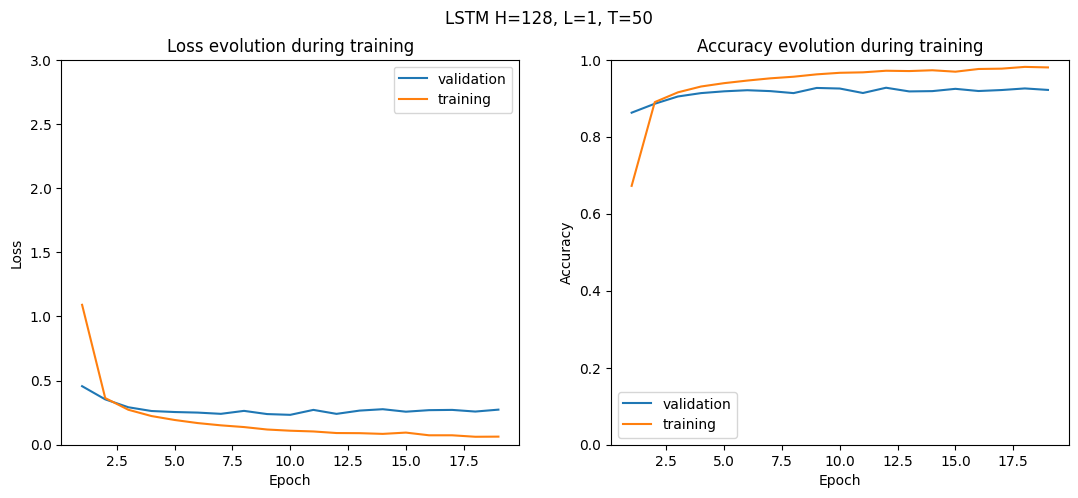

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


train_dl, val_dl, test_dl = load (MFCC_train_10, MFCC_val_10, MFCC_test_10, batch_size=64)

model = LSTMModel(input_size=39, hidden_size=128, num_layers=1,
                   bidirectional=False, num_classes=11)

criterion = nn.CrossEntropyLoss()

curves = train_model(
    model, train_dl, val_dl,
    epochs=20, lr=1e-3, criterion=criterion,
    device=device, early_stopping_patience=7
)

show_curves(curves, title="LSTM H=128, L=1, T=50", filename="LSTM_H=256.png")

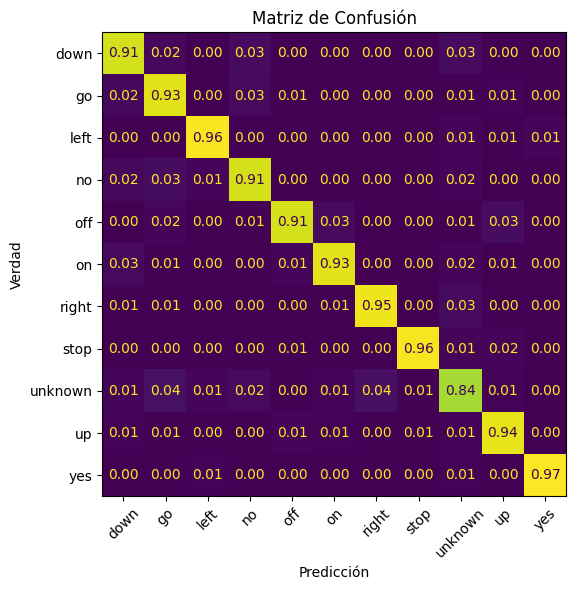

              precision    recall  f1-score   support

        down       0.90      0.91      0.90       396
          go       0.87      0.93      0.90       396
        left       0.95      0.96      0.96       396
          no       0.91      0.91      0.91       396
         off       0.96      0.91      0.93       396
          on       0.95      0.93      0.94       396
       right       0.95      0.95      0.95       396
        stop       0.98      0.96      0.97       396
     unknown       0.86      0.84      0.85       421
          up       0.91      0.94      0.93       396
         yes       0.98      0.97      0.98       396

    accuracy                           0.93      4381
   macro avg       0.93      0.93      0.93      4381
weighted avg       0.93      0.93      0.93      4381

Precisión global (Accuracy): 0.9265


In [ ]:
@torch.no_grad()
def get_predictions(loader, model, device="cpu"):
    """Obtiene las predicciones del modelo y las etiquetas verdaderas."""
    model.eval()
    all_predictions = []
    all_true_labels = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb).argmax(1)

        all_predictions.extend(pred.cpu().numpy())
        all_true_labels.extend(yb.cpu().numpy())
    return all_true_labels, all_predictions

true_labels, predictions = get_predictions(test_dl, model.to(device), device)

show_confusion_matrix(true_labels, predictions, class_names, title="Matriz de Confusión", filename = "matrizL_de_confusión_H=256")